Guilherme Oliveira - up202204987

Magda Costa - up202207036

Pedro Silva - up202205150

 -----------------------------------------------------------------------------------------------

# Urban Sounds Classification

## Índice  <a name = "indice"></a>
1. [Introdução](#introdução)
2. [Librosa VS Scipy.io](#l_vs_s)
3. [Análise Exploratória dos Dados](#aed)
4. [Pré-processamento dos Dados](#ppd)
5. [CNN 1D](#cnn_1d)
    - [Pré-Processamento - 1D CNN](#cnn_1d_pp)
    - [Arquitetura do Modelo - 1D CNN](#cnn_1d_am)
    - [Estratégia de Treino - 1D CNN](#cnn_1d_et)
6. [CNN 2D](#cnn_2d)
    - [Pré-Processamento - 2D CNN](#cnn_2d_pp)
    - [Arquitetura do Modelo - 2D CNN](#cnn_2d_am)
    - [Estratégia de Treino - 2D CNN](#cnn_2d_et)
    - [Teste dos Modelos - 2D CNN](#cnn_2d_tm)
7. [RNN](#rnn)
    - [Pré-Processamento - RNN](#rnn_pp)
    - [Arquitetura do Modelo - RNN](#rnn_am)
    - [Estratégia de Treino - RNN](#rnn_et)
    - [Teste dos Modelos - RNN](#rnn_tm)
8. [Implementação do DeepFool](#dp)
9. [Conclusão](#conclusao)
10. [Referências](#ref)

 -----------------------------------------------------------------------------------------------------------------------

## Introdução <a name = "introdução"></a>
[[voltar ao índice]](#indice)

Este projeto tem como objetivo desenvolver classificadores de deep learning para análise de dados sonoros urbanos, utilizando o dataset UrbanSound8K. Este dataset contém excertos sonoros rotulados em 10 categorias distintas, permitindo o desenvolvimento de modelos capazes de classificar sons do quotidiano urbano.

Inicialmente, optámos por implementar uma rede neuronal convolucional unidimensional (CNN 1D) que processasse diretamente o áudio bruto através de técnicas de "windowing" e pré-processamento de dados para normalizar os sinais de entrada. No entanto, esta abordagem revelou-se computacionalmente intensiva, apresentando limitações tanto em termos de tempo de processamento como na eficiência do modelo.

Face a estes desafios, direcionámos o nosso esforço para a implementação de redes convolucionais bidimensionais (CNN 2D) que utilizam espectrogramas como entrada, o que permitiu explorar de forma mais eficaz as características temporais e frequenciais dos dados. 

Além disso, para complementar a análise temporal dos sinais, implementámos também um modelo de rede neuronal recorrente (RNN) para capturar relações temporais de longo alcance.

Com esta combinação de abordagens, procurámos explorar diferentes métodos de representação e modelação de dados sonoros, avaliando o desempenho de cada técnica no contexto de classificação de sons urbanos.

Para a realização do trabalho foram necessárias as seguintes bibliotecas e funcionalidades:

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd 
from scipy.io import wavfile as wav
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
import os
import seaborn as sns
import soundfile as sf
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import defaultdict, Counter
import copy

## Librosa VS Scipy.io <a name = "l_vs_s"></a>
[[voltar ao índice]](#indice)

**Librosa:** é uma biblioteca especializada em análise e manipulação de áudio para aprendizado de máquina e processamento digital de sinais. Ela fornece uma ampla gama de ferramentas voltadas para extração de características e representações de áudio.

- Prós:

        - Suporta vários formatos de áudio (.wav, .mp3, etc.).
        - Extração avançada de features: Espectrogramas Mel, MFCCs, Chromagrams.
        - Fácil manipulação de áudio (resampling, padding, normalização).
        - Integração com visualizações (espectrogramas, MFCCs).
    
- Contras:

        - Mais lento para tarefas simples (carregar/salvar áudio).
        - Curva de aprendizado maior para iniciantes.
        - Depende de bibliotecas externas (audioread, ffmpeg).

**Scipy.io:** faz parte da biblioteca SciPy e é uma ferramenta simples e eficiente para ler e escrever arquivos .wav. Ele é útil para tarefas básicas de manipulação de áudio.

- Prós:

        - Simples, rápido e eficiente para carregar/salvar .wav.
        - Integração direta com NumPy para manipulação básica.
    
- Contras:

        - Limitado a .wav.
        - Não suporta extração de características avançadas.
        - Não oferece resampling, padding ou visualizações integradas.

Vamos analisar muito brevemente as diferenças entre librosa e scipy.io

In [2]:
filename = r"C:\Users\User\Desktop\UNI3\AC_II\Projeto\UrbanSound8K\audio\fold1\7061-6-0-0.wav"

In [3]:
librosa_audio, librosa_sample_rate = librosa.load(filename)
scipy_sample_rate, scipy_audio = wav.read(filename)

In [4]:
print("Librosa sample wave rate:", librosa_sample_rate)
print("Scipy sample wave rate : " , scipy_sample_rate )

Librosa sample wave rate: 22050
Scipy sample wave rate :  44100


In [5]:
print("Librosa audio signal " , librosa_audio)
print("Librosa audio data type:", librosa_audio.dtype)
print()
print("Scipy audio signal" , scipy_audio)
print("Scipy audio data type:", scipy_audio.dtype)

Librosa audio signal  [-7.4505806e-09  2.9802322e-08  4.8428774e-08 ...  1.0127544e-05
  2.3271263e-05  7.0009992e-06]
Librosa audio data type: float32

Scipy audio signal [[0 0]
 [0 0]
 [0 0]
 ...
 [1 0]
 [1 1]
 [0 0]]
Scipy audio data type: int16


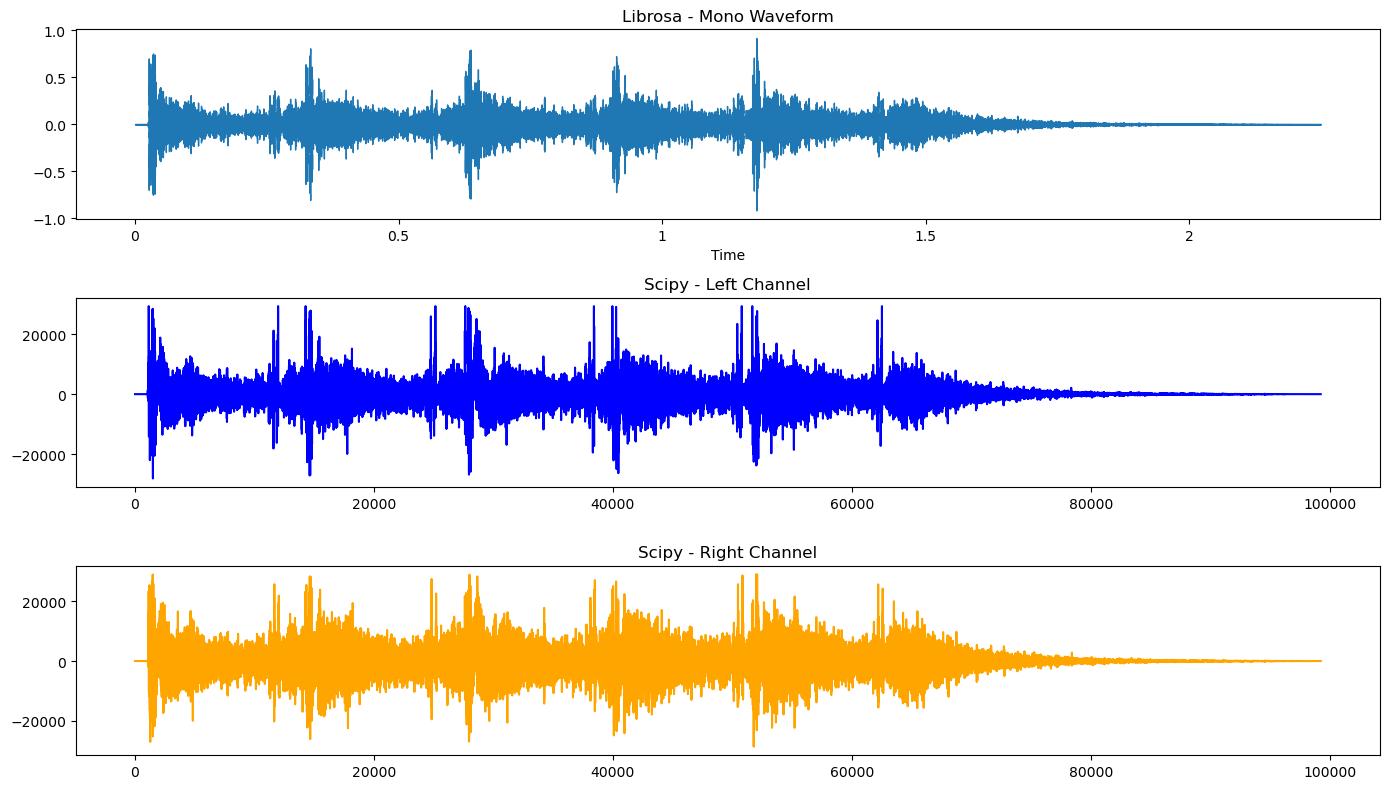

In [6]:
plt.figure(figsize=(14, 8))  # Ajuste o tamanho da figura para mais altura

# Plot librosa mono waveform
plt.subplot(3, 1, 1)
librosa.display.waveshow(librosa_audio, sr=librosa_sample_rate)
plt.title("Librosa - Mono Waveform")

# Plot scipy stereo waveform (each channel separately if stereo)
# Plot left and right channels in separate subplots
plt.subplot(3, 1, 2)
if scipy_audio.ndim > 1:  # Stereo
    plt.plot(scipy_audio[:, 0], label="Left Channel", color='blue')
    plt.title("Scipy - Left Channel")

    plt.subplot(3, 1, 3)
    plt.plot(scipy_audio[:, 1], label="Right Channel", color='orange')
    plt.title("Scipy - Right Channel")
else:  # Mono
    plt.plot(scipy_audio)
    plt.title("Scipy - Mono Waveform")

# Ajustar o layout para evitar sobreposição
plt.tight_layout()
plt.show()

Tendo em conta todos os prós e contras previamente referidos, decidimos que para este trabalho **iremos usar librosa**, pois apresenta mais vantagens para este tipo de projeto. Para além disso permite por default converter todos os áudios para uma taxa de amostragem de 22050 Hz (normalmente utilizado em modelos de aprendizagem e processamento de áudio), permite converter o áudio num único sinal (mono sound) e permite também normalizar o áudio ao contrário do scipy, que converte o áudio em arrays. 

## Análise Exploratória dos Dados <a name = "aed"></a>
[[voltar ao índice]](#indice)

Vamos começar por importar o ficheiro que contem dados relativos à metadata dos áudios que vem com o download do dataset:

In [7]:
df_metadata = pd.read_csv("UrbanSound8K.csv")

In [8]:
df_metadata.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

Tal como é descrito no [website](#ref_1) que nos permite fazer download do dataset sabemos que neste csv se encontram informações relativas aos diferentes audios utilizados no dataset tais como:

- **slice_file_name:** Diz repeito ao nome do áudio no dataset que dá informações como o ID do áudio original extraido do Freesound, o identificador da classe à qual o som pertence, entre outros.
- **fsID:** Indica qual o ID do áudio orginial no FreeSound de onde a slice do dataset pertence
- **start:** Representa o tempo no qual a slice extraida começa no áudio original
- **end:** Representa o tempo no qual a slice extraida termina no áudio original
- **salience:** Permite saber se o áudio foi obtido como 'foreground'(1) ou 'background'(2)
- **fold:** Indica em que fold foi colocada a slice, podendo este variar entre 1 e 10
- **classID:** Indica de modo numérico a que classe pertence o áudio
- **class:** Indica a que classe pertence o áudio

Tendo isto em conta iremos subdividir a análise exploratória em duas partes, sendo essas:
- [Problemas com os dados?](#pcod_ade)
- [Análise Detalhada](#ad_ade)

### Problemas com os dados? <a name = "pcod_ade"></a>
[[voltar a Análise Exploratória dos Dados]](#aed)

Antes de começarmos a analisar de um modo mais aprofundado os dados que temos, devemos primeiro entender se há algum problema com os mesmos:

- **Há Valores Nulos?**

In [9]:
print(df_metadata.isnull().sum())

slice_file_name    0
fsID               0
start              0
end                0
salience           0
fold               0
classID            0
class              0
dtype: int64


Como podemos ver o dataset **não apresenta valores nulos** o que é ótimo tendo em conta que tal significa que não há dados em falta, sendo, portanto, possivel saber a classificação correta de cada áudio.

- **Há Valores Repetidos?**

In [10]:
duplicates = df_metadata.duplicated()
print(f"Duplicados: {duplicates.sum()}")

Duplicados: 0


Também **não existem valores duplicados**, isto é, cada áudio presente no dataset, mesmo que venha do mesmo áudio original do FreeSound, não é igual a nenhum outro, pois correponderá a slices diferentes no áudio.

- **Consistência de Dados:**

Apesar de aparentemente não haver problemas nos dados, de acordo com a metadata dos áudios, precisamos de confirmar se por algum motivo há algum arquivo listado na metadata que não aparece no diretório dos áudios ou se há algum áudio que não aparece na metadata. Para isso vamos começar por atribuir a uma variável o caminho para o diretório onde os áudios se encontram:

In [11]:
# Para realizar este teste, deve alterar o caminho para o que tem no seu computador
audios_dir = r"C:\Users\User\Desktop\UNI3\AC_II\Projeto\UrbanSound8K\audio"

- Vamos começar por testar se todos os arquivos de áudio descritos na metadata encontram-se nas pastas corretas:

In [12]:
# Inicializar lista de arquivos ausentes
missing_files = []

for index, row in df_metadata.iterrows():
    # Construir o caminho esperado do arquivo
    fold = row['fold']
    folder_name = "fold" + str(fold)
    file_name = row['slice_file_name']
    file_path = os.path.join(audios_dir, folder_name, file_name)
    
    # Verificar se o arquivo existe
    if not os.path.isfile(file_path):
        missing_files.append(file_path)

# Exibir arquivos ausentes
if missing_files:
    print(f"Arquivos ausentes ({len(missing_files)}):")
    for file in missing_files:
        print(file)
else:
    print("Todos os arquivos estão presentes.")

Todos os arquivos estão presentes.


- Agora vamos verificar se existem ficheiros extra nos diferentes folds:

In [13]:
# Inicializar lista de arquivos extras
extra_files = []

for fold in range(1, 11):  # Pastas de 1 a 10
    folder_name = "folder" + str(fold)
    folder_path = os.path.join(audios_dir, folder_name)
    if os.path.exists(folder_path):
        # Listar todos os arquivos na pasta
        files_in_folder = os.listdir(folder_path)
        # Filtrar apenas os arquivos de áudio
        audio_files = [f for f in files_in_folder if f.endswith('.wav')]
        
        # Comparar com os arquivos listados no CSV
        expected_files = metadata[metadata['fold'] == fold]['slice_file_name'].tolist()
        for audio_file in audio_files:
            if audio_file not in expected_files:
                extra_files.append(os.path.join(folder_path, audio_file))

# Exibir arquivos extras
if extra_files:
    print(f"Arquivos extras ({len(extra_files)}):")
    for file in extra_files:
        print(file)
else:
    print("Nenhum arquivo extra encontrado.")


Nenhum arquivo extra encontrado.


Como podemos comprovar não existem incongruências nos dados descritos na metadata e nos ficheiros áudio que possuimos. Podemos, portanto, passar a uma análise mais detalhada dos dados.

### Análise Detalhada <a name = "ad_ade"></a>
[[voltar a Análise Exploratória dos Dados]](#aed)

- **Distribuição das Classes**

Como sabemos este dataset apresenta 10 tipos de classes às quais os áudios podem pertencer, sendo essas:

        0 = air_conditioner
        1 = car_horn
        2 = children_playing
        3 = dog_bark
        4 = drilling
        5 = engine_idling
        6 = gun_shot
        7 = jackhammer
        8 = siren
        9 = street_music
        
        
A questão a que gostavamos de responder é: "Temos áudios suficientes que permitam que as classes se encontrem bem distribuidas?"

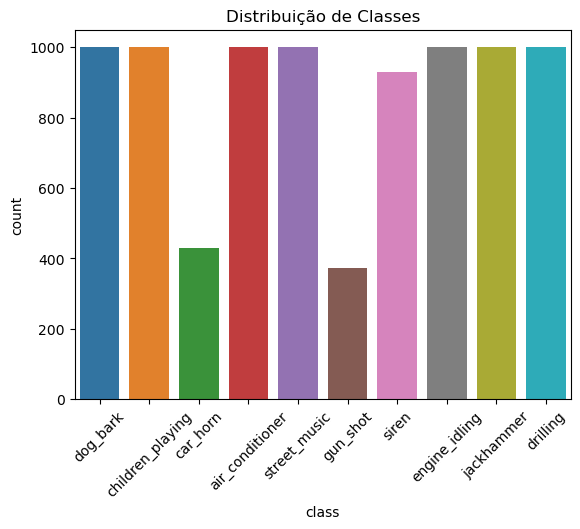

In [14]:
sns.countplot(data = df_metadata, x = 'class')
plt.xticks(rotation = 45)
plt.title('Distribuição de Classes')
plt.show()

In [15]:
df_metadata['class'].value_counts(normalize= True)

dog_bark            0.114521
children_playing    0.114521
air_conditioner     0.114521
street_music        0.114521
engine_idling       0.114521
jackhammer          0.114521
drilling            0.114521
siren               0.106390
car_horn            0.049130
gun_shot            0.042831
Name: class, dtype: float64

Como podemos perceber as classes 'car_horn' e 'gun_shot' apresentam pouco menos de metade das restantes entradas, havendo, portanto, menos áudios desses tipos. Contudo o dataset não parece estar severamente desiquilibrado, motivo pelo qual, de momento decidimos não considerar o aumento de dados para estas classes minoritárias.

- **Distribuição de Classes por Fold**

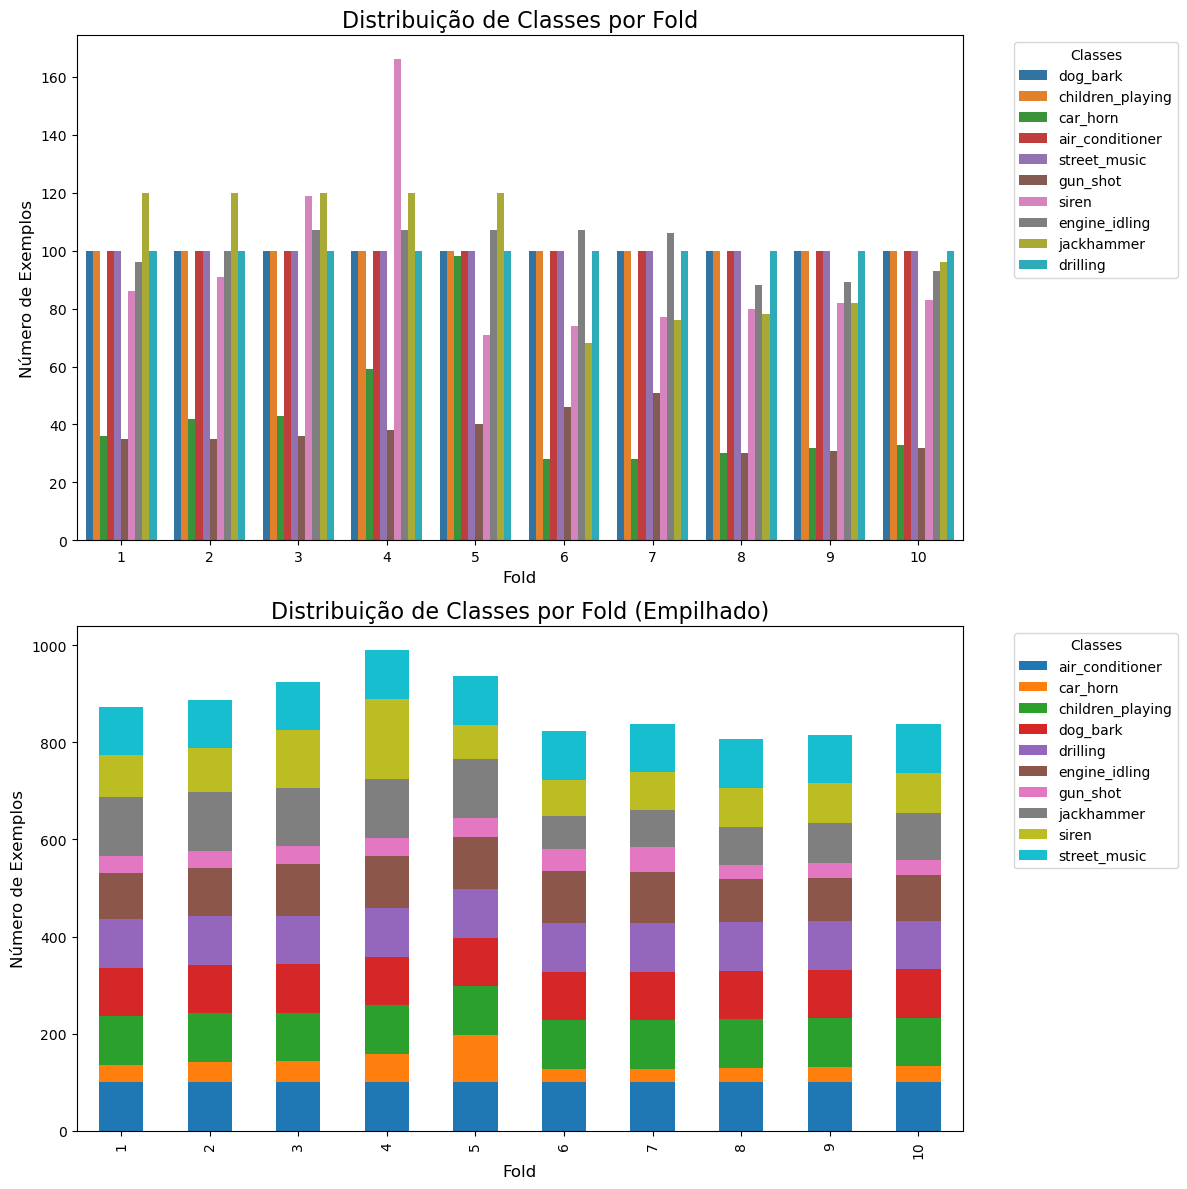

In [16]:
# Criar a figura e os subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 12))  # 2 linhas, 1 coluna

# Paleta de cores contrastantes
palette = sns.color_palette("tab10")  # Pode mudar para "Set2" ou outra que prefira

# Primeiro gráfico: Countplot
sns.countplot(
    data=df_metadata, 
    x='fold', 
    hue='class', 
    palette=palette, 
    ax=axes[0]
)
axes[0].set_title('Distribuição de Classes por Fold', fontsize=16)
axes[0].set_xlabel('Fold', fontsize=12)
axes[0].set_ylabel('Número de Exemplos', fontsize=12)
axes[0].legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

# Contar o número de exemplos de cada classe por fold
class_fold_distribution = df_metadata.groupby(['fold', 'class']).size().unstack(fill_value=0)

# Segundo gráfico: Barras empilhadas
class_fold_distribution.plot(
    kind='bar', 
    stacked=True, 
    colormap='tab10',  # Use tab10 para um contraste melhor
    ax=axes[1]
)
axes[1].set_title('Distribuição de Classes por Fold (Empilhado)', fontsize=16)
axes[1].set_xlabel('Fold', fontsize=12)
axes[1].set_ylabel('Número de Exemplos', fontsize=12)
axes[1].legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustar layout para evitar sobreposição
plt.tight_layout()
plt.show()

In [17]:
appended = []
for i in range(1,11):
    appended.append(df_metadata[df_metadata.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

index  jackhammer  dog_bark  children_playing  street_music  \
0   fold1         120       100               100           100   
1   fold2         120       100               100           100   
2   fold3         120       100               100           100   
3   fold4         120       100               100           100   
4   fold5         120       100               100           100   
5   fold6          68       100               100           100   
6   fold7          76       100               100           100   
7   fold8          78       100               100           100   
8   fold9          82       100               100           100   
9  fold10          96       100               100           100   

   air_conditioner  drilling  engine_idling  siren  car_horn  gun_shot  
0              100       100             96     86        36        35  
1              100       100            100     91        42        35  
2              100       100            107    119        43        36  
3              100       100            107    166        59        38  
4              100       100            107     71        98        40  
5              100       100            107     74        28        46  
6              100       100            106     77        28        51  
7              100       100             88     80        30        30  
8              100       100             89     82        32        31  
9              100       100             93     83        33        32

Apesar de haver classes com menos entradas que outras, conseguimos perceber que por fold as classes parecem estar bem divididas, havendo aproximadamente o mesmo número de entradas por classe em cada fold.

- **Análise da Saliência**

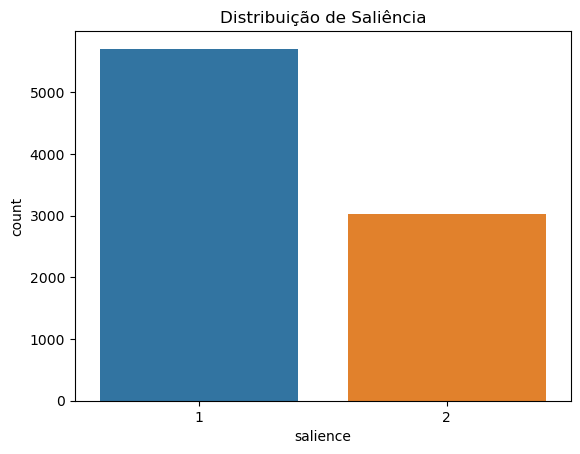

In [18]:
sns.countplot(data = df_metadata, x = 'salience')
plt.title('Distribuição de Saliência')
plt.show()

Concluimos que maior parte dos áudios obtidos são classificados como tendo sido obtidos em 'foreground'. 

- **Duração dos Áudios**

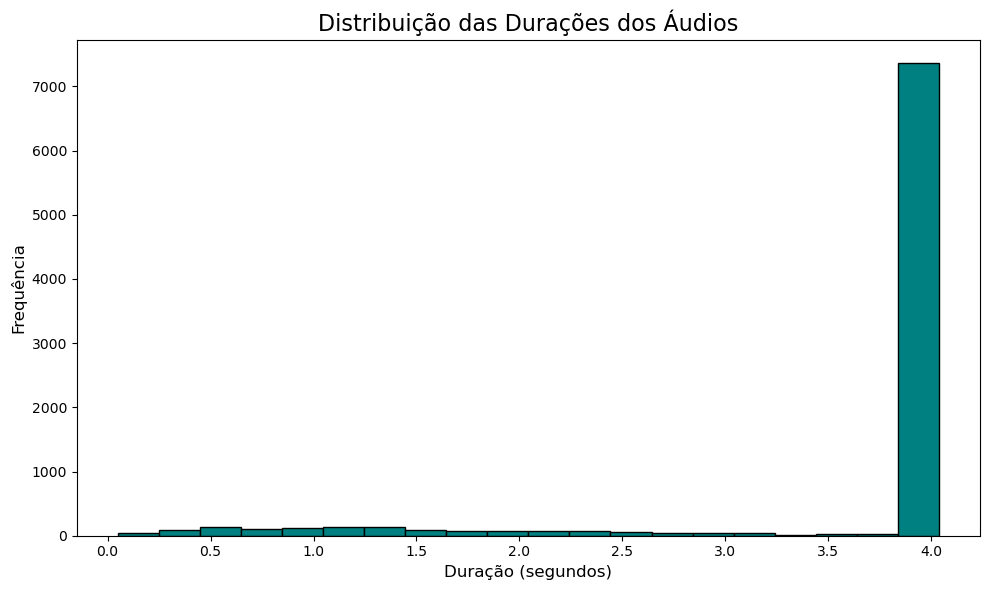

In [19]:
# Lista para armazenar as durações
durations = []

# Processar cada áudio
for index, row in df_metadata.iterrows():
    fold = row['fold']
    fold_name = "fold" + str(fold)
    file_name = row['slice_file_name']
    file_path = os.path.join(audios_dir, fold_name, file_name)
    
    if os.path.isfile(file_path):
        # Carregar o áudio
        y, sr = librosa.load(file_path, sr=None)  # sr=None para manter a taxa original
        # Obter duração original
        durations.append(librosa.get_duration(y=y, sr=sr))
    else:
        print(f"Arquivo não encontrado: {file_path}")

# Visualizar distribuição das durações
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20, color='teal', edgecolor='black')
plt.title('Distribuição das Durações dos Áudios', fontsize=16)
plt.xlabel('Duração (segundos)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.tight_layout()
plt.show()

Apesar de a maioria dos áudios presentes no dataset terem uma duração de 4 segundos, existem alguns que apresentam uma duração menor. Tal acontecimento deverá ser tido em conta e corrigido.

- **Visualização de Uma Onda de Som**

In [20]:
filename = r"C:\Users\User\Desktop\UNI3\AC_II\Projeto\UrbanSound8K\audio\fold1\7061-6-0-0.wav"
librosa_audio, librosa_sample_rate = librosa.load(filename)

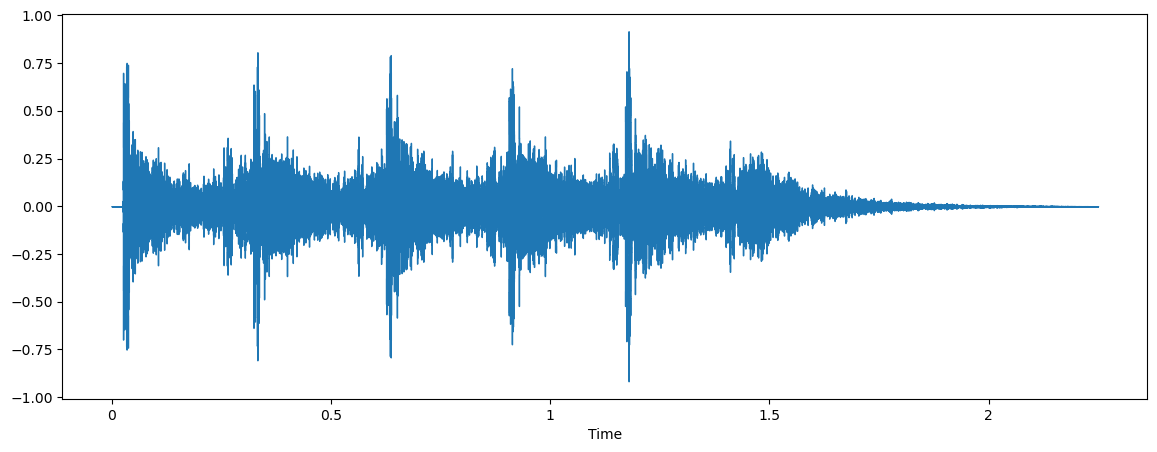

In [21]:
plt.figure(figsize=(14,5))
librosa_audio ,librosa_sample_rate=librosa.load(filename)
librosa.display.waveshow(librosa_audio,sr=librosa_sample_rate)
ipd.Audio(filename)

- **Espectrograma Mel e MFCCs de Áudios**

Um **Espectograma Mel** mostra a intensidade da energia em diferentes bandas de frequência ao longo do tempo. Ele é baseado na escala Mel, que imita a percepção humana de som.

**Como analisar?**

    - Componentes de Frequência:
        - Picos em frequências específicas indicam sons tonais (ex.: música, sirenes).
        - Energia distribuída indica ruídos (ex.: motores, jackhammers).
    - Mudanças ao longo do tempo:
        - Sons estacionários (como motores idling) terão espectrogramas constantes.
        - Sons dinâmicos (como latidos de cachorro) terão mudanças rápidas na intensidade e frequência.
    - Comparar entre classes:
        - Analise como diferentes sons ocupam o espaço tempo-frequência.

Os **MFCCs (Mel-Frequency Cepstral Coefficients)** são uma redução do espectrograma em coeficientes que representam as características acústicas mais relevantes, especialmente em tarefas como reconhecimento de fala e som.

**Como analisar?**

    - Coeficientes iniciais:
        - Representam as frequências de baixa energia (estrutura geral do som).
    - Coeficientes mais altos:
        - Capturam mudanças rápidas no espectro.
    - Padrões entre classes:
        - Sons como "música de rua" podem ter coeficientes com variações suaves.
        - Sons como "latidos" podem ter coeficientes com mudanças bruscas.

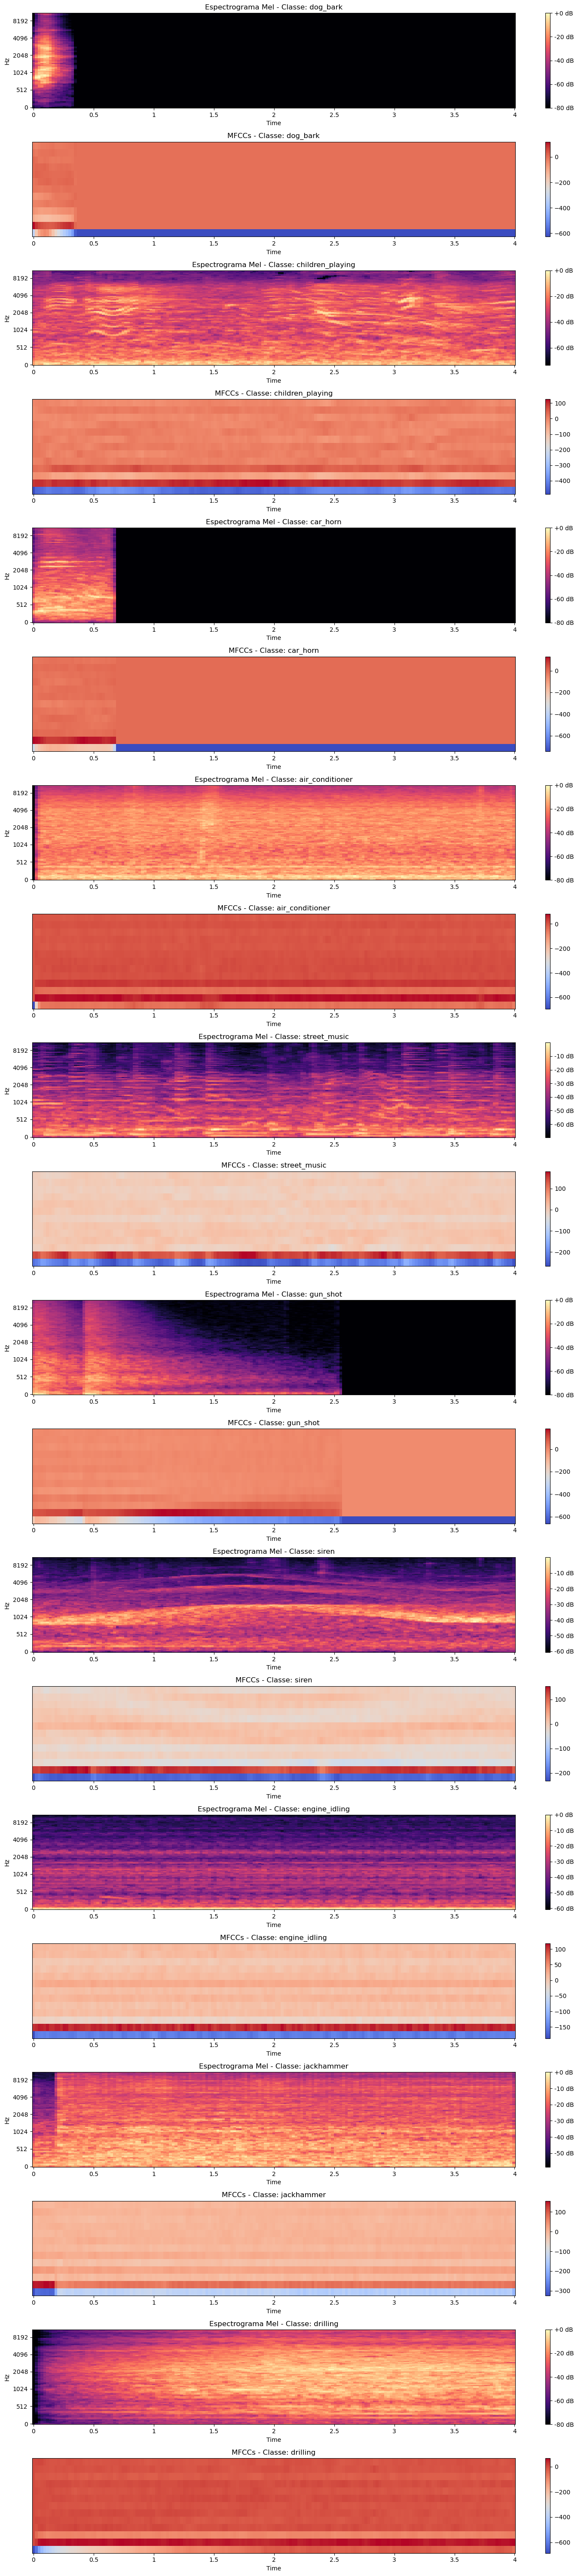

In [22]:
# Configuração de visualização
sample_rate = 22050  # Taxa de amostragem padrão
target_duration = 4.0  # em segundos
n_mels = 128  # Número de bandas Mel
n_mfcc = 13  # Número de coeficientes MFCC

# Selecionar um exemplo de cada classe
classes = df_metadata['class'].unique()
examples = []

for class_name in classes:
    example = df_metadata[df_metadata['class'] == class_name].iloc[0]
    examples.append(example)

# Criar subplots para Espectrograma Mel e MFCCs
plt.figure(figsize=(15, len(classes) * 6))  # Configuração do tamanho do gráfico

for i, row in enumerate(examples):
    fold = row['fold']
    fold_name = "fold" + str(fold)
    file_name = row['slice_file_name']
    file_path = os.path.join(audios_dir, fold_name, file_name)

    if os.path.isfile(file_path):
        # Carregar o áudio
        y, sr = librosa.load(file_path, sr=sample_rate)

        # Normalizar duração (truncar ou adicionar zero-padding)
        if len(y) < int(target_duration * sr):
            padding = int((target_duration * sr) - len(y))
            y = np.pad(y, (0, padding), mode='constant')
        else:
            y = y[:int(target_duration * sr)]

        # Espectrograma Mel
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=8000)

        # MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

        # Plotar Espectrograma Mel
        plt.subplot(len(classes) * 2, 1, 2 * i + 1)
        librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Espectrograma Mel - Classe: {row['class']}", fontsize=12)

        # Plotar MFCCs
        plt.subplot(len(classes) * 2, 1, 2 * i + 2)
        librosa.display.specshow(mfccs, sr=sr, x_axis='time')
        plt.colorbar()
        plt.title(f"MFCCs - Classe: {row['class']}", fontsize=12)

plt.tight_layout()
plt.show()

## Pré-processamento dos Dados <a name = "ppd"></a>
[[voltar ao índice]](#indice)

Após fazermos uma análise geral dos dados, percebemos que existem alguns problemas com o dataset que devem ser resolvidos. Vamos, portanto, passar para o Pré-processamento dos Dados que é essencial para preparar o dataset para treinar os modelos de aprendizagem automática com os dados.

Vamos começar por tratar da 'Raw Data' isto é adaptar os dados de modo a que cumpram os seguintes requesitos:

- **Uniformizar a Taxa de Amostragem:** Todos os áudios devem ser convertidos para uma mesma taxa de amostragem (neste caso, 22050 Hz)
    
    - Garante que os modelos processam os dados de forma consistente.
    - Facilita comparações e processamento subsequente.
    - A taxa de 22050 Hz é uma escolha padrão, suficientemente detalhada para a maioria das aplicações de áudio.

- **Converter para Mono:** Os áudios estereo (com canais esquerdo e direito) são convertidos para mono (um único canal) a partir da média dos dois canais.

    - Reduz a complexidade dos dados, mantendo apenas as informações essenciais.
    - Para tarefas como classificação de sons, o canal adicional (stereo) raramente melhora a performance.
    - Modelos esperam entradas consistentes em termos de dimensão.

- **Padronizar a Duração dos Áudios:** Todos os áudios são ajustados com uma duração uniforme, neste caso 4 segundos, tal como é sugerido em [[1]](#ref_1). Para isso estamos a usar zero-padding ou truncamento.

    - Os modelos requerem entradas com dimensões fixas.
    - Mantém a integridade temporal dos dados, mesmo para áudios mais curtos.

- **Normalizar a Amplitude:** Os valores de amplitude são escalados para o intervalo [-1,1].

    - Evita que áudios com volumes mais altos dominem os restantes durante o treino.
    - Garante que todos os áudios têm a mesma escala relativa de intensidade.

Estas alterações que acabamos de indicar devem ser realizadas para ambos os modelos que estamos a pensar utilizar. O código em baixo trata de executar as alterações mencionadas e de guardar os áudios alterados nos novos respetivos folders numa nova pasta chamada "audio_processed". 

[[skip_code]](#sc_1)

In [23]:
# Configurações gerais
sample_rate = 22050  # Taxa de amostragem
target_duration = 4.0  # Duração alvo em segundos

In [24]:
# Função de pré-processamento: Carrega, padroniza e normaliza o áudio.
def preprocess_audio(file_path):
    # Carregar áudio com Librosa
    y, sr = librosa.load(file_path, sr = sample_rate, mono = True)
    
    # Padronizar duração (zero-padding ou truncamento)
    if len(y) < int(target_duration * sr):
        padding = int((target_duration * sr) - len(y))
        y = np.pad(y, (0, padding), mode = 'constant')
    else:
        y = y[:int(target_duration * sr)]
    
    # Normalizar amplitude para o intervalo [-1, 1]
    y = y / np.max(np.abs(y))
    return y

In [25]:
# Criar a estrutura de diretórios para guardar os ficheiros pré-processados
def create_output_folders(base_dir, num_folds = 10):
    os.makedirs(base_dir, exist_ok = True)
    for fold in range(1, num_folds + 1):
        os.makedirs(os.path.join(base_dir, f"fold{fold}"), exist_ok = True)

In [26]:
# Processar todos os áudios do dataset
def process_dataset(metadata_path, audio_base_dir, output_dir):
    # Carregar metadados
    metadata = pd.read_csv(metadata_path)
    
    # Criar diretórios de saída
    create_output_folders(output_dir)
    
    # Iterar sobre os ficheiros nos metadados
    for _, row in metadata.iterrows():
        fold = row['fold']
        file_name = row['slice_file_name']
        class_id = row['classID']  # Opcional: pode ser útil guardar a classe nos ficheiros
        
        # Caminho do ficheiro de áudio original
        file_path = os.path.join(audio_base_dir, f"fold{fold}", file_name)
        
        if os.path.isfile(file_path):
            # Pré-processar o áudio
            y_processed = preprocess_audio(file_path)
            
            # Caminho para guardar o ficheiro processado
            output_path = os.path.join(output_dir, f"fold{fold}", file_name)
            
            # Guardar o áudio processado
            sf.write(output_path, y_processed, samplerate=sample_rate)
        else:
            print(f"Ficheiro não encontrado: {file_path}")

In [27]:
# Configurações específicas do dataset UrbanSound8K
metadata_csv = r"C:\Users\User\Desktop\UNI3\AC_II\Projeto\UrbanSound8K\metadata\UrbanSound8K.csv"  # Caminho para o ficheiro de metadados
audio_dir = r"C:\Users\User\Desktop\UNI3\AC_II\Projeto\UrbanSound8K\audio"  # Diretório base com os ficheiros de áudio
output_base_dir = r"C:\Users\User\Desktop\UNI3\AC_II\Projeto\UrbanSound8K\audio_processed"  #Diretório onde guardar os dados pre-processados

In [28]:
# Executar o pré-processamento
process_dataset(metadata_csv, audio_dir, output_base_dir)
print(f"Todos os áudios foram processados e guardados na pasta '{output_base_dir}'.")

Todos os áudios foram processados e guardados na pasta 'C:\Users\User\Desktop\UNI3\AC_II\Projeto\UrbanSound8K\audio_processed'.


[fim de skip]<a name = "sc_1"></a>

### Confirmar que as Alterações Foram Realizadas com Sucesso

Começamos por atualizar a variável 'audios_dir' para o nodo diretório, isto é o que contém os dados pre-processados.

In [29]:
# Para realizar este teste, deve alterar o caminho para o que tem no seu computador
audios_dir = r"C:\Users\User\Desktop\UNI3\AC_II\Projeto\UrbanSound8K\audio_processed"

Opcional: Confirmar que as alterações foram feitas em todos os documentos:

- Confirmar se todos os ficheiros de metadata estão em 'audio_processed':

In [30]:
# Inicializar lista de arquivos ausentes
missing_files = []

for index, row in df_metadata.iterrows():
    # Construir o caminho esperado do arquivo
    fold = row['fold']
    folder_name = "fold" + str(fold)
    file_name = row['slice_file_name']
    file_path = os.path.join(audios_dir, folder_name, file_name)
    
    # Verificar se o arquivo existe
    if not os.path.isfile(file_path):
        missing_files.append(file_path)

# Exibir arquivos ausentes
if missing_files:
    print(f"Arquivos ausentes ({len(missing_files)}):")
    for file in missing_files:
        print(file)
else:
    print("Todos os arquivos estão presentes.")

Todos os arquivos estão presentes.


- Agora vamos verificar se existem ficheiros extra nos diferentes folds:

In [31]:
# Inicializar lista de arquivos extras
extra_files = []

for fold in range(1, 11):  # Pastas de 1 a 10
    folder_name = "folder" + str(fold)
    folder_path = os.path.join(audios_dir, folder_name)
    if os.path.exists(folder_path):
        # Listar todos os arquivos na pasta
        files_in_folder = os.listdir(folder_path)
        # Filtrar apenas os arquivos de áudio
        audio_files = [f for f in files_in_folder if f.endswith('.wav')]
        
        # Comparar com os arquivos listados no CSV
        expected_files = metadata[metadata['fold'] == fold]['slice_file_name'].tolist()
        for audio_file in audio_files:
            if audio_file not in expected_files:
                extra_files.append(os.path.join(folder_path, audio_file))

# Exibir arquivos extras
if extra_files:
    print(f"Arquivos extras ({len(extra_files)}):")
    for file in extra_files:
        print(file)
else:
    print("Nenhum arquivo extra encontrado.")


Nenhum arquivo extra encontrado.


- **Confirmar se todos os áudios tem a mesma taxa de amostragem:**

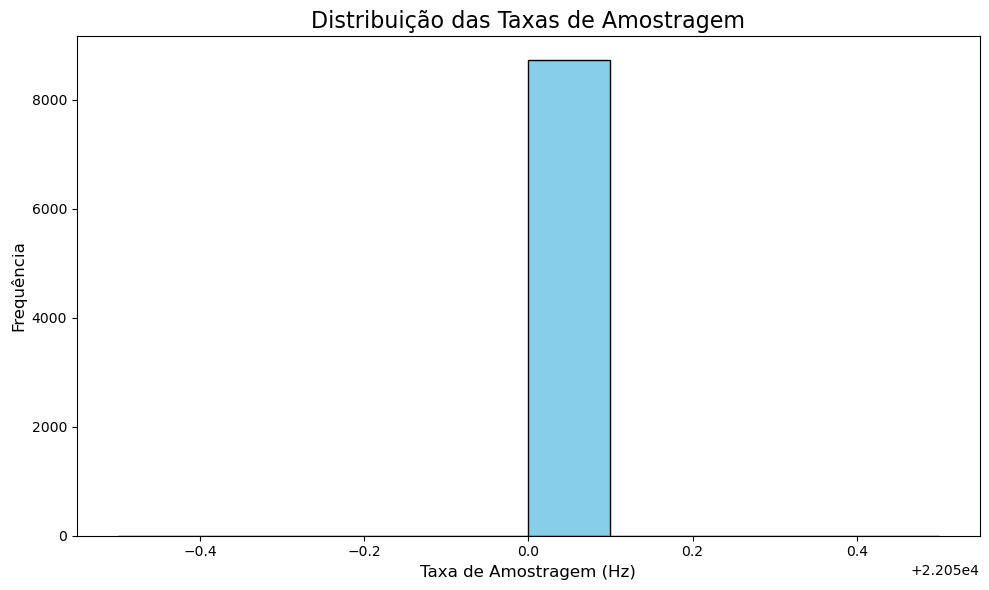

In [32]:
sampling_rates = []

for index, row in df_metadata.iterrows():
    fold = row['fold']
    fold_name = "fold" + str(fold)
    file_name = row['slice_file_name']
    file_path = os.path.join(audios_dir, fold_name, file_name)
    
    if os.path.isfile(file_path):
        _, sr = librosa.load(file_path, sr=None)
        sampling_rates.append(sr)
    else:
        print(f"Arquivo não encontrado: {file_path}")

# Visualizar as taxas de amostragem
plt.figure(figsize=(10, 6))
plt.hist(sampling_rates, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribuição das Taxas de Amostragem', fontsize=16)
plt.xlabel('Taxa de Amostragem (Hz)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.tight_layout()
plt.show()

Como podemos observar, de facto, todos os áudios ficaram com a mesma taxa de amostragem. Vamos apenas confirmar se é o valor que esperamos:

In [33]:
def check_sample_rates(audio_dir):
    sample_rates = []
    for folder in os.listdir(audio_dir):
        folder_path = os.path.join(audio_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith(".wav"):
                    file_path = os.path.join(folder_path, file)
                    _, sr = librosa.load(file_path)  # Load with original sample rate
                    sample_rates.append(sr)
    return set(sample_rates)  # Return unique sample rates


unique_sample_rates = check_sample_rates(audio_dir)
print(f"Unique sample rates in the dataset: {unique_sample_rates}")

Unique sample rates in the dataset: {22050}


- **Confirmar se são todos mono**

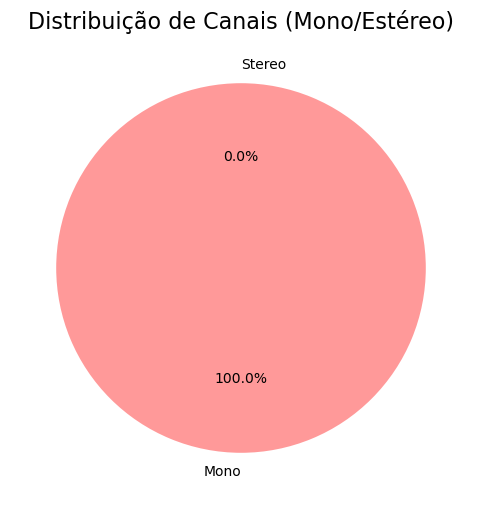

Stereo: 0
Mono: 8732


In [34]:
channel_counts = []

for index, row in df_metadata.iterrows():
    fold = row['fold']
    fold_name = "fold" + str(fold)
    file_name = row['slice_file_name']
    file_path = os.path.join(audios_dir, fold_name, file_name)
    
    if os.path.isfile(file_path):
        y, _ = librosa.load(file_path, sr=None, mono=False)
        if len(y.shape) == 1:
            channel_counts.append("Mono")
        else:
            channel_counts.append("Stereo")
    else:
        print(f"Arquivo não encontrado: {file_path}")

# Visualizar proporção de canais
plt.figure(figsize=(8, 6))
plt.pie(
    [channel_counts.count("Mono"), channel_counts.count("Stereo")],
    labels=["Mono", "Stereo"],
    autopct='%1.1f%%',
    colors=['#FF9999', '#66B3FF'],
    startangle=90
)
plt.title('Distribuição de Canais (Mono/Estéreo)', fontsize=16)
plt.show()

repetitions = Counter(channel_counts)
print(f"Stereo: {repetitions['Stereo']}")
print(f"Mono: {repetitions['Mono']}")

Todos os áudios estão no formato Mono.

- **Vamos confirmar se todos os áudios tem a mesma duração:**

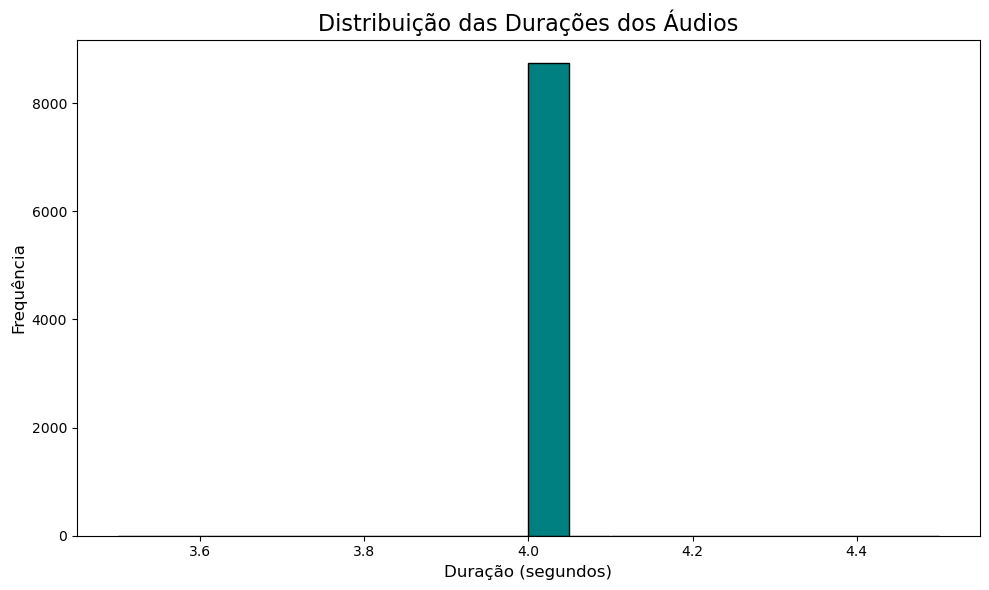

Counter({4.0: 8732})


In [35]:
# Lista para armazenar as durações
durations = []

# Processar cada áudio
for index, row in df_metadata.iterrows():
    fold = row['fold']
    fold_name = "fold" + str(fold)
    file_name = row['slice_file_name']
    file_path = os.path.join(audios_dir, fold_name, file_name)
    
    if os.path.isfile(file_path):
        # Carregar o áudio
        y, sr = librosa.load(file_path, sr=None)  # sr=None para manter a taxa original
        # Obter duração original
        durations.append(librosa.get_duration(y=y, sr=sr))
    else:
        print(f"Arquivo não encontrado: {file_path}")

# Visualizar distribuição das durações
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20, color='teal', edgecolor='black')
plt.title('Distribuição das Durações dos Áudios', fontsize=16)
plt.xlabel('Duração (segundos)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.tight_layout()
plt.show()

repetitions = Counter(durations)
print(repetitions)

Concluimos que de facto passaram todos a ter 4 segundos de duração.

-**Confirmar a normalização da Amplitude**

In [36]:
# Lista para armazenar os resultados
normalization_checks = []

# Iterar pelos arquivos de áudio processados
for root, _, files in os.walk(audios_dir):
    for file in files:
        file_path = os.path.join(root, file)
        
        # Carregar o áudio
        y, sr = librosa.load(file_path, sr=None)
        
        # Verificar o intervalo de amplitude
        max_value = np.max(y)
        min_value = np.min(y)
        
        # Verificar se está normalizado
        if max_value > 1.0 or min_value < -1.0:
            print(f"Áudio {file} NÃO está normalizado: Máx {max_value:.2f}, Mín {min_value:.2f}")
            normalization_checks.append('Não Normalizado')
        else:
            normalization_checks.append('Normalizado')

# Resumo
print("\nResumo da normalização:")
repetitions = Counter(normalization_checks)
print(repetitions)


Resumo da normalização:
Counter({'Normalizado': 8732})


Como podemos ver os áudios estão todos normalizados.

Concluimos que o pré-processamento geral, foi realizado com sucesso.

## CNN 1D <a name = "cnn_1d"></a>
[[voltar ao índice]](#indice)

Uma CNN 1D (Convolutional Neural Network 1D) é uma arquitetura de rede neural que processa dados sequenciais ou com dependências temporais, como sinais de áudio ou séries temporais. Em vez de aplicar convoluções em imagens 2D, a CNN 1D aplica filtros ao longo de uma dimensão (tempo, no caso de áudio), capturando padrões locais na sequência.

Usar áudio raw como entrada, com os seguintes passos de pré-processamento, garante um processamento eficiente e consistente:

- **Uniformizar a Taxa de Amostragem (22050 Hz):** Facilita comparações e garante que os modelos recebem uma resolução temporal suficiente para a maioria das aplicações de áudio.

- **Converter para Mono:** Reduz a complexidade ao manter apenas informações essenciais, sendo suficiente para tarefas de classificação de áudio.

- **Padronizar a Duração (4 segundos):** Permite entradas com dimensões fixas, essenciais para redes neurais, sem comprometer a integridade temporal dos dados.

- **Normalizar a Amplitude ([-1,1]):** Garante equilíbrio entre os exemplos, evitando que áudios mais altos dominem o treino.

Este método elimina a necessidade de pré-processamentos adicionais, otimizando o desempenho do modelo.

### Pré-Processamento - 1D CNN <a name = "cnn_1d_pp"></a>
[[voltar a CNN 1D]](#cnn_1d)

Para esta abordagem, a CNN 1D processa diretamente o sinal de áudio na sua forma original (o áudio é segmentado em janelas fixas e cada janela é normalizada), tal como foi dito previamente. Neste caso, após a leitura de alguns estudos e da sugestão do professor decidimos que a melhor form de fornecer os dados ao modelo seria utilizando Windowing.

**Windowing**

Windowing é uma técnica que permite dividir os áudios em pequenos segmentos temporais, permitindo capturar padrões locais e eventos sonoros curtos. Para além disso, melhora a generalização, pois o modelo aprende a identificar características relevantes em diferentes partes do áudio.

Para isso vamos utilizámos a fórmula:

$$
\text{Number of Frames} = \left\lfloor \frac{\text{Len} - \text{frame\_size}}{\text{hop\_size}} \right\rfloor + 1
$$


Definimos frame_size como 25 ms e hop_size com 50% de sobreposição.

Para todo este processo baseamos-nos nos estudos de [[3]](#ref_3).

O código abaixo permite-nos aplicar windowing.

In [4]:
def apply_windowing(audio_dir, metadata, frame_size, hop_size):
    windowing_metadata = []
    all_frames = []
    all_labels = []
   

    for _, row in metadata.iterrows():
        fold = row['fold']
        file_name = row['slice_file_name']
        class_id = row['classID']

        # Create the path to the audio file
        file_path = os.path.join(audio_dir, f"fold{fold}", file_name)

        if os.path.isfile(file_path):
            try:
                # Load audio and resample to target sample rate
                audio, sr = librosa.load(file_path)
                
                # Convert frame size and hop size to samples
                frame_length = int(frame_size * sr)
                hop_length = int(hop_size * sr)
                
                # Apply windowing (frame the audio)
                frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length).T
                
                # Append frames, labels, and audio IDs
                all_frames.append(frames)
                all_labels.extend([class_id] * len(frames))  # One label per frame
               
                for _ in range(len(frames)):
                    windowing_metadata.append({
                        "spectrogram_file": file_name,
                        "fold": fold,
                        "label": class_id,
                    })
                
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")
                
    # Criar um DataFrame com os metadados dos espectrogramas
    windowing_metadata_df = pd.DataFrame(windowing_metadata)
    windowing_metadata_df.to_csv(r"C:\Users\gjoli\Desktop\UNI3\ACII\windowing_metadata.csv", index=False)
    
    print(f"Total frames: {sum(len(frames) for frames in all_frames)}, Total labels: {len(all_labels)}")
    return np.vstack(all_frames), np.array(all_labels)

In [ ]:
frame_size = 0.050  # Frame size in seconds
hop_size = 0.025   # Hop size in seconds


# Extract frames, labels, and audio IDs
X_frames, y_frames= apply_windowing(audio_dir, metadata, frame_size, hop_size)

# Print shapes to verify
print(f"Shape of X_frames (windows): {X_frames.shape}")
print(f"Shape of y_frames (labels): {y_frames.shape}")

Total frames: 1250698, Total labels: 1250698
Shape of X_frames (windows): (1250698, 1102)
Shape of y_frames (labels): (1250698,)


Após utilizarmos esta técnica percebemos que os dados de entrada para o modelo aumenta eponencialmente, tal que um áudio passou a ter muitas mais entradas, embora de menor dimensão.

In [ ]:
windowing_metadata = pd.read_csv(r"C:\Users\gjoli\Desktop\UNI3\ACII\windowing_metadata.csv")

In [ ]:
print(windowing_metadata)

spectrogram_file  fold  label
0        100032-3-0-0.wav     5      3
1        100032-3-0-0.wav     5      3
2        100032-3-0-0.wav     5      3
3        100032-3-0-0.wav     5      3
4        100032-3-0-0.wav     5      3
...                   ...   ...    ...
1250693   99812-1-6-0.wav     7      1
1250694   99812-1-6-0.wav     7      1
1250695   99812-1-6-0.wav     7      1
1250696   99812-1-6-0.wav     7      1
1250697   99812-1-6-0.wav     7      1

[1250698 rows x 3 columns]

De modo a que seja possivel classificar um áudio como um só, é necessário realizar uma etapa na qual sejam agrupadas as diferentes previsões feitas para todas as janelas pertencentes a um mesmo áudio, o que pode ser feito através dos seus IDs. Desta forma, é possivel consolidar estas previsões numa única decisão por áudio.

A agregação é essencial porque o modelo classifica janelas individuais de um áudio, mas o objetivo final é classificar o áudio completo. A agregação é  feita por votação por maioria, que escolhe a classe mais frequente entre as janelas. Esse processo reduz ruídos, aproveita o contexto global do áudio e garante previsões mais robustas e alinhadas ao objetivo de classificar o áudio como uma unidade única.

In [7]:
def aggregate_predictions(audio_ids, y_pred, strategy='majority'):
    audio_predictions = defaultdict(list)
    
    # Group predictions by audio file
    for audio_id, pred in zip(audio_ids, y_pred):
        audio_predictions[audio_id].append(pred)
    
    # Aggregate predictions for each audio file
    final_predictions = {}
    for audio_id, preds in audio_predictions.items():
        if strategy == 'majority':
            # Majority voting
            final_predictions[audio_id] = np.bincount(preds).argmax()
        elif strategy == 'average':
            # Average confidence (assumes preds are probabilities)
            preds = np.array(preds)
            final_predictions[audio_id] = np.mean(preds, axis=0).argmax()
        else:
            raise ValueError("Unsupported strategy. Choose 'majority' or 'average'.")
    
    return final_predictions

As funções criadas nesta parte do trabalho são suficientes para que seja possivel utilizar windowing e depois obter uma previsão de classificação para um determinado áudio. 

### Arquitetura do Modelo - 1D CNN <a name = "cnn_1d_am"></a>
[[voltar a CNN 1D]](#cnn_1d)

O nosso modelo terá a seguinte arquitetura:

    Input → Conv1D_1 → BatchNorm_1 → MaxPool_1 → Conv1D_2 → BatchNorm_2 → MaxPool_2 → Conv1D_3 → BatchNorm_3 → Conv1D_4 → BatchNorm_4 → MaxPool_4 → Flatten → Dense_128 → Dropout_1 → Dense_64 → Dropout_2 → Output

(baseado no estudo [[4]](#ref_4))


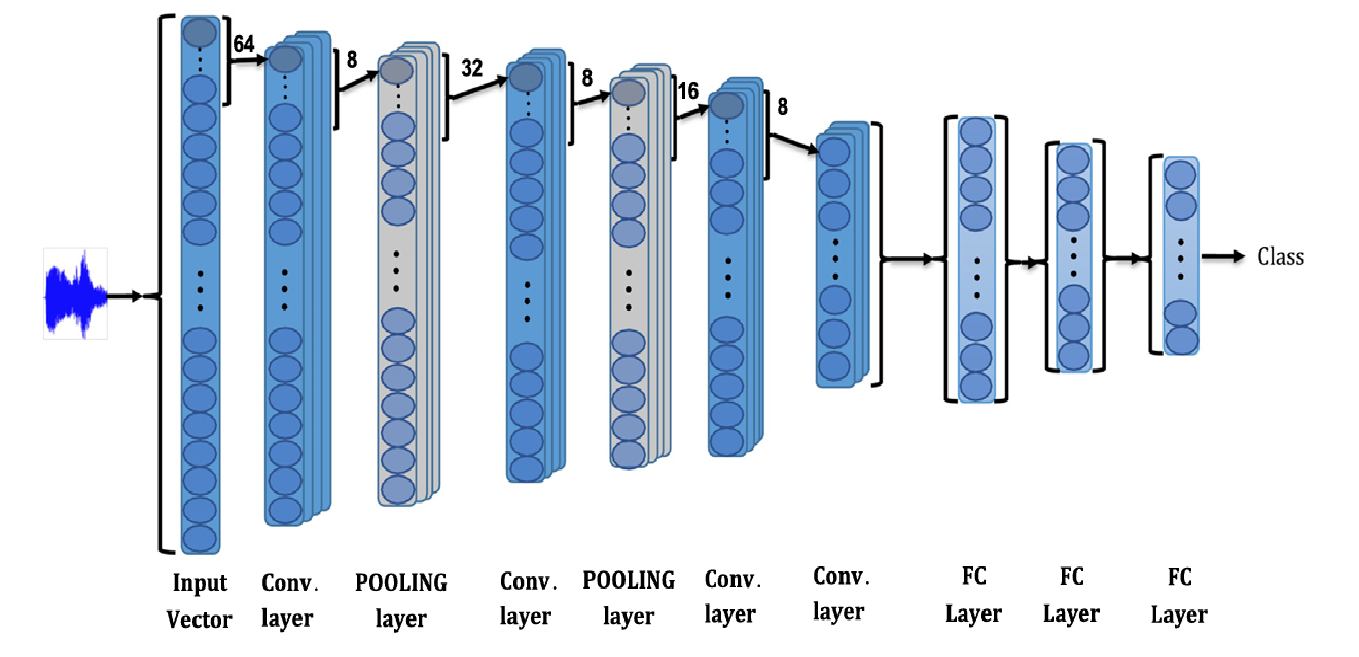

A arquitetura proposta segue o modelo de uma 1D CNN compacta, com um número reduzido de parâmetros, projetada para otimizar o esforço computacional necessário para treinamento, além de minimizar a quantidade de dados necessários para alcançar bons resultados. Essa abordagem é no estudo [[4]](#ref_4), que enfatiza a importância de técnicas como batch normalization e dropout para evitar overfitting e melhorar a generalização da rede.

A arquitetura é composta por quatro camadas convolucionais (Conv1D), intercaladas com camadas de max pooling (MaxPooling1D), seguidas por duas fully connected layers e uma camada de saída (Output Layer) com ativação softmax. Cada camada convolucional é responsável por extrair informações hierárquicas do sinal de entrada, desde características de baixo nível até representações mais abstratas. As primeiras camadas possuem filtros maiores (receptive fields maiores), fornecendo uma visão global do sinal de áudio. Isso é essencial para lidar com a natureza não estacionária dos sinais ambientais.

Após a última camada de pooling, os mapas de características gerados por todas as camadas convolucionais são achatados (Flatten Layer) e servem como entrada para as fully connected layers. A primeira fully connected layer contém 128 neurônios, enquanto a segunda possui 64, ambas utilizando a ativação ReLU (h(x) = max(x, 0)). Para evitar overfitting, um dropout de 25% é aplicado em ambas as camadas. A camada final contém 10 neurônios, correspondendo ao número de classes do problema, com ativação softmax para fornecer a probabilidade de cada classe.

Esta arquitetura evita a necessidade de módulos tradicionais de pré-processamento do sinal, pois a rede é suficientemente poderosa para aprender representações relevantes diretamente do sinal de áudio. Apesar de seu design compacto, ela permite a extração e classificação eficiente de características a partir de gravações de áudio, conforme demonstrado na literatura.

In [15]:
def build_1d_cnn(input_shape, num_classes, learning_rate=0.001, dropout_rate=0.5, optimizer='adam'):
    input_layer = Input(shape=input_shape, name="Input_Waveform")
    
    # First Convolutional Layer
    x = Conv1D(filters=64, kernel_size=16, strides=1, activation='relu', padding='valid', name="Conv1D_1")(input_layer)
    x = BatchNormalization(name="BatchNorm_1")(x)
    x = MaxPooling1D(pool_size=4, strides=4, padding='valid', name="MaxPool_1")(x)
    
    # Second Convolutional Layer
    x = Conv1D(filters=32, kernel_size=8, strides=1, activation='relu', padding='valid', name="Conv1D_2")(x)
    x = BatchNormalization(name="BatchNorm_2")(x)
    x = MaxPooling1D(pool_size=4, strides=4, padding='valid', name="MaxPool_2")(x)
    
    # Third Convolutional Layer
    x = Conv1D(filters=16, kernel_size=4, strides=1, activation='relu', padding='valid', name="Conv1D_3")(x)
    x = BatchNormalization(name="BatchNorm_3")(x)
    
    # Fourth Convolutional Layer
    x = Conv1D(filters=8, kernel_size=4, strides=1, activation='relu', padding='valid', name="Conv1D_4")(x)
    x = BatchNormalization(name="BatchNorm_4")(x)
    x = MaxPooling1D(pool_size=2, strides=2, padding='valid', name="MaxPool_4")(x)
    
    # Flatten and Fully Connected Layers
    x = Flatten(name="Flatten")(x)
    x = Dense(128, activation='relu', name="Dense_128")(x)
    x = Dropout(dropout_rate, name="Dropout_1")(x)
    x = Dense(64, activation='relu', name="Dense_64")(x)
    x = Dropout(dropout_rate, name="Dropout_2")(x)
    
    # Output Layer
    output_layer = Dense(num_classes, activation='softmax', name="Output")(x)
    
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer, name="1D_CNN")
    
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Choose 'adam' or 'sgd'.")
    
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

### Estratégia de Treino - 1D CNN <a name = "cnn_1d_et"></a>
[[voltar a CNN 1D]](#cnn_1d)

Nesta parte do trabalho temos por objetivo determinar quais são os melhores hiperparâmetros, para isso iremos utilizar uma grid search, de modo a gerir da melhor forma os recursos disponiveis, do seguinte modo:

- **Train Fold:** Contém a maior parte dos dados. Usado para treinar o modelo.

- **Validation Fold:** Uma parte separada dos dados. Usada para ajustar hiperparâmetros e monitorar o desempenho durante o trein.

No nosso caso decidimos:

    Usar apenas o fold 2 como validação

    Descartar o test set, nete caso que corresponderia ao fold 1, tendo, portanto sidocompletamente removido do treino e validação.

    Treino limitado aos folds restantes (3-10)
    

Deste modo, iremos utlizar os folds de 3 a 10 exclusivamente para treinoe o fold 2 para validação, sendo atraves deste que avaliamos os resultados, tendo em conta a perda de validação (val_loss) e a acuraccy de validação (val_accuracy) são as métricas usadas para decidir a performance.

#### Hyperparamer Tunning

Assim sendo decidimos avaliar os seguintes hiperparâmetros:

- Batch Size
        
        - 32, 64 
        
- Learning Rate

        - 0.01, 0.001, 0.0001

- Dropout Rate

        - 0.3, 0.5

Deste modo, tal como dissemos previamente iremos realizar one fold validation.

In [ ]:
def one_fold_validation(features, labels, metadata, num_classes, lr, batch_size, dropout_rate, max_epochs=10):
    """
    Perform one-fold validation for a given set of hyperparameters with audio-level aggregation.
    """
    val_fold = 2  # Fold 2 for validation
    train_folds = [3, 4, 5, 6, 7, 8, 9, 10]  # Folds for training

    # Split data
    val_indices = metadata[metadata['fold'] == val_fold].index
    train_indices = metadata[metadata['fold'].isin(train_folds)].index

    X_train = features[train_indices]
    print("LEN X_TRAIN" ,len(X_train))
    y_train = labels[train_indices]
    X_val = features[val_indices]
    y_val = labels[val_indices]
    audio_ids_val = metadata.loc[val_indices, 'spectrogram_file'].values  # Audio IDs for validation set
    print(len(audio_ids_val))

    # Expand dimensions for 1D CNN
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)

    # Build and compile the model
    input_shape = X_train.shape[1:]
    model = build_1d_cnn(
        input_shape=input_shape,
        num_classes=num_classes,
        learning_rate=lr,
        dropout_rate=dropout_rate
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=max_epochs,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
        ],
        verbose=1
    )

    # Save training history
    val_loss = min(history.history['val_loss'])  # Best validation loss
    val_accuracy = max(history.history['val_accuracy'])  # Best validation accuracy

    # Predict window-level classes for validation set
    y_pred_windows = model.predict(X_val).argmax(axis=1)
    print(len(y_pred_windows))

    # Aggregate to audio-level predictions
    audio_predictions = aggregate_predictions(audio_ids=audio_ids_val, y_pred=y_pred_windows, strategy='majority')
    print(len(audio_predictions))

    # Convert audio-level predictions to corresponding true labels
    y_val_audio = [y_val[audio_ids_val == audio_id][0] for audio_id in audio_predictions.keys()]
    y_pred_audio = list(audio_predictions.values())

    # Debug: Check the audio-level aggregation results
    print("Audio-level True Labels:", y_val_audio)
    print("Audio-level Predicted Labels:", y_pred_audio)

    # Evaluate at the audio level
    audio_level_accuracy = accuracy_score(y_val_audio, y_pred_audio)
    print(f"Validation Fold - Audio-Level Accuracy: {audio_level_accuracy * 100:.2f}%")

    # Confusion matrix for audio-level predictions
    conf_matrix = confusion_matrix(y_val_audio, y_pred_audio, labels=range(num_classes))

    # Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(1, num_classes + 1))
    plt.figure(figsize=(8, 8))
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title("Validation Confusion Matrix")
    plt.savefig("validation_confusion_matrix.png")
    plt.show()

    # Create results
    results_df = pd.DataFrame({
        'fold': [val_fold],
        'val_audio_accuracy': [audio_level_accuracy],
        'val_loss': [val_loss]
    })

    return results_df, conf_matrix, audio_level_accuracy, val_loss

In [ ]:
# Hyperparameters
learning_rate = 0.0001
batch_size = 32
dropout_rate = 0.6
max_epochs = 10

# Perform one-fold validation
results_df, conf_matrix, val_accuracy, val_loss = one_fold_validation(
    features=X_frames,
    labels=y_frames,
    metadata=windowing_metadata,
    num_classes=10,
    lr=learning_rate,
    batch_size=batch_size,
    dropout_rate=dropout_rate,
    max_epochs=max_epochs
)

# Print results
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

# Save the confusion matrix
np.savetxt("validation_confusion_matrix.csv", conf_matrix, delimiter=",", fmt="%d")

# Save the results
results_df.to_csv("one_fold_validation_results.csv", index=False)


LEN X_TRAIN 1000128
124805
Epoch 1/10
31254/31254 ━━━━━━━━━━━━━━━━━━━━ 656s 20ms/step - accuracy: 0.1931 - loss: 2.4263 - val_accuracy: 0.3008 - val_loss: 1.9941 - learning_rate: 1.0000e-04
Epoch 2/10
31254/31254 ━━━━━━━━━━━━━━━━━━━━ 633s 20ms/step - accuracy: 0.3586 - loss: 1.8536 - val_accuracy: 0.2970 - val_loss: 2.2187 - learning_rate: 1.0000e-04
Epoch 3/10
31254/31254 ━━━━━━━━━━━━━━━━━━━━ 649s 21ms/step - accuracy: 0.3899 - loss: 1.7623 - val_accuracy: 0.2129 - val_loss: 2.0802 - learning_rate: 1.0000e-04
Epoch 4/10
31254/31254 ━━━━━━━━━━━━━━━━━━━━ 661s 21ms/step - accuracy: 0.4100 - loss: 1.7135 - val_accuracy: 0.3464 - val_loss: 1.8845 - learning_rate: 5.0000e-05
Epoch 5/10
31254/31254 ━━━━━━━━━━━━━━━━━━━━ 693s 22ms/step - accuracy: 0.4157 - loss: 1.6962 - val_accuracy: 0.3555 - val_loss: 1.9482 - learning_rate: 5.0000e-05
Epoch 6/10
31254/31254 ━━━━━━━━━━━━━━━━━━━━ 683s 22ms/step - accuracy: 0.4208 - loss: 1.6839 - val_accuracy: 0.3488 - val_loss: 1.9889 - learning_rate: 5.0000

No one fold cross validation que eventualmente seria usado para hyperparameter tunning cada epoch levou-nos cerca de 15 minutos a ser completada. Eventualmente, no 10-fold cross validation o tempo que seria necessário para avaliar o modelo seria excecionalmente grande o que  tornaria o processo inviável em termos de tempo e recursos computacionais. Esta limitação destaca a necessidade de otimizar o formato de entrada, como a utilização de espectrogramas em vez de áudio bruto, ou de explorar abordagens alternativas que reduzam significativamente a complexidade computacional sem comprometer a qualidade dos resultados.

**Qual deverá ser a nova abordagem?**

O uso de uma CNN 1D com o áudio bruto (raw audio) como entrada gera uma enorme quantidade de frames devido à taxa de amostragem elevada (22.050 Hz). No nosso caso, o modelo processa 1.250.698 frames, cada um com 1.102 valores, resultando em um input massivo que leva 15 minutos por época para treinar. Este tempo elevado limita a experimentação e a eficiência durante a fase de desenvolvimento.

Ao utilizar espectrogramas como entrada, é possível reduzir significativamente o tamanho do input, pois:

- O espectrograma transforma o áudio no domínio do tempo para o domínio da frequência, condensando informações temporais em representações visuais compactas.

- Um espectrograma típico pode ter dimensões de cerca de 128 x 128 (frequências x tempo), dependendo da configuração, em comparação com as dimensões atuais de 1250698 x 1102 no formato 1D.

Isto permite que uma **CNN 2D** processe os dados mais rapidamente e com menor consumo de memória. Por estes motivos decidimos abandonar o uso do modelo CNN 1D e passar a desenvovler e explorar o CNN 2D.

**Porque não alterar o tipo de input do CNN 1D?**

Algumas estratégias para reduzir a complexidade do modelo 1D (como aumentar o tamanho das janelas ou o hop size, reduzir a taxa de amostragem ou utilizar técnicas de downsampling) são menos eficazes, porque:

    Aumentar o tamanho das janelas ou o hop size reduz o número de frames, mas perde detalhes temporais cruciais, afetando    negativamente a performance do modelo.

    Reduzir a taxa de amostragem pode comprometer a qualidade do sinal e eliminar informações importantes, especialmente         para sons de alta frequência.

    Downsampling de frames após a extração diminui a memória necessária, mas prejudica a resolução temporal, dificultando a detecção de eventos curtos no áudio.

Essas soluções tentam lidar com o problema sem alterar o modelo subjacente, mas não atacam a causa raiz: o formato de entrada não é eficiente para a tarefa.

**Conclusão**

    Assim, a transição para uma CNN 2D com espectrogramas como entrada parece-nos o melhor caminho a adotar, pois melhora a eficiência computacional, reduz o tempo de treino, e aproveita melhor a informação acústica do áudio. Estratégias alternativas para mitigar o problema do input massivo no formato 1D são menos eficazes e podem degradar a qualidade dos dados, comprometendo a performance do modelo.

## CNN 2D <a name = "cnn_2d"></a>
[[voltar ao índice]](#indice)

Uma CNN 2D é uma rede neuronal profunda usada para processar dados bidimensionais, como espectrogramas, tratados como imagens. O modelo analisa padrões temporais e frequenciais nos espectrogramas, identificando características locais para tarefas como de classificação de sons.

Uma CNN 2D procura identificar padrões locais nas regiões do espectrograma, como harmónicos, transições de frequência e outros elementos importantes, o que torna este tipo de rede particularmente eficiente em tarefas relacionadas com análise de sinais acústicos.

### Pré-Processamento - 2D CNN <a name = "cnn_2d_pp"></a>
[[voltar a CNN 2D]](#cnn_2d)

Como sabemos, previamente, no [Pré-Processamento dos Dados](#ppd), já foram tidos em conta alguns cuidados que devemos ter nos áudios, como a sua duração e uniformização, entre outros. Por este motivo, consideramos que o dataset se encontra pronto para adaptarmos os dados para o formato necessário para o modelo CNN 2D. Assim sendo, decidimos fazer o seguinte:

- Geração de Espectogramas Log-Mel:

Para cada áudio será gerado um espectograma log-mel como é feito em alguns estudos como [[5]](#ref_5), [[6]](#ref_6) e [[7]](#ref_7).

        128 bandas de Mel

Inicialmente tinhamos decidido utilizar 60 bandas de Mel, de acordo com o estudo [[6]](#ref_6), no entanto, após vários testes, concluimos que de um modo geral a performance do modelo era superior quando utilizadas 128 bandas de Mel, pelo que optamos por esse valor.

- Normalização dos valores:

Iremos depois escalar os valores do espectograma para o intervalo [0,1] de modo a facilitar a aprendizagem da rede, sendo esta uma etapa essencial para evitar gradientes desiquilibrados e melhorar a estabilidade durante o treino.

       Vamos identificar o menor e o maior valor do espectograma (após a transformação logarítmica) e aplicaremos a fórmula:
                               Normalized Value = (Value - Min) / (Max - Min)

Assim sendo, seguem as funções necessárias para executar o pré-processamento especificado.

[[skip_code]](#sc_2)

In [2]:
# Parâmetros para gerar espectrogramas log-mel
sr = 22050  # Taxa de amostragem
n_mels = 128  # Número de bandas de Mel

In [3]:
# Função para processar e normalizar espectrogramas
def process_and_normalize_audio(audio_path, sr = 22050, n_mels = 128):
    # Carregar o áudio
    y, sr = librosa.load(audio_path, sr=sr)
    # Gerar espectrograma log-mel
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    # Normalizar para o intervalo [0, 1]
    normalized_spec = (log_mel_spec - np.min(log_mel_spec)) / (np.max(log_mel_spec) - np.min(log_mel_spec))
    return normalized_spec

In [4]:
# Função para salvar espectrogramas
def save_spectrogram(spectrogram, file_name, output_directory):
    output_path = os.path.join(output_directory, file_name)
    np.save(output_path, spectrogram)

In [5]:
# Função para visualizar espectrogramas
def visualize_spectrogram(spectrogram, title="Normalized Log-Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.colorbar(format='%+2.0f')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [6]:
def process_urbansound8k(audio_base_path, metadata_df, output_directory, sr=22050, n_mels=128):
    """
    Processa os arquivos UrbanSound8K para gerar espectrogramas log-mel normalizados e 
    salva os metadados organizados por folds.
    
    Parâmetros:
    - audio_base_path: Caminho base onde estão localizados os diretórios fold1, fold2, etc.
    - metadata_df: DataFrame contendo informações sobre os arquivos de áudio.
    - output_directory: Caminho onde os espectrogramas e metadados serão salvos.
    - sr, n_fft, hop_length, n_mels: Parâmetros para geração do espectrograma log-mel.
    """
    os.makedirs(output_directory, exist_ok=True)

    spectrogram_metadata = []  # Para armazenar informações sobre os espectrogramas gerados

    for index, row in metadata_df.iterrows():
        try:
            # Obter informações do arquivo
            fold = row['fold']
            class_id = row['classID']
            file_name = row['slice_file_name']
            audio_path = os.path.join(audio_base_path, f"fold{fold}", file_name)

            # Processar e normalizar o espectrograma
            normalized_spec = process_and_normalize_audio(audio_path, sr=sr, n_mels=n_mels)

            # Nome do arquivo de saída para o espectrograma
            spectrogram_file_name = f"{file_name.split('.')[0]}"
            save_spectrogram(normalized_spec, spectrogram_file_name, output_directory)

            # Adicionar informações aos metadados
            spectrogram_metadata.append({
                "spectrogram_file": spectrogram_file_name,
                "fold": fold,
                "class_id": class_id,
                "original_audio_path": audio_path,
                "path": os.path.join(output_directory, spectrogram_file_name+".npy")
            })

            # Visualizar os primeiros 3 espectrogramas gerados
            if len(spectrogram_metadata) <= 3:
                visualize_spectrogram(normalized_spec, title=f"Spectrogram: {spectrogram_file_name} (Fold {fold})")

        except Exception as e:
            print(f"Erro ao processar {file_name}: {e}")

    # Criar um DataFrame com os metadados dos espectrogramas
    spectrogram_metadata_df = pd.DataFrame(spectrogram_metadata)

    # Salvar o arquivo de metadados
    metadata_output_path = os.path.join(output_directory, "spectrogram_metadata.csv")
    spectrogram_metadata_df.to_csv(metadata_output_path, index=False)

    print(f"Total de espectrogramas processados: {len(spectrogram_metadata)}")
    print(f"Metadados salvos em: {metadata_output_path}")

    return spectrogram_metadata_df

In [7]:
df_metadata = pd.read_csv("UrbanSound8K.csv")
# Diretório onde os áudios estão localizados (ajuste conforme necessário)
output_directory = r"C:\Users\User\Desktop\UNI3\AC_II\Projeto\UrbanSound8K\pp_cnn_2d_128"
# Para realizar este teste, deve alterar o caminho para o que tem no seu computador
audios_dir = r"C:\Users\User\Desktop\UNI3\AC_II\Projeto\UrbanSound8K\audio_processed"

[fim de skip]<a name = "sc_2"></a>

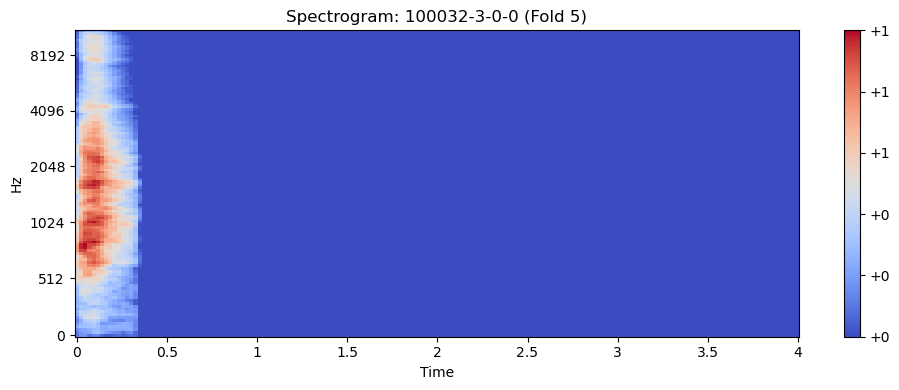

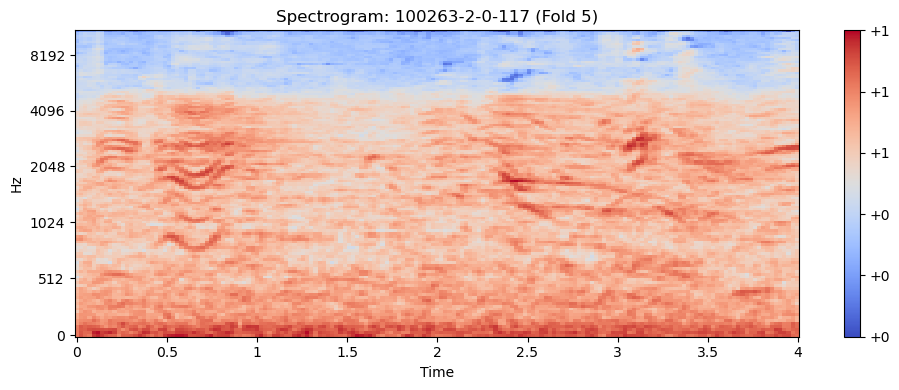

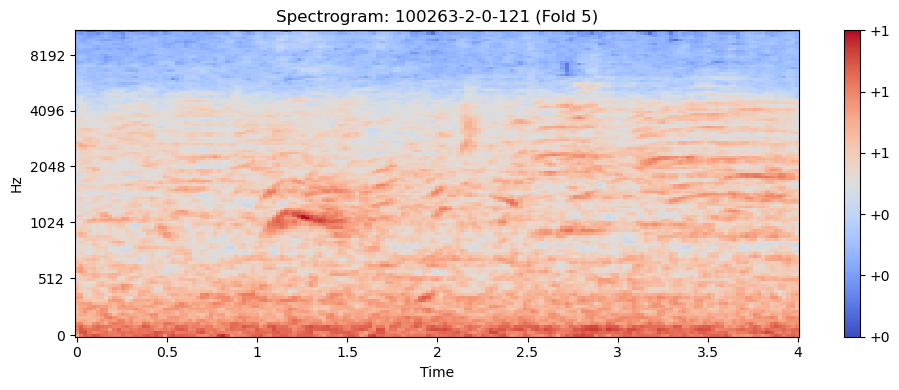

Total de espectrogramas processados: 8732
Metadados salvos em: C:\Users\User\Desktop\UNI3\AC_II\Projeto\UrbanSound8K\pp_cnn_2d_128\spectrogram_metadata_norm.csv


In [8]:
spectrogram_metadata_df = process_urbansound8k(
    audio_base_path = audios_dir,
    metadata_df = df_metadata,
    output_directory = output_directory
)

Agora que as alterações foram realizadas com sucesso, vamos escolher um dos espectogramas e ver se está dentro dos padrões espectaveis.

In [9]:
def load_and_visualize_spectrogram(npy_file_path, sr=22050, title="Loaded Spectrogram"):
    # Carregar o espectrograma
    spectrogram = np.load(npy_file_path)
    
    # Mostrar informações sobre o espectrograma
    print(f"Shape do espectrograma carregado: {spectrogram.shape}")
    print(f"Valores mínimo e máximo: {spectrogram.min()}, {spectrogram.max()}")
    
    # Visualizar o espectrograma
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.colorbar(format='%+2.0f')
    plt.title(title)
    plt.tight_layout()
    plt.show()

Shape do espectrograma carregado: (128, 173)
Valores mínimo e máximo: 0.0, 1.0


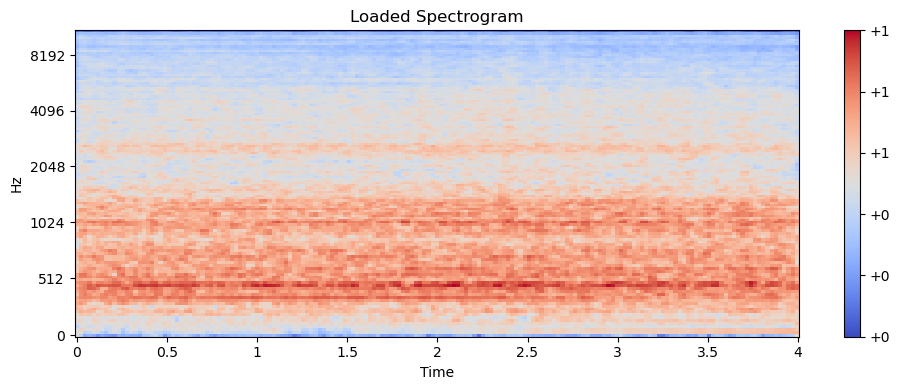

In [10]:
# Exemplo de uso
load_and_visualize_spectrogram(r"C:\Users\User\Desktop\UNI3\AC_II\Projeto\UrbanSound8K\pp_cnn_2d_128\518-4-0-2.npy")

Concluimos que sim.

### Arquitetura do Modelo - 2D CNN <a name = "cnn_2d_am"></a>
[[voltar a CNN 2D]](#cnn_2d)

O nosso objetivo é que a CNN 2D criada seja capaz de:

- Extrair padrões locais de tempo e frequência nos espectrogramas.
- Aprender representações hierárquicas progressivamente mais abstratas ao longo das camadas.
- Reduzir dimensionalidade com pooling enquanto preserva informações relevantes.
- Classificar as entradas nas classes-alvo.

De modo a alcançar esse objetivo e com base nos estudos decidimos definir a arquitetura do seguinte modo:

**Entrada do Modelo**

- Dimensões:

        Os espectrogramas tem dimensões fixas, como (128, 173, 1):

        128: Número de bandas de Mel (frequência).
        173: Número de frames temporais (largura da "imagem").
        1: Canal único, já que os espectrogramas são representações em tons de cinza.

**Camadas Convolucionais**

- Número de camadas:

        Iremos usar 3 camadas.

Inspirado em Massoudi (2021) [[5]](#ref_5) e [[7]](#ref_7), que utilizaram 4 camadas convolucionais, e Piczak (2015) [[6]](#ref_6), que usou 2 camadas convolucionais, optamos por um meio-termo, usando portanto 3 camadas convolucionais.

- Filtros e tamanhos:

        Primeira camada: 32 filtros, kernel (3x3).
        Segunda camada: 64 filtros, kernel (3x3).
        Terceira camada: 128 filtros, kernel (3x3).
        
Vários estudos aumentam progressivamente o número de filtros, tal como decidimos fazer. Para além disso usamos o tamanho de kernel sugerido em [[5]](#ref_5).

**Pooling**

    Iremos usar Polling após cada camada concolucional
        Max-pooling (2x2)

Será usado para reduzir a dimensionalidade, inspirado no estudo [[7]](#ref_7) para escolher o valor 2X2, contudo todos os estudos sugerem o uso de Max-pooling após cada camada convolucional.

**Dropout**

        Aplicaremos dropout nas camadas intermediárias, com taxa 0.4 entre camadas convolucionais e aumentaremos esse valor nas camadas densas, passando este a ser 0.5 para a primeira e 0.6 para a segunda.


O uso de Dropout também foi inspirado em diversos estudos, sendo que inicialmente começamos com valores mais baixos como 0.3, no entanto com o objetivo de evitar overfitting e melhorar a generalização, fomos alterando os valores, acabando por utilizar os descritos.

**Flatten**


Todos os estudos encontrados utilizam uma camada flatten para converter os mapas de características extraídos em um vetor unidimensional entre as camadas convolucionais e as camadas densamente conectadas.

**Camadas Fully Connected**

        Após as convoluções, usaremos camadas densas para consolidar as caracteristicas extraidas:
                Primeira camada: 256 neurônios com ReLU
                Segunda camada: 128 neurônios com ReLu
                Camada de saída: 10 neurônios (correspondentes às classes) com softmax 
                
A decisão de quantas camadas densas usar e o número de neurónios foi feita a partir do estudo [[7]](#ref_7), que usa exatamente as mesmas camadas densas.

**Função de Ativação**

        Usaremos ReLU em todas as camadas convolucionais e densas, exceto na camada de saída que será softmax
        
Esta decisão é tomada em todos os estudos.

In [37]:
def model_cnn_2d():
    model = Sequential()
    
    model.add(Input(shape = (128,173,1)))
    
    # Convolução 1
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    # Convolução 2
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    # Convolução 3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    # Flatten para camada totalmente conectada
    model.add(Flatten())
    
    # Densa 1
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    # Densa 2
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.6))
    
    # Saída
    model.add(Dense(10, activation='softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Instanciar o modelo
model = model_cnn_2d()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 171, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 85, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 83, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 41, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 41, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 39, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 14, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 34048)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,716,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,843,402 (33.73 MB)

 Trainable params: 8,843,402 (33.73 MB)

 Non-trainable params: 0 (0.00 B)

### Estratégia de Treino - 2D CNN <a name = "cnn_2d_et"></a>
[[voltar a CNN 2D]](#cnn_2d)

**Função de Perda (Loss Function)**

        Escolha: Categorial Crossentropy
        
Decidimos utilizar Crossentropy, pois, estamos a lidar com um problema de classificação multi-classe (10 classes) e esta função é padrão para tarefas onde as saídas são probabilidades (softmax).

**Otimizador**

        Escolha: Adam

O Adam combina as vantagens de RMSProp e Momentum, adaptando a taxa de aprendizagem para cada parâmetro. Ele é amplamente usado e mostrou ser eficiente em CNNs para dados similares.

**Hiperparâmetros de Treinamento**

Os valores aqui escolhidos foram testados mais que uma vez e variados, sendo que os obtiveram melhor resultado são os aqui escolhidos.

- Learning rate

        Inicialmente será definido como 0.001

Apesar de termos feitos diversos testes com diferentes valores como 0.001, 0.0005 e 0.0001, o que aprrsentou melhores resultados foi 0.001.

- Mini-batch Size:

        Tamanho 32

É um valor intermediário que equilibra o desempenho computacional e estabilidade de treinamento. Também testamos com 16 e 64, mas não obtivemos grandes alterações.

- Número de Épocas:

        Inicialmente 50

Será combinado com Early Stopping.

**Data Augmentation**

Para aumentar a robustez do modelo e diminuir o overffiting, aplicamos técnicas de aumento de dados nos espectrogramas:

        Deslocamento Hoizontal
        Deslocamento Vertical
        Zoom Aleatório (até 20%)
        Inversão Hprizontal

Isto é feito dinamicamente durante o treinamento, usando ImageDataGenerator da biblioteca Keras.

**Monitoramento**

- Early Stopping: Monitora a métrica de validação (e.g., acurácia ou perda).

- Learning Rate Scheduler: Reduz a taxa de aprendizado caso a métrica de validação pare de melhorar.

In [38]:
lr_scheduler = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, min_lr = 1e-6)

In [39]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, min_delta = 1e-3, restore_best_weights = True)

In [40]:
callbacks = [lr_scheduler, early_stop]

Neste código iremos fazer os testes e variar os valores escolhidos, tal que apenas iremos treinar os folds 3 a 10, usando o fold 2 como validação e excluindo por completo o fold 1.

In [54]:
df_cnn_2d = pd.read_csv("spectrogram_metadata.csv")

Esta função tem como objetivo carregar corretmente os dados para os fornecer ao modelo.

In [55]:
def load_data(df):
    # Lista para armazenar espectrogramas e rótulos
    X = []
    y = []

    # Loop para carregar os espectrogramas e rótulos
    for _, row in df.iterrows():
        spectrogram = np.load(row['path'])  # Carregar o espectrograma como matriz 2D
        spectrogram = np.expand_dims(spectrogram, axis=-1)  # Adicionar eixo de canal (altura, largura, 1)
        X.append(spectrogram)
        y.append(row['class_id'])  # Rótulo (classe)

    # Converter listas para arrays NumPy
    X = np.array(X)
    y = np.array(y)
    
    # Converter rótulos para one-hot encoding
    y = to_categorical(y, num_classes = 10)
    return X,y

In [58]:
def train(model_fn, metadata, load, num_classes, callbacks):
    val_fold = 2
    train_fold = [f for f in [3,4,5,6,7,8,9,10]]
    print(f"\n--- Validation Fold {val_fold} and Train Folds {train_fold} ---")

    # Split data
    train_df = metadata[metadata['fold'].isin(train_fold)]
    val_df = metadata[metadata['fold'] == val_fold]
    
    X_train, y_train = load(train_df)
    X_val, y_val = load(val_df)

    # Build and train model
    input_shape = X_train.shape[1:]

    datagen = ImageDataGenerator(
        width_shift_range = 0.1,  # Deslocar horizontalmente
        height_shift_range = 0.1,  # Deslocar verticalmente
        zoom_range = 0.2,  # Zoom aleatório
        horizontal_flip = True  # Inverter horizontalmente
    )

    datagen.fit(X_train)


    model = model_fn()

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=32),
        validation_data = (X_val, y_val),
        epochs = 50,
        callbacks = callbacks,
        verbose = 1
    )

    # Avaliação no conjunto de validação
    val_loss = min(history.history['val_loss'])  # Melhor perda de validação registrada
    val_accuracy = max(history.history['val_accuracy'])  # Melhor precisão de validação registrada

    # Matriz de confusão para validação
    y_pred_val = model.predict(X_val).argmax(axis = 1)
    conf_matrix = confusion_matrix(y_val, y_pred_val, labels = range(num_classes))
    
    print("\n--- Final 1 Fold Results ---")
    print(f"Mean Audio-Level Accuracy: {mean_accuracy:.4f}")
    print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")
    disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [1,2,3,4,5,6,7,8,9,10])
    disp.plot(cmap = plt.cm.Blues)
    plt.title(f"Cumulative Confusion Matrix")
    plt.show()  # Fecha a figura para evitar exibi-la

    return results_df, conf_matrix, val_accuracy, val_loss

In [61]:
results_df, overall_matrix, fold_matrices, mean_accuracy, std_accuracy, fold_histories = train(
    model_fn = model_cnn_2d,
    metadata = df_cnn_2d,
    load = load_data,
    num_classes = 10,
    callbacks = callbacks
)


--- Validation Fold 2 and Train Folds [3, 4, 5, 6, 7, 8, 9, 10] ---
Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 80s 357ms/step - accuracy: 0.1299 - loss: 2.3663 - val_accuracy: 0.2207 - val_loss: 2.0897 - learning_rate: 0.0010
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 76s 348ms/step - accuracy: 0.2311 - loss: 2.0268 - val_accuracy: 0.2984 - val_loss: 2.0129 - learning_rate: 0.0010
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 75s 345ms/step - accuracy: 0.2799 - loss: 1.9125 - val_accuracy: 0.3412 - val_loss: 1.8058 - learning_rate: 0.0010
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 72s 328ms/step - accuracy: 0.2977 - loss: 1.8312 - val_accuracy: 0.3750 - val_loss: 1.6060 - learning_rate: 0.0010
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 69s 317ms/step - accuracy: 0.3445 - loss: 1.7279 - val_accuracy: 0.4088 - val_loss: 1.4958 - learning_rate: 0.0010
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 69s 317ms/step - accuracy: 0.3927 - loss: 1.6540 - val_accuracy: 0.3468 - val_loss: 1.4981 - learning_rate: 0.0010
E

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

### Teste dos Modelos - 2D CNN <a name = "cnn_2d_tm"></a>
[[voltar a CNN 2D]](#cnn_2d)

Agora que definimos o modelo e os seus hiperparâmetros estamos prontos para testar o modelo, isto é utilizar 10-fold corss validation tal que em cada fold um conjunto de dados é usado como testes, outro como validação e o resto como treino. Isto será feito seguinte o seguinte critério:

        Fold de Teste = i
        Fold de Validação = i+1
        Fold de Treino = todos os folds - i- (i+1)

    (caso o fold de teste seja o 10, o de validação será o 1)

Deste modo iremos ter algo do tipo:

    Teste = 1, Validação = 2, Treino = [3,4,5,6,7,8,9,10]
    ou
    Teste = 2, Validação = 3, Treino = [1,4,5,6,7,8,9,10]
    etc

In [8]:
def evaluate_model_with_metrics(model_fn, metadata, load, num_classes, folds, callbacks):
    """
    Perform cross-validation and collect metrics for evaluation at the audio level.
    """
    results = []
    overall_conf_matrix = np.zeros((num_classes, num_classes), dtype=int)
    fold_accuracies = []
    fold_histories = []
    fold_confusion_matrices = []  # Store confusion matrices for each fold

    validation_folds = {1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 10, 10: 1}

    for test_fold in folds:
        val_fold = validation_folds[test_fold]
        train_fold = [f for f in folds if f != test_fold and f != val_fold]
        print(f"\n--- Processing Fold {test_fold} with Validation Fold {val_fold} and Train Folds {train_fold} ---")

        # Split data
        train_df = metadata[metadata['fold'].isin(train_fold)]
        val_df = metadata[metadata['fold'] == val_fold]
        test_df = metadata[metadata['fold'] == test_fold]
        
        X_train, y_train = load(train_df)
        X_val, y_val = load(val_df)
        X_test, y_test = load(test_df)
    
        # Build and train model
        input_shape = X_train.shape[1:]
        
        datagen = ImageDataGenerator(
            width_shift_range=0.1,  # Deslocar horizontalmente
            height_shift_range=0.1,  # Deslocar verticalmente
            zoom_range=0.2,  # Zoom aleatório
            horizontal_flip=True  # Inverter horizontalmente
        )
        
        datagen.fit(X_train)
        
        
        model = model_fn()

        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=32),
            validation_data = (X_val, y_val),
            epochs = 50,
            callbacks = callbacks,
            verbose = 1
        )

        # Save training history
        fold_histories.append(history.history)

        y_pred = model.predict(X_test).argmax(axis = 1)
        y_test = np.argmax(y_test, axis = 1)

        # Evaluate at the audio level
        fold_accuracy = accuracy_score(y_test, y_pred)
        fold_accuracies.append(fold_accuracy)
        print(f"Fold {test_fold} - Audio-Level Accuracy: {fold_accuracy * 100:.2f}%")

        # Generate and save confusion matrix for this fold
        fold_conf_matrix = confusion_matrix(y_test, y_pred, labels = range(num_classes))
        fold_confusion_matrices.append(fold_conf_matrix)

        # Update overall confusion matrix
        overall_conf_matrix += fold_conf_matrix

        # Save results
        results.append({'fold': test_fold, 'accuracy': fold_accuracy})

    # Compute final metrics
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)

    print("\n--- Final Cross-Validation Results ---")
    print(f"Mean Audio-Level Accuracy: {mean_accuracy:.4f}")
    print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

    results_df = pd.DataFrame(results)
    results_df.to_csv("cross_validation_results.csv", index=False)

    return results_df, overall_conf_matrix, fold_confusion_matrices, mean_accuracy, std_accuracy, fold_histories

In [9]:
results_df, overall_matrix, fold_matrices, mean_accuracy, std_accuracy, fold_histories = evaluate_model_with_metrics(
    model_fn = model_cnn_2d,
    metadata = df_cnn_2d,
    load = load_data,
    num_classes = 10,
    folds = [1,2,3,4,5,6,7,8,9,10],
    callbacks = callbacks
)


--- Processing Fold 1 with Validation Fold 2 and Train Folds [3, 4, 5, 6, 7, 8, 9, 10] ---
Epoch 1/50


C:\Users\User\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 59s 261ms/step - accuracy: 0.1285 - loss: 2.3155 - val_accuracy: 0.1295 - val_loss: 2.2563 - learning_rate: 0.0010
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 58s 268ms/step - accuracy: 0.2169 - loss: 2.0994 - val_accuracy: 0.1543 - val_loss: 2.2070 - learning_rate: 0.0010
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 59s 268ms/step - accuracy: 0.2495 - loss: 1.9830 - val_accuracy: 0.2286 - val_loss: 2.0504 - learning_rate: 0.0010
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 58s 267ms/step - accuracy: 0.2841 - loss: 1.8834 - val_accuracy: 0.2185 - val_loss: 1.9665 - learning_rate: 0.0010
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 58s 266ms/step - accuracy: 0.2954 - loss: 1.8403 - val_accuracy: 0.4054 - val_loss: 1.6258 - learning_rate: 0.0010
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 58s 264ms/step - accuracy: 0.3325 - loss: 1.7473 - val_accuracy: 0.5214 - val_loss: 1.5199 - learning_rate: 0.0010
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 58s 265ms/step - accuracy: 0.3634 - loss:

C:\Users\User\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


217/217 ━━━━━━━━━━━━━━━━━━━━ 59s 264ms/step - accuracy: 0.1398 - loss: 2.3291 - val_accuracy: 0.2324 - val_loss: 2.0416 - learning_rate: 0.0010
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 57s 264ms/step - accuracy: 0.2148 - loss: 2.0386 - val_accuracy: 0.2486 - val_loss: 2.0010 - learning_rate: 0.0010
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 59s 272ms/step - accuracy: 0.2543 - loss: 1.9196 - val_accuracy: 0.2346 - val_loss: 2.0386 - learning_rate: 0.0010
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 57s 263ms/step - accuracy: 0.3050 - loss: 1.8447 - val_accuracy: 0.2822 - val_loss: 1.8814 - learning_rate: 0.0010
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 57s 262ms/step - accuracy: 0.3280 - loss: 1.7720 - val_accuracy: 0.4022 - val_loss: 1.6498 - learning_rate: 0.0010
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 57s 262ms/step - accuracy: 0.3652 - loss: 1.6815 - val_accuracy: 0.3308 - val_loss: 1.5958 - learning_rate: 0.0010
Epoch 7/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 57s 262ms/step - accuracy: 0.3819 - loss:

C:\Users\User\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


214/214 ━━━━━━━━━━━━━━━━━━━━ 58s 264ms/step - accuracy: 0.1289 - loss: 2.3190 - val_accuracy: 0.2020 - val_loss: 2.1949 - learning_rate: 0.0010
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 56s 262ms/step - accuracy: 0.2296 - loss: 2.0846 - val_accuracy: 0.2525 - val_loss: 2.0617 - learning_rate: 0.0010
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 56s 261ms/step - accuracy: 0.2694 - loss: 1.9301 - val_accuracy: 0.2556 - val_loss: 1.9779 - learning_rate: 0.0010
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 58s 272ms/step - accuracy: 0.2879 - loss: 1.8409 - val_accuracy: 0.3131 - val_loss: 1.8497 - learning_rate: 0.0010
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 56s 263ms/step - accuracy: 0.3093 - loss: 1.7858 - val_accuracy: 0.3141 - val_loss: 1.7994 - learning_rate: 0.0010
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 56s 263ms/step - accuracy: 0.3471 - loss: 1.6959 - val_accuracy: 0.3172 - val_loss: 1.7619 - learning_rate: 0.0010
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 56s 263ms/step - accuracy: 0.3695 - loss:

C:\Users\User\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


213/213 ━━━━━━━━━━━━━━━━━━━━ 61s 278ms/step - accuracy: 0.1371 - loss: 2.3438 - val_accuracy: 0.1934 - val_loss: 2.1624 - learning_rate: 0.0010
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 57s 268ms/step - accuracy: 0.2231 - loss: 2.0064 - val_accuracy: 0.2297 - val_loss: 2.0052 - learning_rate: 0.0010
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 56s 262ms/step - accuracy: 0.2766 - loss: 1.8975 - val_accuracy: 0.2650 - val_loss: 1.8822 - learning_rate: 0.0010
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 56s 263ms/step - accuracy: 0.2813 - loss: 1.8451 - val_accuracy: 0.2927 - val_loss: 1.7840 - learning_rate: 0.0010
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 56s 263ms/step - accuracy: 0.3280 - loss: 1.7526 - val_accuracy: 0.3515 - val_loss: 1.6644 - learning_rate: 0.0010
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 56s 262ms/step - accuracy: 0.3748 - loss: 1.6543 - val_accuracy: 0.4017 - val_loss: 1.4930 - learning_rate: 0.0010
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 57s 266ms/step - accuracy: 0.3991 - loss:

C:\Users\User\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 59s 264ms/step - accuracy: 0.1267 - loss: 2.3215 - val_accuracy: 0.2260 - val_loss: 2.1664 - learning_rate: 0.0010
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 57s 262ms/step - accuracy: 0.2333 - loss: 2.0236 - val_accuracy: 0.2746 - val_loss: 1.9739 - learning_rate: 0.0010
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 57s 262ms/step - accuracy: 0.2782 - loss: 1.9075 - val_accuracy: 0.3147 - val_loss: 1.8077 - learning_rate: 0.0010
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 59s 271ms/step - accuracy: 0.3255 - loss: 1.7893 - val_accuracy: 0.3147 - val_loss: 1.6867 - learning_rate: 0.0010
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 58s 263ms/step - accuracy: 0.3660 - loss: 1.7009 - val_accuracy: 0.3657 - val_loss: 1.5777 - learning_rate: 0.0010
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 57s 261ms/step - accuracy: 0.4060 - loss: 1.6198 - val_accuracy: 0.4265 - val_loss: 1.4809 - learning_rate: 0.0010
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 57s 263ms/step - accuracy: 0.4184 - loss:

C:\Users\User\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


221/221 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - accuracy: 0.1506 - loss: 2.2717 - val_accuracy: 0.2279 - val_loss: 2.0599 - learning_rate: 0.0010
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 59s 265ms/step - accuracy: 0.2305 - loss: 2.0084 - val_accuracy: 0.2578 - val_loss: 1.9339 - learning_rate: 0.0010
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step - accuracy: 0.2931 - loss: 1.8622 - val_accuracy: 0.3234 - val_loss: 1.9035 - learning_rate: 0.0010
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step - accuracy: 0.3192 - loss: 1.7845 - val_accuracy: 0.3353 - val_loss: 1.7935 - learning_rate: 0.0010
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 58s 264ms/step - accuracy: 0.3357 - loss: 1.7229 - val_accuracy: 0.3652 - val_loss: 1.5681 - learning_rate: 0.0010
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step - accuracy: 0.3932 - loss: 1.5993 - val_accuracy: 0.3675 - val_loss: 1.6751 - learning_rate: 0.0010
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step - accuracy: 0.4049 - loss:

C:\Users\User\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


222/222 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - accuracy: 0.1308 - loss: 2.3575 - val_accuracy: 0.2618 - val_loss: 2.0421 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step - accuracy: 0.2197 - loss: 2.0428 - val_accuracy: 0.3164 - val_loss: 1.8895 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step - accuracy: 0.2431 - loss: 1.9460 - val_accuracy: 0.3983 - val_loss: 1.8156 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 261ms/step - accuracy: 0.3085 - loss: 1.8331 - val_accuracy: 0.3536 - val_loss: 1.7253 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 260ms/step - accuracy: 0.3261 - loss: 1.7723 - val_accuracy: 0.3859 - val_loss: 1.5500 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 59s 264ms/step - accuracy: 0.3652 - loss: 1.6827 - val_accuracy: 0.5050 - val_loss: 1.5240 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 59s 265ms/step - accuracy: 0.4128 - loss:

C:\Users\User\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


223/223 ━━━━━━━━━━━━━━━━━━━━ 60s 263ms/step - accuracy: 0.1263 - loss: 2.3533 - val_accuracy: 0.2243 - val_loss: 2.0652 - learning_rate: 0.0010
Epoch 2/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 58s 260ms/step - accuracy: 0.2207 - loss: 2.0519 - val_accuracy: 0.2488 - val_loss: 1.8736 - learning_rate: 0.0010
Epoch 3/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 59s 264ms/step - accuracy: 0.2659 - loss: 1.9357 - val_accuracy: 0.2145 - val_loss: 1.8222 - learning_rate: 0.0010
Epoch 4/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 59s 262ms/step - accuracy: 0.3108 - loss: 1.8213 - val_accuracy: 0.2708 - val_loss: 1.7249 - learning_rate: 0.0010
Epoch 5/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 59s 262ms/step - accuracy: 0.3499 - loss: 1.7041 - val_accuracy: 0.3088 - val_loss: 1.6506 - learning_rate: 0.0010
Epoch 6/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step - accuracy: 0.3904 - loss: 1.6263 - val_accuracy: 0.4510 - val_loss: 1.4664 - learning_rate: 0.0010
Epoch 7/50
223/223 ━━━━━━━━━━━━━━━━━━━━ 59s 263ms/step - accuracy: 0.4243 - loss:

C:\Users\User\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


222/222 ━━━━━━━━━━━━━━━━━━━━ 62s 275ms/step - accuracy: 0.1204 - loss: 2.3859 - val_accuracy: 0.2736 - val_loss: 2.0685 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 261ms/step - accuracy: 0.2303 - loss: 2.0413 - val_accuracy: 0.3345 - val_loss: 1.9116 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 262ms/step - accuracy: 0.2746 - loss: 1.9114 - val_accuracy: 0.2939 - val_loss: 1.7809 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 59s 263ms/step - accuracy: 0.3187 - loss: 1.8041 - val_accuracy: 0.3716 - val_loss: 1.6723 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 59s 265ms/step - accuracy: 0.3722 - loss: 1.6752 - val_accuracy: 0.4671 - val_loss: 1.5638 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 263ms/step - accuracy: 0.4094 - loss: 1.5888 - val_accuracy: 0.4839 - val_loss: 1.4385 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 58s 261ms/step - accuracy: 0.4372 - loss:

C:\Users\User\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


220/220 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - accuracy: 0.1403 - loss: 2.3103 - val_accuracy: 0.1707 - val_loss: 2.1401 - learning_rate: 0.0010
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 59s 266ms/step - accuracy: 0.2149 - loss: 2.0514 - val_accuracy: 0.2119 - val_loss: 1.9557 - learning_rate: 0.0010
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 58s 265ms/step - accuracy: 0.2769 - loss: 1.9233 - val_accuracy: 0.3058 - val_loss: 1.7538 - learning_rate: 0.0010
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 58s 265ms/step - accuracy: 0.3002 - loss: 1.8688 - val_accuracy: 0.4021 - val_loss: 1.6461 - learning_rate: 0.0010
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 59s 266ms/step - accuracy: 0.3263 - loss: 1.7743 - val_accuracy: 0.4616 - val_loss: 1.5502 - learning_rate: 0.0010
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 58s 264ms/step - accuracy: 0.3537 - loss: 1.7001 - val_accuracy: 0.4227 - val_loss: 1.4705 - learning_rate: 0.0010
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 58s 264ms/step - accuracy: 0.3837 - loss:

Agora que obtivemos os resultados, podemos passar para a análise dos mesmos:

In [25]:
def visualize_metrics(results_df, overall_confusion_matrix, fold_confusion_matrices, mean_accuracy, std_accuracy, fold_histories, num_classes):
    """
    Visualize evaluation metrics including confusion matrices and learning curves.
    """
    # Accuracy per fold
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['fold'], results_df['accuracy'], marker='o', label="Fold Accuracy")
    plt.axhline(y=mean_accuracy, color='r', linestyle='--', label=f"Mean Accuracy ({mean_accuracy:.4f})")
    plt.fill_between(
        results_df['fold'], mean_accuracy - std_accuracy, mean_accuracy + std_accuracy,
        color='r', alpha=0.2, label=f"± Std Dev ({std_accuracy:.4f})"
    )
    plt.title("Fold-wise Accuracy")
    plt.xlabel("Fold")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig("fold_accuracy.png")
    plt.show()
    
    # Combined matrix
    disp = ConfusionMatrixDisplay(confusion_matrix = overall_matrix, display_labels = [1,2,3,4,5,6,7,8,9,10])
    disp.plot(cmap = plt.cm.Blues)

    # Salvar a imagem
    plt.savefig("cumulative_confusion_matrix.png", dpi = 300, bbox_inches = "tight")  # Salva como PNG
    plt.title(f"Cumulative Confusion Matrix")
    plt.show()  # Fecha a figura para evitar exibi-la


    # Training and validation curves
    for i, history in enumerate(fold_histories):
        plt.figure(figsize=(12, 5))
        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(history['loss'], label='Training Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title(f"Fold {i+1} - Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        # Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history['accuracy'], label='Training Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title(f"Fold {i+1} - Training and Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(f"learning_curves_fold_{i+1}.png")
        plt.show()
        
        disp = ConfusionMatrixDisplay(confusion_matrix = fold_confusion_matrices[i], display_labels = [1,2,3,4,5,6,7,8,9,10])
        disp.plot(cmap = plt.cm.Blues)

        # Salvar a imagem
        plt.savefig(f"confusion_matrix_folg{i+1}.png", dpi = 300, bbox_inches = "tight")  # Salva como PNG
        plt.title(f"Fold {i+1} - Confusion Matrix")
        plt.show()  # Fecha a figura para evitar exibi-la

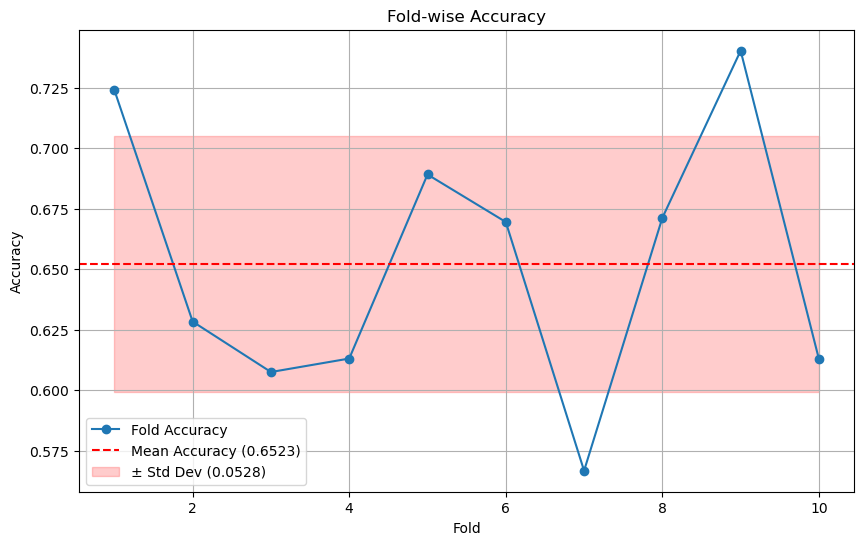

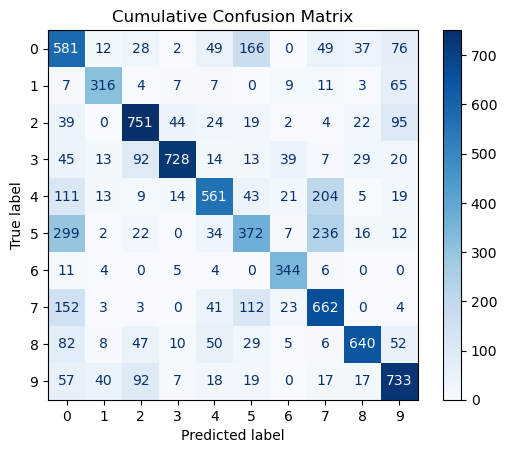

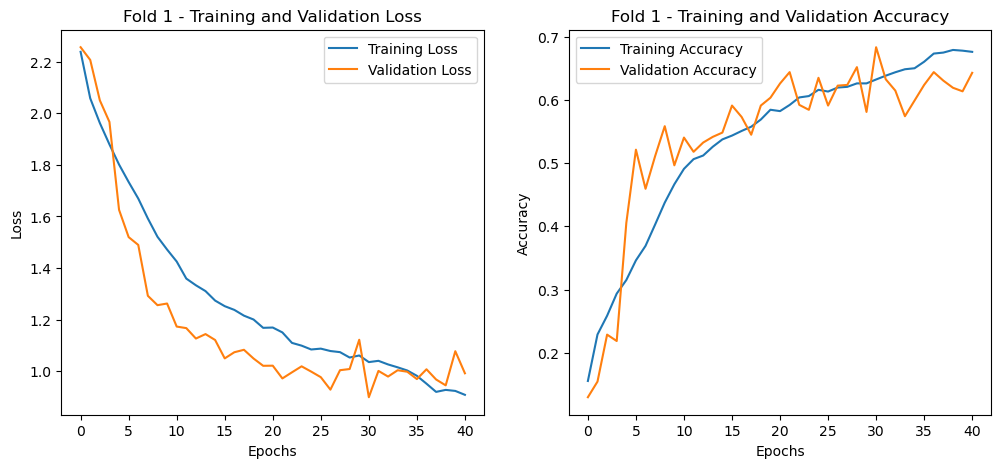

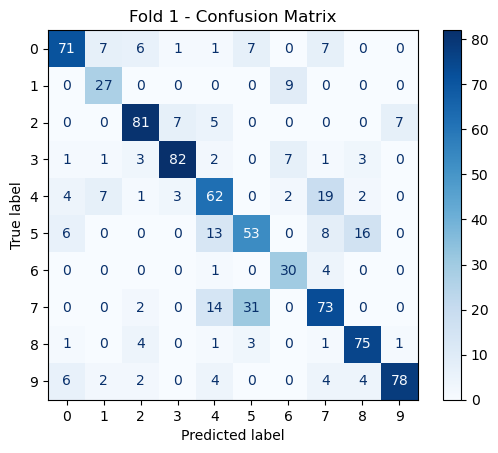

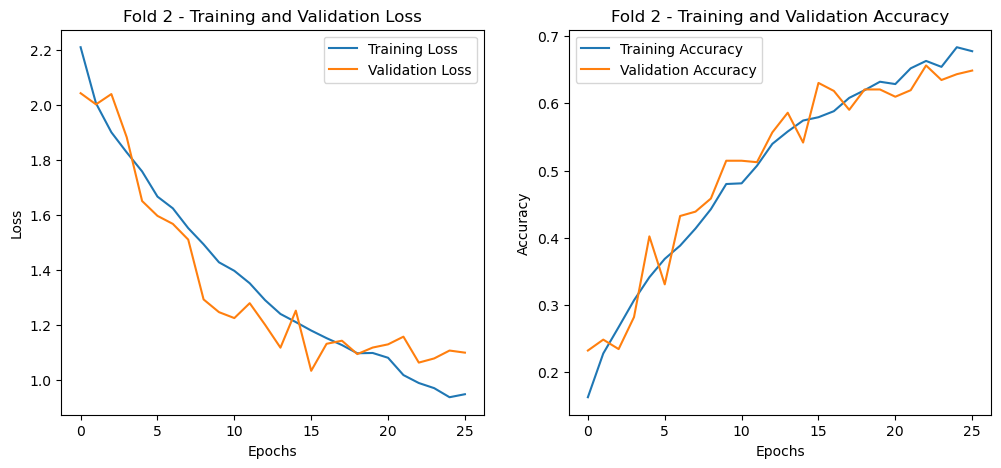

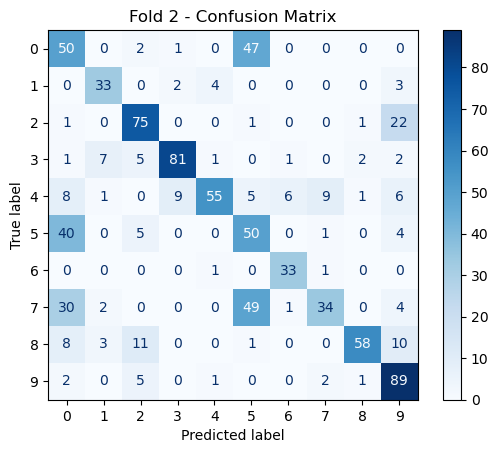

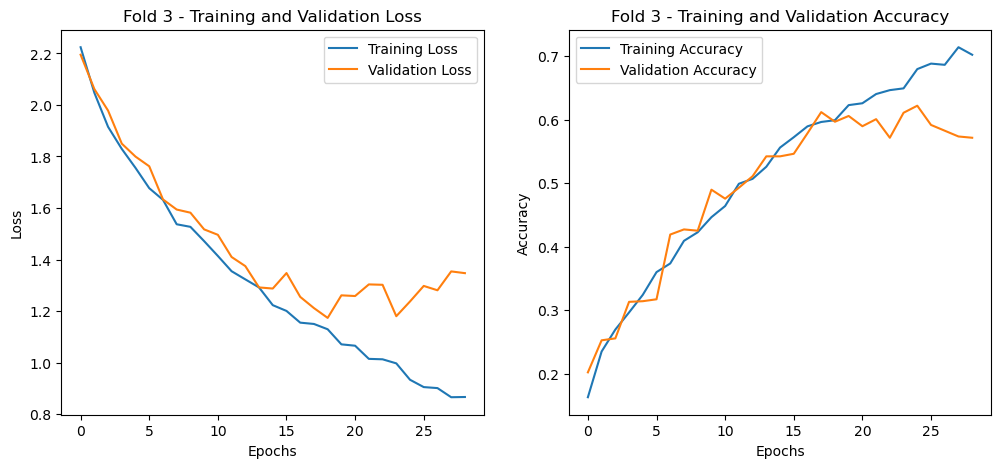

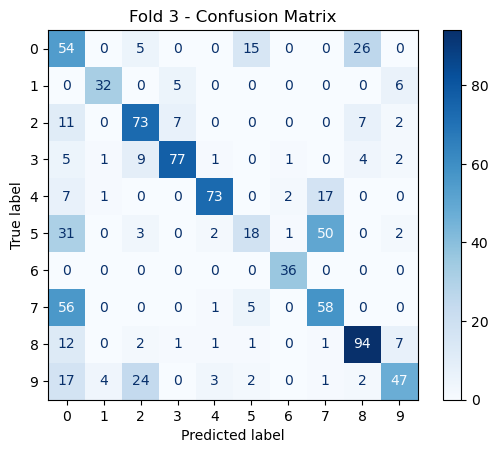

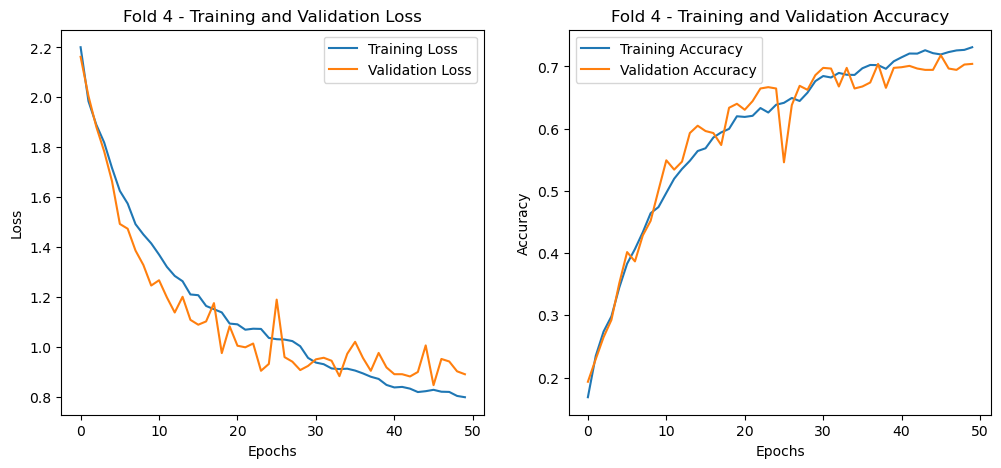

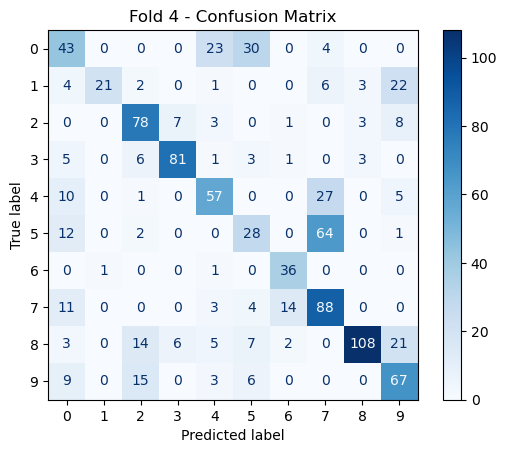

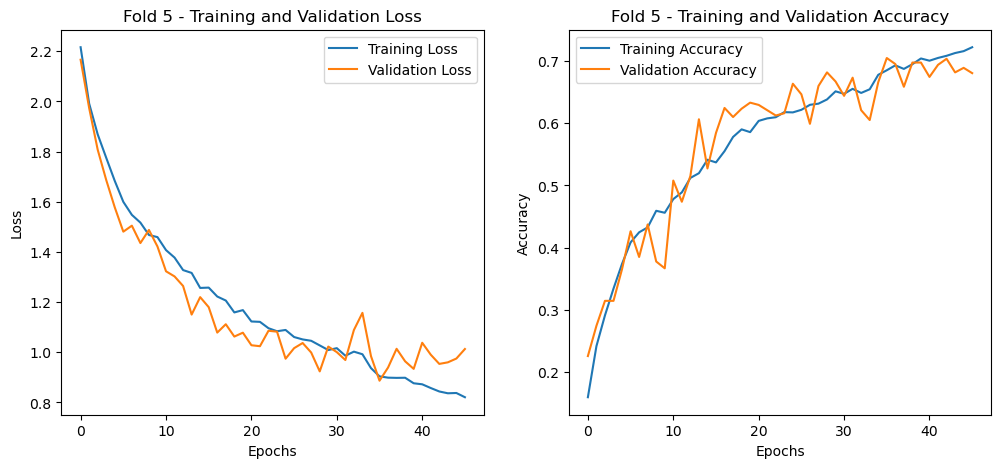

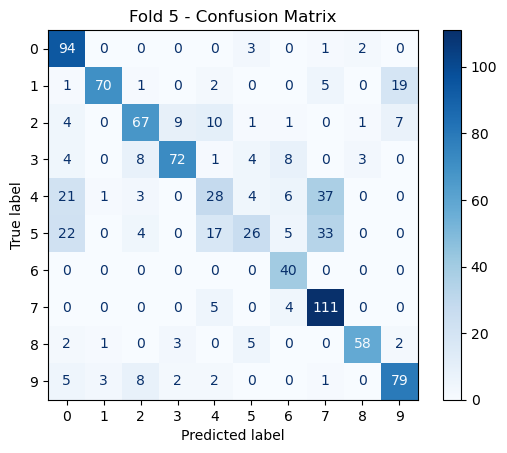

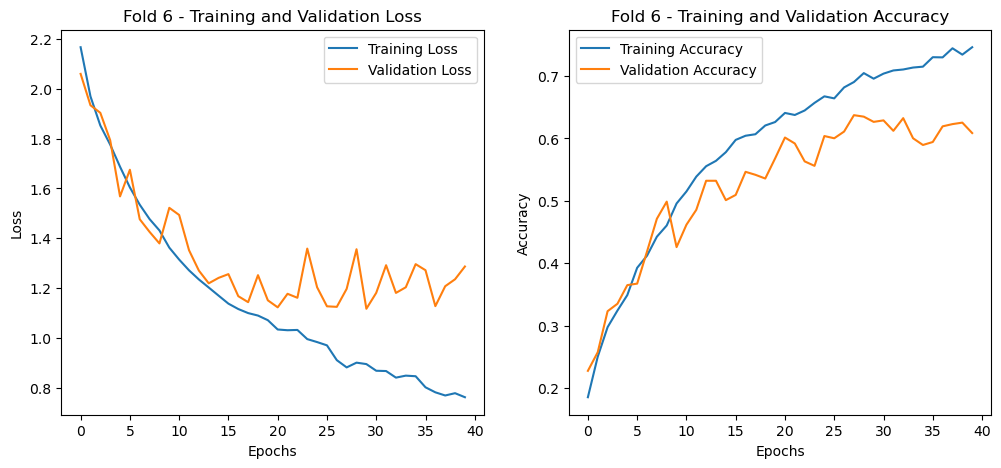

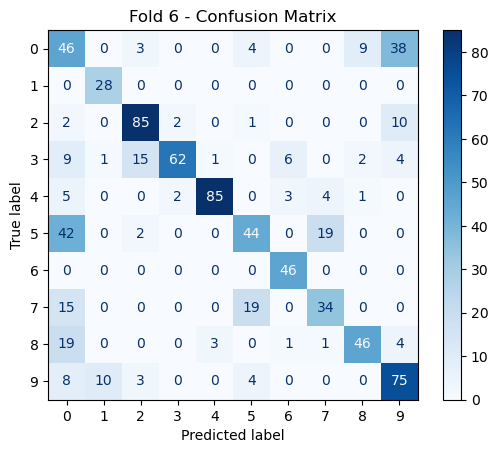

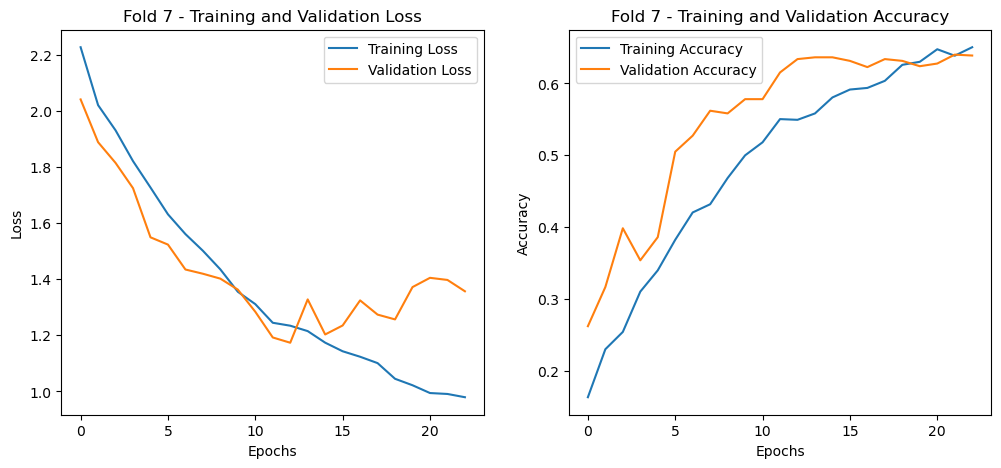

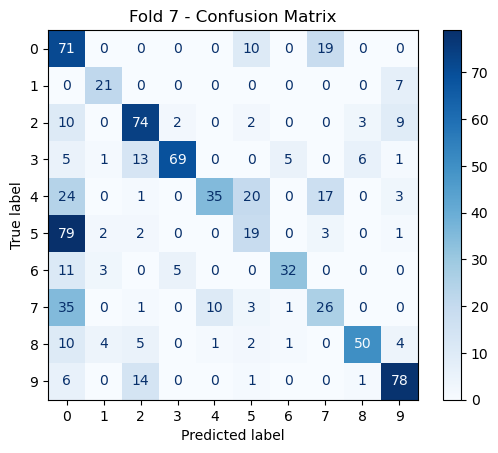

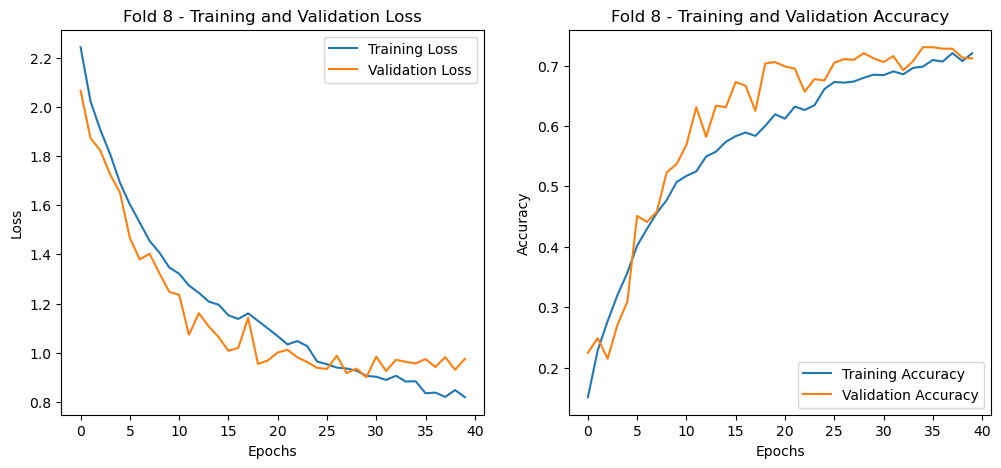

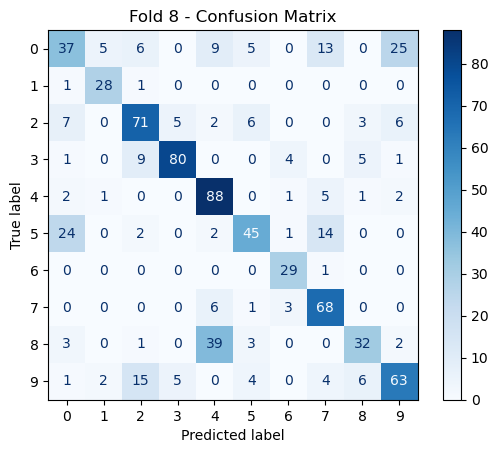

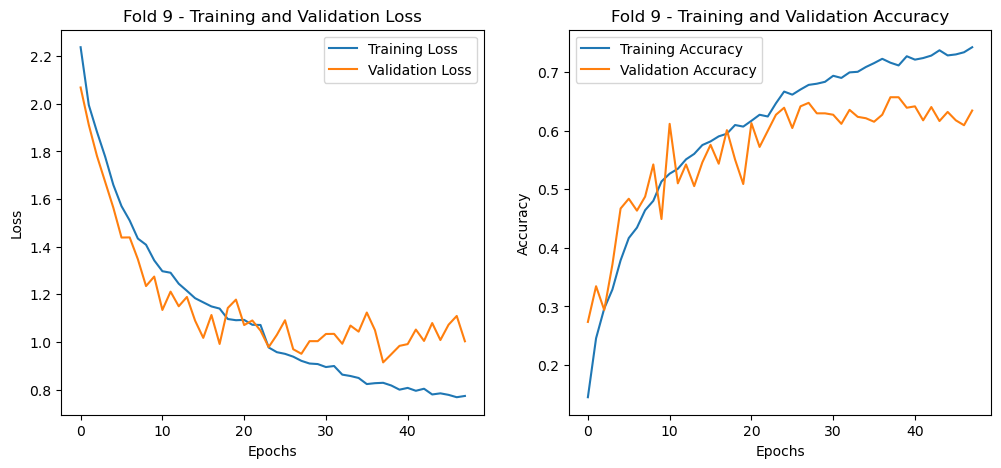

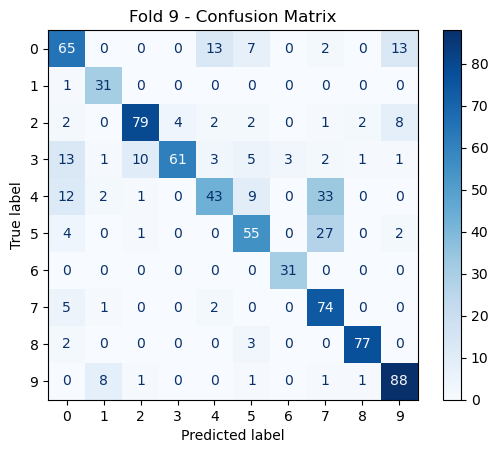

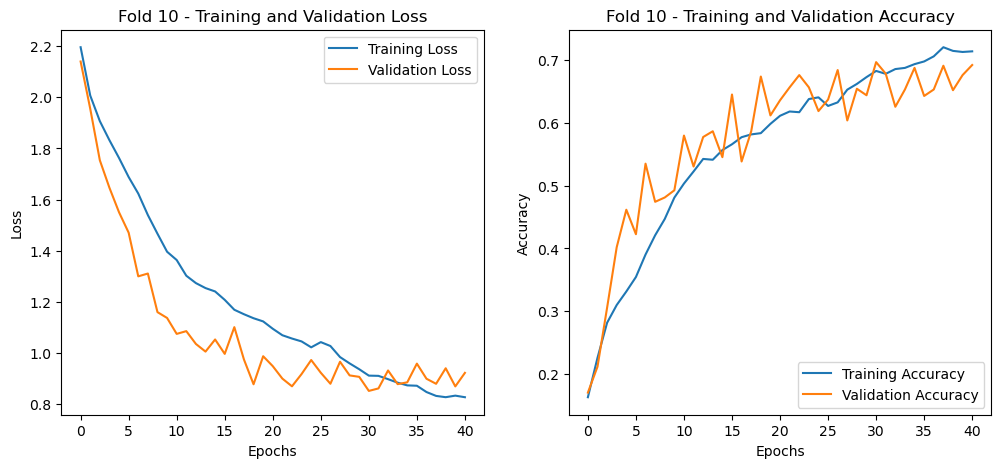

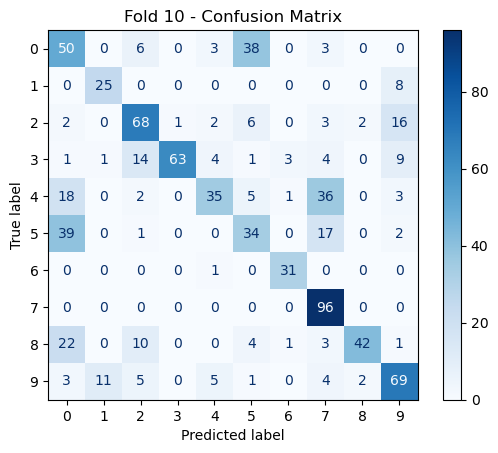

In [30]:
visualize_metrics(
    results_df = results_df,
    overall_confusion_matrix = overall_matrix,
    fold_confusion_matrices = fold_matrices,
    mean_accuracy = mean_accuracy,
    std_accuracy = std_accuracy,
    fold_histories = fold_histories,
    num_classes=10
)

### Análise de Resultados <a name = "cnn_2d_ar"></a>
[[voltar a Teste dos Modelos - 2D CNN]](#cnn_2d_tm)

- **Curvas de Aprendizagem**

De um modo geral é possivel perceber que a maioria dos folds apresenta uma convergência adequada, tal que a **'Training Loss' diminui** ao longo do tempo de um modo consistente. Para além disso a **Validation Loss** mantem-se razoavelmente próxima da 'Training Loss' o que sugere que **não há overffiting** severo na maioria dos casos. A **accuracy** tanto no treino como na validação, mostra um comportamento que seria esperado, aumentando ao longo das épocas e estabilizando mais perto do final.

No entanto, é possivel perceber que alguns folds não tiveram tão bom desempenho como o fold 6 e o fold 9, que apresentam maior instabilidade na curva de validação com flutuações na perda de precisão, o que pode indicar alguma dificuldade em generalizar para determinados subconjuntos dos dados

- **Matrizes de Confusão**

Conseguimos perceber que algumas classes como a 2, a 3 e a 9 são facilmente classificadas, tendo uma taxa de acerto bastante elevada. No entanto também há algumas classes problemáticas, como a 0 (air_conditioner), a 4 (drilling), a 5 (engine_idling) e a 7 (jackhammer) que se confundem um pouco entre si, o que pode acontecer uma vez que estes se tratam todos de sons contínuos. Contudo,  de entre estas classes algumas são mais problemáticas entre elas que outras, por exemplo air_conditioner (0) VS engine_idling (5) confundem-se mais que qualquer outro par de classes.

- **Conclusão**

De um modo geral o modelo demonstra ser razoavelmente robusto, com um desempenho médio consistente entre os diferentes folds.

## RNN <a name = "rnn"></a>
[[voltar ao índice]](#indice)

### Pré-Processamento - RNN <a name = "rnn_pp"></a>
[[voltar a RNN]](#rnn)

Para este modelo optamos por utliziar Mel-Frequency Cepstral Coefficients (MFCC) como features, sendo estas extraídas a partir dos dados originais. Para além disso consideramos segmentos de 0.25 segundos com um hop size de 0.125 segundos, sendo que estes valores foram adaptados dos utilizados no seguinte estudo [[8]](#ref_8).

Assim cada ficheiro de audio é dividido em 33 segmentos, tal que cada um destes segmentos representa o audio num certo momento.

Função que extrai os MFCC de um ficheiro de audio específico, cria os 33 segmentos, cada um deles com as suas MFCC representativas.

In [3]:
def extract_MFCC_features_RNN(audio_path, sample_rate=22050, segment_duration=0.25, hop_duration=0.125, n_mcff=60):
    # carrega o audio original de 4 sec
    audio, sr= librosa.load(path=audio_path, sr=sample_rate)

    # calcular os parametros para obter os mcff pro segmento em vez de para o audio completo
    n_fft= int(segment_duration*sample_rate)
    hop_length=int(hop_duration*sample_rate)

    # calcular os mcff por segmento
    mfcc=librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mcff, n_fft=n_fft, hop_length=hop_length)

    # transformar numa linha para mais fácil utilização
    mfcc_features=mfcc.T

    # retorna um numpy.ndarray
    return mfcc_features

In [4]:
def get_mfcc_dataset_RNN(path="./"):
    columns = ['fold', 'classID', 'audio_name'] + [f'mfcc_{i}' for i in range(60)]
    df_metadata=pd.read_csv('./data/metadata/UrbanSound8K.csv')

    data=[]
    for fold in range(1,11):
        folder_name="fold"+str(fold)
        folder_path=os.path.join(audio_dir,folder_name)

        if(os.path.exists(folder_path)):
            files_in_folder=os.listdir(folder_path)
            for file in files_in_folder:
                if(file.endswith('.wav')):
                    audio_path=os.path.join(folder_path,file)
                    segments_features=extract_MFCC_features_RNN(audio_path=audio_path)
                    df_metadata_row=df_metadata[df_metadata['slice_file_name']==file]

                    if( not df_metadata_row.empty):
                        class_id=df_metadata_row.iloc[0]['classID']
                        fold=df_metadata_row.iloc[0]['fold']
                        audio_name=df_metadata_row.iloc[0]['slice_file_name']
                        for segment_features in segments_features:
                            row_data={
                                'fold':fold,
                                'classID':class_id,
                                'audio_name':audio_name,
                            }
                            row_data.update({f"mfcc_{i}":feature for i,feature in enumerate(segment_features)})
                            data.append(row_data)

    df_data=pd.DataFrame(data,columns=columns)
    dataset_name=os.path.join(path,"mfcc_for_RNN.csv")
    df_data.to_csv(dataset_name)

In [57]:
get_mfcc_dataset_RNN()

Uma vez extraidos os dados, passamos para a leitura do csv criado:

In [3]:
df_mfcc = pd.read_csv('mfcc_for_RNN.csv')

### Arquitetura do Modelo - RNN <a name = "rnn_am"></a>
[[voltar a RNN]](#rnn)

A arquitetura do nosso modelo RNN é baseada no estudo [[8]](#ref_8).

A ideia da arquitetura é utilizar um modelo auxiliar que vai criar embeddings para RNN utilizar como features, esses embeddings vão dizer a probabilidade de um audio pertencer a uma certa metaclasse. Decimos utilizar MLP para criar os embeddings, para manter a simplicidade do modelo em geral. 

Os pontos chave do modelo são:
  - **Layers GRU bidirecionais**
  - **Regularização forte** / **Dropout** para tentar mitigar o overfitting
  - **LossFunction:** CategoricalCrossentropy uma vez que se trata de uma classificação multi-classe
  - **EarlyStoping** e **ReduceLROnPlateau** mais uma vez para tentar reduzir o overfitting

As metaclasses que consideramos foram retiradas da "taxonomy" do UrbanSound8K dataset [[2]](#ref_2)-

In [4]:
def get_meta_classes(df_labels):
    # Labels originais
    original_labels = {
    0: 'air_conditioner',
    1: 'car_horn',
    2: 'children_playing',
    3: 'dog_bark',
    4: 'drilling',
    5: 'engine_idling',
    6: 'gun_shot',
    7: 'jackhammer',
    8: 'siren',
    9: 'street_music'
    }

    # Mapping para as metaclasses
    label_mapping = {
    'dog_bark': 0,
    'children_playing': 1,
    'car_horn': 2,
    'air_conditioner': 2,#3, ---more_complex_metaclass--
    'street_music': 3,#4,  ---more_complex_metaclass--
    'gun_shot': 2,#3,  ---more_complex_metaclass--
    'siren': 2,#3,  ---more_complex_metaclass--
    'engine_idling': 2,  
    'jackhammer': 2,#5,  ---more_complex_metaclass--
    'drilling': 2,#5,  ---more_complex_metaclass--
    }

    df_labels= df_labels.map(lambda x: original_labels[x])
    df_labels= df_labels.map(label_mapping)

    return df_labels

Aqui criamos o nosso modelo auxiliar, como tinhamos dito é um MLP bastante simples que possui apenas uma hidden layer, este modelo é treinado com uma fold separada do dataset para impedir dataleakage, para além disso, parte dessa fold é utilizada como validação para verificar se o modelo não está a dar overfitting, que não é o caso uma vez que a diferença entre a accuracy do treino e de validação está entre 2% e 5%. Embora no estudo pelo qual nos guiamos [[8]](#ref_8) a utlização de embeddings tenha tido um impacto positivo. Nos nossos testes isso não aconteceu, o que achamos que pode levar a isto é o facto de que o dataset utilizado no estudo possui audios em ambientes muito mais controlados, ao contrário dos audios do nosso dataset que pretende capturar os sons nos seus ambientes reais (possuindo muito mais noise) o que pode levar a que o MLP tenha dificuldades em criar embeddings que são representativos das classes. 

In [5]:
def build_LTE_model(input_dim, embedding_dim, num_meta_classes):
    tf.keras.backend.clear_session()
    inputs = Input(shape=(input_dim,), name='Input_layer')
    embeddings = Dense(embedding_dim, activation='relu', name='Embedding_layer')(inputs)
    outputs = Dense(num_meta_classes, activation='softmax', name='Output_layer')(embeddings)
    model = Model(inputs=inputs, outputs=outputs, name="LTE_Model")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Explicando mais em específico a arquitetura do RNN em si, nós utlizamos um RNN com 2 GRU layers, o motivo de usarmos GRU layers em vez de LSTM é pois são mais efecientes computacionalmente no treino, tal como o estudo [[8]](#ref_8) indica, estas layers são bidirecionais de modo que os segmentos "passados" assim como "futuros" de um audio sejam usados para compreender o contexto antes de dar uma classificação. O modelo em si não possui uma função de ativiação softmax final (o que nos permite mais facilmente implementar deepfool), no entanto durante o treino para cálculo dos novos pesos e predição de classes uma funão de ativação softmax é utilizada sobre o outputs raws para obtermos os dados probabilistícos das classes

In [6]:
def create_model(input_dim, hidden_dim, output_dim, num_layers, dropout_rate = 0.5):
    tf.keras.backend.clear_session()
    inputs = tf.keras.Input(shape = (None, input_dim))  # Define the input shape
    x = inputs
    for i in range(num_layers):
        x = tf.keras.layers.Bidirectional(
            tf.keras.layers.GRU(
                hidden_dim, 
                return_sequences = (i < num_layers - 1), 
                kernel_regularizer = tf.keras.regularizers.l2(1e-2),
            )
        )(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(output_dim ,kernel_regularizer=tf.keras.regularizers.l2(1e-2))(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy'],
    )
    return model

### Estratégia de Treino - RNN <a name = "rnn_et"></a>
[[voltar a RNN]](#rnn)

**Hyperparemeter tunning**

De modo a obter os hiperparametros 'ideiais', realizamos uma grid search dos parámetros que consideramos mais relevantes. Esta escolha foi feita tendo em consideração que estamos a usar earlystop e a reduzir dinâmicamente o learning rate. Por este motivo, não é necessário procurar pelo número ótimo de epochs tal como a escolha do learning rate não é tão relevante. Para além disso consideramos o número de layers a utlizar, 2, devido a testes manuais que vão de encontro ao que o estudo [[8]](#ref_8) considerou como sendo a melhor complexidade para o modelo.

**Nota:** Esta procura demora bastante tempo a correr cerca de 2h, por isso aconcelhamos a utlizar os valores encontrados a não ser que se realizem mudanças drásticas na arquitetura.

In [ ]:
num_layers_list=[2]
hidden_dims_list=[128,256,512]
rnn_patience_list=[1,5,10]
dropout_rates_list=[0,0.3,0.5]
rnn_epoch_list=[50]
rnn_batch_list=[64,256]

lte_epoch_list=[100]

max_accuracy=-1
max_parameters={}

from sklearn.metrics import confusion_matrix

for num_layer in num_layers_list:
    for hidden_dim_ in hidden_dims_list:
        for pat in rnn_patience_list:
            for dpr in dropout_rates_list:
                for epo_rnn in rnn_epoch_list:
                    for bat_rnn in rnn_batch_list:
                        for epo_lte in lte_epoch_list:
                            #---------------------------------------------------------------------------------------------------------------#

                            input_dim_lte=60
                            embedding_dim=8
                            num_meta_classes=6
                            train_lte=df_mfcc[df_mfcc['fold']== 1]
                            x_train_lte=train_lte.iloc[:,4:]
                            y_train_lte=train_lte.iloc[:,2]

                            test_rnn=df_mfcc[df_mfcc['fold']== 2]
                            x_test_rnn=test_rnn.iloc[:,4:]
                            y_test_rnn=test_rnn.iloc[:,2]

                            y_train_lte=get_meta_classes(y_train_lte).astype('int64')
                            y_train_lte_one_hot=tf.keras.utils.to_categorical(y_train_lte,num_classes=num_meta_classes)

                            #---------------------------------------------------------------------------------------------------------------#

                            # Criar e treinar o modelo LTE

                            LTE_model= build_LTE_model(input_dim=input_dim_lte, embedding_dim=embedding_dim, num_meta_classes=num_meta_classes)
                            print("Trainning LTE")
                            LTE_model.fit(x_train_lte, y_train_lte_one_hot, epochs=epo_lte, batch_size=128, validation_split=0.2,callbacks=[
                                EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True),
                                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
                            ])

                            embedding_model= tf.keras.models.Model(inputs=LTE_model.input, outputs=LTE_model.layers[1].output)

                            #---------------------------------------------------------------------------------------------------------------#

                            # Preparar o dataset de treino

                            train_rnn=df_mfcc[~df_mfcc['fold'].isin([1, 2])]
                            df_files_names=pd.DataFrame(train_rnn['audio_name'],columns=['audio_name'])
                            x_train_rnn=train_rnn.iloc[:,4:]
                            y_train_rnn=train_rnn.iloc[:,2]

                            x_train_rnn = embedding_model.predict(x_train_rnn)
                            print(f"Shape do LTE features: {x_train_rnn.shape}")

                            x_train_rnn = pd.DataFrame(x_train_rnn, columns=[f"LTE_feature_{i}" for i in range(x_train_rnn.shape[1])])
                            x_train_rnn['audio_name'] = df_files_names['audio_name'].reset_index(drop=True)
                            y_train_rnn=y_train_rnn.to_frame(name='classID')
                            # permitir que seja possivel existir uma ligação direta entre y_train_rnn and df_files_names
                            y_train_rnn=y_train_rnn.reset_index(drop=True)
                            y_train_rnn['audio_name'] = df_files_names['audio_name'].values
                            print(f"Shape das features do dataset de treino: {x_train_rnn.shape}")
                            print(f"Shape das labels do dataset de treino: {y_train_rnn.shape}")

                            # altrear o shape do y_train_rnn para que seja compatível com o treino
                            y_train_rnn=y_train_rnn.groupby('audio_name', as_index=False)['classID'].first()
                            y_train_rnn=y_train_rnn['classID']

                            # alterar o shape do x_train_rnn para que seja um input compatível para treino
                            feature_columns = [col for col in x_train_rnn.columns if col != 'audio_name']
                            grouped = x_train_rnn.groupby('audio_name')

                            reshaped_data=[]

                            for name, group in grouped:
                                features=group[feature_columns].values
                                # 33 é o numero de times_steps usados para extrair as features mfcc no audio de 4 sec
                                if(features.shape[0]!=33):
                                    raise ValueError(f"O número de time_steps da audio {name} não é o igaul ao esperado, espera-se receber 33 time_steps por audio recebemos {features.shape[0]}")

                                reshaped_data.append(features)

                            x_train_rnn=np.stack(reshaped_data, axis=0)

                            print(f"Shape das features do dataset de treino pós reshaping: {x_train_rnn.shape}")

                            y_train_rnn_one_hot=tf.keras.utils.to_categorical(y_train_rnn,num_classes=10)
                            print(f"Shape das features do dataset de treino pós reshaping {y_train_rnn_one_hot.shape}")


                            #---------------------------------------------------------------------------------------------------------------#

                            # Preparar o dataset de teste
                            
                            df_files_names=pd.DataFrame(test_rnn['audio_name'],columns=['audio_name'])


                            x_test_rnn = embedding_model.predict(x_test_rnn)
                            print(f"Shape do LTE features: {x_test_rnn.shape}")

                            x_test_rnn = pd.DataFrame(x_test_rnn, columns=[f"LTE_feature_{i}" for i in range(x_test_rnn.shape[1])])
                            x_test_rnn['audio_name'] = df_files_names['audio_name'].reset_index(drop=True)
                            y_test_rnn=y_test_rnn.to_frame(name='classID')
                            # permitir que seja possivel existir uma ligação direta entre y_train_rnn and df_files_names
                            y_test_rnn=y_test_rnn.reset_index(drop=True)
                            y_test_rnn['audio_name'] = df_files_names['audio_name'].values
                            print(f"Shape das features do dataset de teste: {x_test_rnn.shape}")
                            print(f"Shape das labels do dataset de teste: {y_test_rnn.shape}")

                            # altrear o shape do y_train_rnn para que seja compatível com o treino
                            y_test_rnn=y_test_rnn.groupby('audio_name', as_index=False)['classID'].first()
                            y_test_rnn=y_test_rnn['classID']

                            # alterar o shape do x_train_rnn para que seja um input compatível para treino
                            feature_columns = [col for col in x_test_rnn.columns if col != 'audio_name']
                            grouped = x_test_rnn.groupby('audio_name')

                            reshaped_data=[]

                            for name, group in grouped:
                                features=group[feature_columns].values
                                # 33 é o numero de times_steps usados para extrair as features mfcc no audio de 4 sec
                                if(features.shape[0]!=33):
                                    raise ValueError(f"O número de time_steps da audio {name} não é o igaul ao esperado, espera-se receber 33 time_steps por audio recebemos {features.shape[0]}")

                                reshaped_data.append(features)

                            x_test_rnn=np.stack(reshaped_data, axis=0)

                            print(f"Shape das features do dataset de teste pós reshaping: {x_test_rnn.shape}")

                            y_test_rnn_one_hot=tf.keras.utils.to_categorical(y_test_rnn,num_classes=10)
                            print(f"Shape das labels do dataset de teste pós reshaping {y_test_rnn_one_hot.shape}")

                            
                            #---------------------------------------------------------------------------------------------------------------#

                            # Criar, treinar e avaliar a performance do RNN

                            input_dim=8
                            hidden_dim=hidden_dim_
                            output_dim=10
                            num_layers=num_layer
                            dropout_rate=dpr

                            rnn_model= create_model(input_dim=input_dim,hidden_dim=hidden_dim,output_dim=output_dim,num_layers=num_layers,dropout_rate=dropout_rate)

                            # Posteriormente reconhecemos que esta não é a maneira mais correta, como todas as as comparações foram realizadas nas mesmas condições consideramos que o resulta da procura podesse ser utilizado 
                            val_size = int(0.2 * len(x_train_rnn))

                            x_val = x_train_rnn[:val_size]  # Os primeiros 20% das samples de treino vão ser utlizadas como datasets
                            y_val = y_train_rnn_one_hot[:val_size]  

                            x_train_rnn_final = x_train_rnn[val_size:]  # As restantes 80% das samples são usadas para treino
                            y_train_rnn_final = y_train_rnn_one_hot[val_size:] 

                            # x_train_rnn tem shape (num_samples, time_steps, input_dim)
                            # y_train é one-hot encoded com shape (num_samples, output_dim)
                            print("Trainning RNN")
                            rnn_model.fit(x_train_rnn_final, y_train_rnn_final, batch_size=bat_rnn, epochs=epo_rnn,validation_data=(x_val,y_val),callbacks=[
                                EarlyStopping(monitor='val_loss',patience=pat,restore_best_weights=True),
                                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
                            ])
                            
                            y_pred=rnn_model.predict(x_test_rnn)
                            y_pred_labels=np.argmax(y_pred, axis=1)
                            
                            y_test_labels=np.argmax(y_test_rnn_one_hot,axis=1)
                            conf_matrix= confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)

                            #---------------------------------------------------------------------------------------------------------------#

                            # Comparar os resultados com o máximos atual
                            # Número total de samples previstos correctamente (representados pela diagonal da confusion matrix)
                            correct_predictions = np.trace(conf_matrix)

                            # Número total de samples previstas
                            total_predictions = np.sum(conf_matrix) 

                            # Accuracy média
                            average_accuracy = correct_predictions / total_predictions
                            print(f"Average Accuracy: {average_accuracy:.4f}")

                            if(average_accuracy>max_accuracy):
                                max_accuracy=average_accuracy
                                max_parameters['num_layers_rnn']=num_layer
                                max_parameters['hidden_dim_rnn']=hidden_dim_
                                max_parameters['patience_rnn']=pat
                                max_parameters['dropout_rate_rnn']=dpr
                                max_parameters['epoch_rnn']=epo_rnn
                                max_parameters['batch_size_rnn']=bat_rnn
                                max_parameters['epoch_lte']=epo_lte

print(f"A melhor accuracy foi {max_accuracy}")
print(max_parameters)

Trainning LTE
Epoch 1/100


2024-11-28 15:52:52.029016: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2069 - loss: 22.9092 - val_accuracy: 0.4030 - val_loss: 5.1173 - learning_rate: 0.0010
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4103 - loss: 3.4063 - val_accuracy: 0.5038 - val_loss: 2.3204 - learning_rate: 0.0010
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4956 - loss: 1.7680 - val_accuracy: 0.5738 - val_loss: 1.6926 - learning_rate: 0.0010
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5641 - loss: 1.3490 - val_accuracy: 0.6001 - val_loss: 1.4901 - learning_rate: 0.0010
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.5954 - loss: 1.2009 - val_accuracy: 0.6137 - val_loss: 1.3889 - learning_rate: 0.0010
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6163 - loss: 1.1067 - val_accuracy: 0.6324 - val_loss: 1.2956 - learning_rate: 0.0010
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6214 - loss: 1.0525 - va

Após realizarmos a grid search, os prâmetros 'vencedores', foram os seguintes:

In [15]:
max_parameters={'num_layers_rnn': 2, 'hidden_dim_rnn': 128, 'patience_rnn': 10, 'dropout_rate_rnn': 0.3, 'epoch_rnn': 50, 'batch_size_rnn': 64, 'epoch_lte': 100}
max_parameters

{'num_layers_rnn': 2,
 'hidden_dim_rnn': 128,
 'patience_rnn': 10,
 'dropout_rate_rnn': 0.3,
 'epoch_rnn': 50,
 'batch_size_rnn': 64,
 'epoch_lte': 100}

### Teste dos Modelos - RNN <a name = "rnn_tm"></a>
[[voltar a RNN]](#rnn)

Nesta parte do projeto, temos a hipótese de fazer testes manuais assim como correr 10-fold cross-validation para avaliar a performance do modelo, assim como alterações que o podem tornar mais efeciente a classificar os áudios.

Numa **primeira fase** iremos realizar **passo a passo, manualmente**, como deve ser feito o treinamento do LTE, a divisão do dataset e o treinamento do modelo RNN, para um **único fold**, estando este dividido nas seguintes partes:

- [LTE](#lte_rnn)
- [Criação de inputs para o RNN](#cirnn_rnn)
- [Treino do RNN](#trnn_rnn)
- [Avaliação de um fold](#a1frnn_rnn)
- [Conclusão de vários testes](#crnn_rnn)

Numa **segunda fase**, iremos passar para o teste real, no qual utilizamos **10-fold cross-validation** que usa o mesmo processo descrito na primeira fase.

### Primeira fase

Esta fase foi repetida várias vezes, tanto com o uso do embeddings, como sem o seu uso. Quando utilizados os embeddings foi utilizada a seguinte distribuição dos folds:

    - fold 1 para o treino do LTE
    - fold 2 para teste do RNN 
    - fold 3 para a validação do RNN
    - restantes folds para o treino do RNN.
    
    
Caso não tenham sido utilizados os embeddings, simplesmente descartámos o fold 1 , de modo a não dar-mos mais dados de treino ao modelo RNN, isto é, foram utilizados apenas 9 folds.

O objetivo desta fase é utilizar os parâmetros descobertos na grid search, no entanto, aproveitamos para fazer alguns testes com valores distintos dos selecionados com o objetivo de descobrir se havia alguma combinação que pudesse ser melhor, para além de que nos permitiu avaliar em que é que afeta cada parametro e a sua alteração.

No caso que se encontra especificado a seguir não foi utilizado embedding, contudo, mantêmos lá o código e a sua funcionalidade caso seja necessário, ou seja escolhida a sua utilização.

#### LTE <a name = "lte_rnn"></a>
[[voltar a Teste dos Modelos - RNN]](#rnn_tm)

Aqui é criado o modelo LTE que pode utilizar vários conjuntos de metaclasses diferentes dependendo do mapping que quisermos definir e tem como objetivo criar os embbedings que vão atribuir uma probabilidade ao áudio pertencer a cada uma das metaclasses. 

Deste modo o código abaixo tem como objetivo definir qual o fold que deverá ser dado ao LTE para o treinar, e treiná-lo. Neste caso, escolhemos o fold 1 para o fazer.

In [48]:
input_dim_lte = 60
embedding_dim = 8
num_meta_classes = 6

train_lte = df_mfcc[df_mfcc['fold'] == 1]
x_train_lte = train_lte.iloc[:,4:]
y_train_lte = train_lte.iloc[:,2]

y_train_lte=get_meta_classes(y_train_lte).astype('int64')

y_train_lte_one_hot = tf.keras.utils.to_categorical(y_train_lte,num_classes = num_meta_classes)
LTE_model = build_LTE_model(input_dim = input_dim_lte, embedding_dim = embedding_dim, num_meta_classes = num_meta_classes)
LTE_model.fit(x_train_lte, y_train_lte_one_hot, epochs = 100, batch_size = 128, validation_split = 0.2,callbacks = [
    EarlyStopping(monitor = 'val_loss',patience = 10,restore_best_weights = True),
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 5, min_lr = 1e-6)
])
LTE_model.summary()

embedding_model= tf.keras.models.Model(inputs=LTE_model.input, outputs=LTE_model.layers[1].output)

Epoch 1/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5104 - loss: 6.3363 - val_accuracy: 0.6156 - val_loss: 2.0502 - learning_rate: 0.0010
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6033 - loss: 1.5882 - val_accuracy: 0.6520 - val_loss: 1.2548 - learning_rate: 0.0010
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6413 - loss: 1.0644 - val_accuracy: 0.6946 - val_loss: 0.9778 - learning_rate: 0.0010
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6783 - loss: 0.8949 - val_accuracy: 0.7116 - val_loss: 0.8610 - learning_rate: 0.0010
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7021 - loss: 0.7653 - val_accuracy: 0.7291 - val_loss: 0.7914 - learning_rate: 0.0010
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7236 - loss: 0.7068 - val_accuracy: 0.7494 - val_loss: 0.7407 - learning_rate: 0.0010
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7432 - loss: 0.

Model: "LTE_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_layer (Dense)         │ (None, 8)              │           488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_layer (Dense)            │ (None, 6)              │            54 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628 (6.36 KB)

 Trainable params: 542 (2.12 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,086 (4.25 KB)

Deste modo, acabamos de treinar o LTE, podendo portanto utilizá-lo para criar os inputs para o RNN.

#### Criação de inputs para o RNN <a name = "cirnn_rnn"></a>
[[voltar a Teste dos Modelos - RNN]](#rnn_tm)

Começamos por agrupar as folds que vão ser usadas para treinar o RNN pelo ficheiro de áudio que deu origem aos MFCC's. Caso estejamos a utilizar embeddings, usamos o LTE para os criar. No formato em que o código se encontra no momento, não estamos a utilizar embeddings.

In [49]:
train_rnn = df_mfcc[~df_mfcc['fold'].isin([1, 2, 3])]
df_files_names = pd.DataFrame(train_rnn['audio_name'],columns=['audio_name'])
x_train_rnn = train_rnn.iloc[:,4:]
y_train_rnn = train_rnn.iloc[:,2]

#x_train_rnn = embedding_model.predict(x_train_rnn) #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------

#print(f"Shape do LTE features: {x_train_rnn.shape}") #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
print(f"Shape das MFCC features: {x_train_rnn.shape}")

#x_train_rnn = pd.DataFrame(x_train_rnn, columns=[f"LTE_feature_{i}" for i in range(x_train_rnn.shape[1])]) #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
# permitir que seja possivel existir uma ligação direta entre x_train_rnn and df_files_names
x_train_rnn=x_train_rnn.reset_index(drop=True)
x_train_rnn['audio_name'] = df_files_names['audio_name'].values
y_train_rnn=y_train_rnn.to_frame(name='classID')
# permitir que seja possivel existir uma ligação direta entre y_train_rnn and df_files_names
y_train_rnn=y_train_rnn.reset_index(drop=True)
y_train_rnn['audio_name'] = df_files_names['audio_name'].values
print(f"Shape das features do dataset de treino: {x_train_rnn.shape}")
print(f"Shape das labels do dataset de treino: {y_train_rnn.shape}")

# altrear o shape do y_train_rnn para que seja compatível com o treino
y_train_rnn=y_train_rnn.groupby('audio_name', as_index=False)['classID'].first()
y_train_rnn=y_train_rnn['classID']

# alterar o shape do x_train_rnn para que seja um input compatível para treino
feature_columns = [col for col in x_train_rnn.columns if col != 'audio_name']
grouped = x_train_rnn.groupby('audio_name')

reshaped_data = []

for name, group in grouped:
    features=group[feature_columns].values
    # 33 é o numero de times_steps usados para extrair as features mfcc no audio de 4 sec
    if(features.shape[0]!=33):
        raise ValueError(f"O número de time_steps da audio {name} não é o igaul ao esperado, espera-se receber 33 time_steps por audio recebemos {features.shape[0]}")
    
    reshaped_data.append(features)

x_train_rnn=np.stack(reshaped_data, axis=0)

print(f"Shape das features do dataset de treino pós reshaping: {x_train_rnn.shape}")

y_train_rnn_one_hot=tf.keras.utils.to_categorical(y_train_rnn,num_classes=10)
print(f"Shape das labels do dataset de treino pós reshaping {y_train_rnn_one_hot.shape}")

Shape das MFCC features: (199518, 60)
Shape das features do dataset de treino: (199518, 61)
Shape das labels do dataset de treino: (199518, 2)
Shape das features do dataset de treino pós reshaping: (6046, 33, 60)
Shape das labels do dataset de treino pós reshaping (6046, 10)


De seguida, repetimos o mesmo processo mas para os folds de teste para o RNN.

In [50]:
df_files_names=pd.DataFrame(test_rnn['audio_name'],columns=['audio_name'])
test_rnn = df_mfcc[df_mfcc['fold'] == 2]
x_test_rnn = test_rnn.iloc[:,4:]
y_test_rnn = test_rnn.iloc[:,2]

#x_test_rnn = embedding_model.predict(x_test_rnn) #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
#print(f"Shape do LTE features: {x_test_rnn.shape}")
print(f"Shape das MFCC features : {x_test_rnn.shape}")

#x_test_rnn = pd.DataFrame(x_test_rnn, columns=[f"LTE_feature_{i}" for i in range(x_test_rnn.shape[1])]) #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
x_test_rnn=x_test_rnn.reset_index(drop=True)
x_test_rnn['audio_name'] = df_files_names['audio_name'].values

y_test_rnn=y_test_rnn.to_frame(name='classID')
# permitir que seja possivel existir uma ligação direta entre y_train_rnn and df_files_names
y_test_rnn=y_test_rnn.reset_index(drop=True)
y_test_rnn['audio_name'] = df_files_names['audio_name'].values
print(f"Shape das features do dataset de teste: {x_test_rnn.shape}")
print(f"Shape das labels do dataset de teste: {y_test_rnn.shape}")

# altrear o shape do y_train_rnn para que seja compatível com o treino
y_test_rnn=y_test_rnn.groupby('audio_name', as_index=False)['classID'].first()
y_test_rnn=y_test_rnn['classID']

# alterar o shape do x_train_rnn para que seja um input compatível para treino
feature_columns = [col for col in x_test_rnn.columns if col != 'audio_name']
grouped = x_test_rnn.groupby('audio_name')

reshaped_data=[]

for name, group in grouped:
    features=group[feature_columns].values
    # 33 é o numero de times_steps usados para extrair as features mfcc no audio de 4 sec
    if(features.shape[0]!=33):
        raise ValueError(f"O número de time_steps da audio {name} não é o igaul ao esperado, espera-se receber 33 time_steps por audio recebemos {features.shape[0]}")
    
    reshaped_data.append(features)

x_test_rnn=np.stack(reshaped_data, axis=0)

print(f"Shape das features do dataset de teste pós reshaping: {x_test_rnn.shape}")

y_test_rnn_one_hot=tf.keras.utils.to_categorical(y_test_rnn,num_classes=10)
print(f"Shape das labels do dataset de teste pós reshaping {y_test_rnn_one_hot.shape}")

Shape das MFCC features : (29304, 60)
Shape das features do dataset de teste: (29304, 61)
Shape das labels do dataset de teste: (29304, 2)
Shape das features do dataset de teste pós reshaping: (888, 33, 60)
Shape das labels do dataset de teste pós reshaping (888, 10)


Por fim, repetimos mais uma vez o processo, mas desta vez para o fold de validação do RNN.

In [51]:
df_files_names=pd.DataFrame(val_rnn['audio_name'],columns=['audio_name'])
val_rnn = df_mfcc[df_mfcc['fold'] == 3]
x_val_rnn = val_rnn.iloc[:,4:]
y_val_rnn = val_rnn.iloc[:,2]

#x_val_rnn = embedding_model.predict(x_val_rnn) #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
#print(f"Shape do LTE features: {x_val_rnn.shape}")
print(f"Shape das MFCC features : {x_val_rnn.shape}")

#x_val_rnn = pd.DataFrame(x_val_rnn, columns=[f"LTE_feature_{i}" for i in range(x_val_rnn.shape[1])]) #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
x_val_rnn=x_val_rnn.reset_index(drop=True)
x_val_rnn['audio_name'] = df_files_names['audio_name'].values

y_val_rnn=y_val_rnn.to_frame(name='classID')
# permitir que seja possivel existir uma ligação direta entre y_train_rnn and df_files_names
y_val_rnn=y_val_rnn.reset_index(drop=True)
y_val_rnn['audio_name'] = df_files_names['audio_name'].values
print(f"Shape das features do dataset de validação: {x_val_rnn.shape}")
print(f"Shape das labels do dataset de validação: {y_val_rnn.shape}")

# altrear o shape do y_train_rnn para que seja compatível com o treino
y_val_rnn=y_val_rnn.groupby('audio_name', as_index=False)['classID'].first()
y_val_rnn=y_val_rnn['classID']

# alterar o shape do x_train_rnn para que seja um input compatível para treino
feature_columns = [col for col in x_val_rnn.columns if col != 'audio_name']
grouped = x_val_rnn.groupby('audio_name')

reshaped_data=[]

for name, group in grouped:
    features=group[feature_columns].values
    # 33 é o numero de times_steps usados para extrair as features mfcc no audio de 4 sec
    if(features.shape[0]!=33):
        raise ValueError(f"O número de time_steps da audio {name} não é o igaul ao esperado, espera-se receber 33 time_steps por audio recebemos {features.shape[0]}")
    
    reshaped_data.append(features)

x_val_rnn=np.stack(reshaped_data, axis=0)

print(f"Shape das features do dataset de validação pós reshaping: {x_val_rnn.shape}")

y_val_rnn_one_hot=tf.keras.utils.to_categorical(y_val_rnn,num_classes=10)
print(f"Shape das labels do dataset de validação pós reshaping {y_val_rnn_one_hot.shape}")

Shape das MFCC features : (30525, 60)
Shape das features do dataset de validação: (30525, 61)
Shape das labels do dataset de validação: (30525, 2)
Shape das features do dataset de validação pós reshaping: (925, 33, 60)
Shape das labels do dataset de validação pós reshaping (925, 10)


#### Treino do RNN <a name = "trnn_rnn"></a>
[[voltar a Teste dos Modelos - RNN]](#rnn_tm)

Agora que fizemos a divisão do dataset, estamos prontos para treinamos o modelo RNN de acordo com os parametros descobertos no gridsearch ou por nós alterado. (relembramos que neste teste em específico não foram utilizados embbedings)

In [52]:
input_dim=60 
#input_dim=8 #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
hidden_dim=512
output_dim=10
num_layers=2
dropout_rate=0

rnn_model= create_model(input_dim=input_dim,hidden_dim=hidden_dim,output_dim=output_dim,num_layers=num_layers,dropout_rate=dropout_rate)

# x_train_rnn tem shape (num_samples, time_steps, input_dim)
# y_train é one-hot encoded com shape (num_samples, output_dim)
rnn_model.fit(x_train_rnn, y_train_rnn_one_hot, batch_size=64, epochs=50,validation_data=(x_val_rnn,y_val_rnn_one_hot),callbacks=[
    EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=1e-6)
])

Epoch 1/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 315ms/step - accuracy: 0.5029 - loss: 16.6682 - val_accuracy: 0.5535 - val_loss: 4.4071 - learning_rate: 0.0010
Epoch 2/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 323ms/step - accuracy: 0.8041 - loss: 2.8387 - val_accuracy: 0.5308 - val_loss: 2.5992 - learning_rate: 0.0010
Epoch 3/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 324ms/step - accuracy: 0.8578 - loss: 1.3737 - val_accuracy: 0.4627 - val_loss: 2.6990 - learning_rate: 0.0010
Epoch 4/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 327ms/step - accuracy: 0.8817 - loss: 0.9639 - val_accuracy: 0.5178 - val_loss: 2.2755 - learning_rate: 0.0010
Epoch 5/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 326ms/step - accuracy: 0.9020 - loss: 0.8177 - val_accuracy: 0.5578 - val_loss: 2.2024 - learning_rate: 0.0010
Epoch 6/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 325ms/step - accuracy: 0.9225 - loss: 0.6697 - val_accuracy: 0.5632 - val_loss: 2.3251 - learning_rate: 0.0010
Epoch 7/50
95/95 ━━━━━━━━━━━━━━━━━━━━ 31s 331ms/step - accuracy: 0.9354 - loss: 0

#### Avaliação de um fold <a name = "a1frnn_rnn"></a>
[[voltar a Teste dos Modelos - RNN]](#rnn_tm)

De seguida, vamos avaliar a performance do modelo:

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


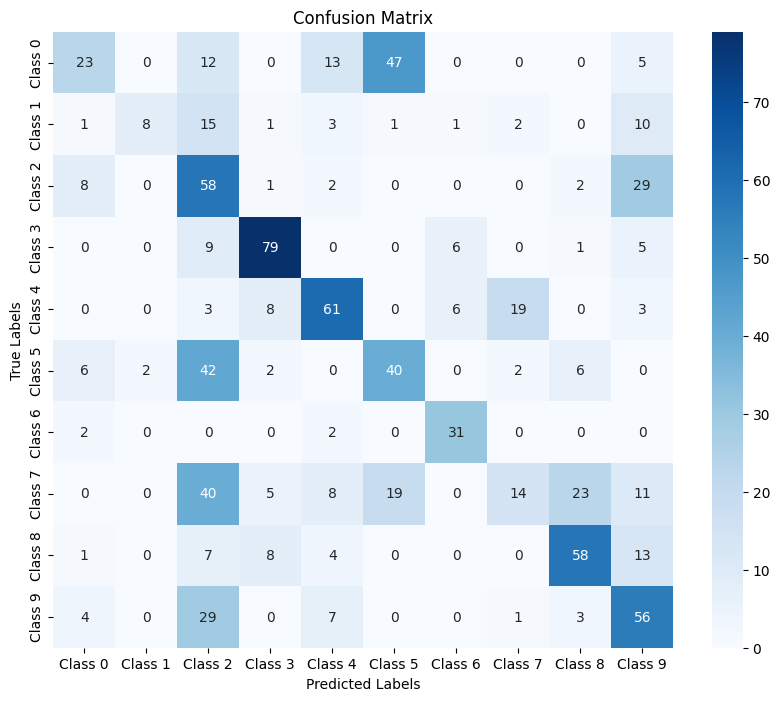


Classification Report
              precision    recall  f1-score   support

           0       0.51      0.23      0.32       100
           1       0.80      0.19      0.31        42
           2       0.27      0.58      0.37       100
           3       0.76      0.79      0.77       100
           4       0.61      0.61      0.61       100
           5       0.37      0.40      0.39       100
           6       0.70      0.89      0.78        35
           7       0.37      0.12      0.18       120
           8       0.62      0.64      0.63        91
           9       0.42      0.56      0.48       100

    accuracy                           0.48       888
   macro avg       0.54      0.50      0.48       888
weighted avg       0.51      0.48      0.47       888



In [53]:
y_pred=rnn_model.predict(x_test_rnn)

y_pred_labels=np.argmax(y_pred, axis=1)
y_test_labels=np.argmax(y_test_rnn_one_hot,axis=1)

from sklearn.metrics import confusion_matrix,classification_report

conf_matrix= confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)

class_names = [f"Class {i}" for i in range(len(conf_matrix))]

# Criar o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report")
print(classification_report(y_true=y_test_labels, y_pred=y_pred_labels))

#### Conclusão de vários testes <a name = "crnn_rnn"></a>
[[voltar a Teste dos Modelos - RNN]](#rnn_tm)

Após terem sido realizados vários testes manuais, tanto com embeddings como sem, concluimos que é relevante referir que:

        - hidden_dims foi o parâmetro que mais influênciou a performance e custo computacional do modelo (de forma geral um hidden_dims mais alto levou a uma melhor performance mas a um custo computacional maior)

        - dropout_rates elevados levam a uma descida considerável na performance do modelo (mesmo em treino)

        - os embeddings não foram capazes de produzir uma boa generalização para o RNN utilizar (possívelmente devido ao uso de um arquitetura bastante simples para um dataset com dados complexos e com noise), em todos os casos em que comparamos o uso dos embeddings com o uso direto das MFCC, a performance foi superior com o uso apenas dos MFCC

### Segunda fase

Após realizarmos diversos testes na primeira fase, concluimos que um dos valores encontrados na grid search deveria ser alterado sendo esse:

        Hidden Dim passou de 128 para 512
        
Os restantes valores mantiveram-se iguais aos encontrados na grid search.

Nesta fase decidimos não utilizar embeddings, pois como mencionado previamente, o modelo LTE não é capaz de criar embeddings representativos das metaclasses. Deste modo, as divisões dos folds foram realizadas do mesmo modo que em [CNN 2D](#cnn_2d_tm).

Abaixo encontra-se o código utilizado para realizar o 10-fold cross validation sem embeddings

[skip code](#sc_3)

In [7]:
accuracies={}
fold_histories=[]
total_conf_matrix=np.zeros((10,10), dtype=int)
for i in range (10):
    input_dim_lte=60
    embedding_dim=8
    num_meta_classes=6

    fold_train_lte=(i%10)+1
    train_lte=df_mfcc[df_mfcc['fold']== fold_train_lte]
    x_train_lte=train_lte.iloc[:,4:]
    y_train_lte=train_lte.iloc[:,2]

    fold_test_rnn=((i+1)%10)+1
    test_rnn=df_mfcc[df_mfcc['fold']== fold_test_rnn]
    x_test_rnn=test_rnn.iloc[:,4:]
    y_test_rnn=test_rnn.iloc[:,2]

    fold_val_rnn=((i+2)%10)+1
    val_rnn=df_mfcc[df_mfcc['fold']== fold_val_rnn]
    x_val_rnn=val_rnn.iloc[:,4:]
    y_val_rnn=val_rnn.iloc[:,2]

    # obter as  metaclass para treinar o modelo de embedding
    y_train_lte=get_meta_classes(y_train_lte).astype('int64')


    y_train_lte_one_hot=tf.keras.utils.to_categorical(y_train_lte,num_classes=num_meta_classes)
    LTE_model= build_LTE_model(input_dim=input_dim_lte, embedding_dim=embedding_dim, num_meta_classes=num_meta_classes)
    LTE_model.fit(x_train_lte, y_train_lte_one_hot, epochs=100, batch_size=128, validation_split=0.2,callbacks=[
        EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ])

    embedding_model= tf.keras.models.Model(inputs=LTE_model.input, outputs=LTE_model.layers[1].output)

    #--------------------------------------------------------------Test dataset preparation------------------------------------------------------
    train_rnn=df_mfcc[~df_mfcc['fold'].isin([fold_train_lte, fold_test_rnn, fold_val_rnn])]
    df_files_names=pd.DataFrame(train_rnn['audio_name'],columns=['audio_name'])
    x_train_rnn=train_rnn.iloc[:,4:]
    y_train_rnn=train_rnn.iloc[:,2]
    #x_train_rnn = embedding_model.predict(x_train_rnn) #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
    #print(f"Shape do LTE features: {x_train_rnn.shape}") #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
    print(f"Shape das MFCC features: {x_train_rnn.shape}")
    
    # Dar reshape do dataset para que seja compatível com o input do RNN
    #x_train_rnn = pd.DataFrame(x_train_rnn, columns=[f"LTE_feature_{i}" for i in range(x_train_rnn.shape[1])]) #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
    # permitir que seja possivel existir uma ligação direta entre x_train_rnn and df_files_names
    x_train_rnn=x_train_rnn.reset_index(drop=True)
    x_train_rnn['audio_name'] = df_files_names['audio_name'].values
    y_train_rnn=y_train_rnn.to_frame(name='classID')
    # permitir que seja possivel existir uma ligação direta entre y_train_rnn and df_files_names
    y_train_rnn=y_train_rnn.reset_index(drop=True)
    y_train_rnn['audio_name'] = df_files_names['audio_name'].values
    print(f"Shape das features do dataset de treino: {x_train_rnn.shape}")
    print(f"Shape das labels do dataset de treino: {y_train_rnn.shape}")
    
    # altrear o shape do y_train_rnn para que seja compatível com o treino
    y_train_rnn=y_train_rnn.groupby('audio_name', as_index=False)['classID'].first()
    y_train_rnn=y_train_rnn['classID']
    
    # alterar o shape do x_train_rnn para que seja um input compatível para treino
    feature_columns = [col for col in x_train_rnn.columns if col != 'audio_name']
    grouped = x_train_rnn.groupby('audio_name')
    
    reshaped_data=[]
    
    for name, group in grouped:
        features=group[feature_columns].values
        # 33 é o numero de times_steps usados para extrair as features mfcc no audio de 4 sec
        if(features.shape[0]!=33):
            raise ValueError(f"O número de time_steps da audio {name} não é o igaul ao esperado, espera-se receber 33 time_steps por audio recebemos {features.shape[0]}")
        
        reshaped_data.append(features)
    
    x_train_rnn=np.stack(reshaped_data, axis=0)
    
    print(f"Shape das features do dataset de treino pós reshaping: {x_train_rnn.shape}")
    
    y_train_rnn_one_hot=tf.keras.utils.to_categorical(y_train_rnn,num_classes=10)
    print(f"Shape das labels do dataset de treino pós reshaping {y_train_rnn_one_hot.shape}")

    #--------------------------------------------------------------Test dataset preparation------------------------------------------------------

    df_files_names=pd.DataFrame(test_rnn['audio_name'],columns=['audio_name'])

    #x_test_rnn = embedding_model.predict(x_test_rnn) #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
    #print(f"Shape do LTE features: {x_test_rnn.shape}")
    print(f"Shape das MFCC features : {x_test_rnn.shape}")
    
    #x_test_rnn = pd.DataFrame(x_test_rnn, columns=[f"LTE_feature_{i}" for i in range(x_test_rnn.shape[1])]) #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
    x_test_rnn=x_test_rnn.reset_index(drop=True)
    x_test_rnn['audio_name'] = df_files_names['audio_name'].values
    
    y_test_rnn=y_test_rnn.to_frame(name='classID')
    # permitir que seja possivel existir uma ligação direta entre y_train_rnn and df_files_names
    y_test_rnn=y_test_rnn.reset_index(drop=True)
    y_test_rnn['audio_name'] = df_files_names['audio_name'].values
    print(f"Shape das features do dataset de teste: {x_test_rnn.shape}")
    print(f"Shape das labels do dataset de teste: {y_test_rnn.shape}")
    
    # altrear o shape do y_train_rnn para que seja compatível com o treino
    y_test_rnn=y_test_rnn.groupby('audio_name', as_index=False)['classID'].first()
    y_test_rnn=y_test_rnn['classID']
    
    # alterar o shape do x_train_rnn para que seja um input compatível para treino
    feature_columns = [col for col in x_test_rnn.columns if col != 'audio_name']
    grouped = x_test_rnn.groupby('audio_name')
    
    reshaped_data=[]
    
    for name, group in grouped:
        features=group[feature_columns].values
        # 33 é o numero de times_steps usados para extrair as features mfcc no audio de 4 sec
        if(features.shape[0]!=33):
            raise ValueError(f"O número de time_steps da audio {name} não é o igaul ao esperado, espera-se receber 33 time_steps por audio recebemos {features.shape[0]}")
        
        reshaped_data.append(features)
    
    x_test_rnn=np.stack(reshaped_data, axis=0)
    
    print(f"Shape das features do dataset de teste pós reshaping: {x_test_rnn.shape}")
    
    y_test_rnn_one_hot=tf.keras.utils.to_categorical(y_test_rnn,num_classes=10)
    print(f"Shape das labels do dataset de teste pós reshaping {y_test_rnn_one_hot.shape}")


    #--------------------------------------------------------------Validation dataset preparation------------------------------------------------------
    df_files_names=pd.DataFrame(val_rnn['audio_name'],columns=['audio_name'])


    #x_val_rnn = embedding_model.predict(x_val_rnn) #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
    #print(f"Shape do LTE features: {x_val_rnn.shape}")
    print(f"Shape das MFCC features : {x_val_rnn.shape}")

    #x_val_rnn = pd.DataFrame(x_val_rnn, columns=[f"LTE_feature_{i}" for i in range(x_val_rnn.shape[1])]) #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
    x_val_rnn=x_val_rnn.reset_index(drop=True)
    x_val_rnn['audio_name'] = df_files_names['audio_name'].values

    y_val_rnn=y_val_rnn.to_frame(name='classID')
    # permitir que seja possivel existir uma ligação direta entre y_train_rnn and df_files_names
    y_val_rnn=y_val_rnn.reset_index(drop=True)
    y_val_rnn['audio_name'] = df_files_names['audio_name'].values
    print(f"Shape das features do dataset de validação: {x_val_rnn.shape}")
    print(f"Shape das labels do dataset de validação: {y_val_rnn.shape}")

    # altrear o shape do y_train_rnn para que seja compatível com o treino
    y_val_rnn=y_val_rnn.groupby('audio_name', as_index=False)['classID'].first()
    y_val_rnn=y_val_rnn['classID']

    # alterar o shape do x_train_rnn para que seja um input compatível para treino
    feature_columns = [col for col in x_val_rnn.columns if col != 'audio_name']
    grouped = x_val_rnn.groupby('audio_name')

    reshaped_data=[]

    for name, group in grouped:
        features=group[feature_columns].values
        # 33 é o numero de times_steps usados para extrair as features mfcc no audio de 4 sec
        if(features.shape[0]!=33):
            raise ValueError(f"O número de time_steps da audio {name} não é o igaul ao esperado, espera-se receber 33 time_steps por audio recebemos {features.shape[0]}")

        reshaped_data.append(features)

    x_val_rnn=np.stack(reshaped_data, axis=0)

    print(f"Shape das features do dataset de validação pós reshaping: {x_val_rnn.shape}")

    y_val_rnn_one_hot=tf.keras.utils.to_categorical(y_val_rnn,num_classes=10)
    print(f"Shape das labels do dataset de validação pós reshaping {y_val_rnn_one_hot.shape}")


    #--------------------------------------------------------------------------------------------------------------------


    input_dim=60 
    #input_dim=8 #-----------------------------------COMENTAR ESTA LINHA PARA NÃO USAR EMBEDDINGS------------------------------------------
    hidden_dim=512
    output_dim=10
    num_layers=2
    dropout_rate=0

    rnn_model= create_model(input_dim=input_dim,hidden_dim=hidden_dim,output_dim=output_dim,num_layers=num_layers,dropout_rate=dropout_rate)

    # x_train_rnn tem shape (num_samples, time_steps, input_dim)
    # y_train é one-hot encoded com shape (num_samples, output_dim)
    history = rnn_model.fit(x_train_rnn, y_train_rnn_one_hot, batch_size=64, epochs=50,validation_data=(x_val_rnn,y_val_rnn_one_hot),callbacks=[
        EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, min_lr=1e-6)
    ])

    fold_histories.append(history)

    y_pred=rnn_model.predict(x_test_rnn)

    y_pred_labels=np.argmax(y_pred, axis=1)
    y_test_labels=np.argmax(y_test_rnn_one_hot,axis=1)
    
    conf_matrix= confusion_matrix(y_true=y_test_labels, y_pred=y_pred_labels)
    total_conf_matrix=np.add(total_conf_matrix,conf_matrix)

    # Total correct predictions are the diagonal elements of the confusion matrix
    correct_predictions = np.trace(conf_matrix)  # Sum of diagonal ele
    # Total number of samples
    total_predictions = np.sum(conf_matrix)  # Sum of all ele
    # Average accuracy
    accuracy = correct_predictions / total_predictions
    print(f"Accuracy: {accuracy:.4f}")
    accuracies[f'Fold{i+1}']=accuracy

Epoch 1/100


2024-12-03 08:28:03.863460: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3136 - loss: 14.2343 - val_accuracy: 0.5285 - val_loss: 2.8245 - learning_rate: 0.0010
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.5632 - loss: 2.1001 - val_accuracy: 0.6045 - val_loss: 1.3951 - learning_rate: 0.0010
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.6342 - loss: 1.2121 - val_accuracy: 0.6536 - val_loss: 1.0384 - learning_rate: 0.0010
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.6851 - loss: 0.9149 - val_accuracy: 0.7011 - val_loss: 0.9056 - learning_rate: 0.0010
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.7153 - loss: 0.7885 - val_accuracy: 0.7098 - val_loss: 0.8297 - learning_rate: 0.0010
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7294 - loss: 0.7134 - val_accuracy: 0.7263 - val_loss: 0.7718 - learning_rate: 0.0010
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.7415 - loss: 0.6

[end of skip]<a name = "sc_3"></a>

Uma coisa que notamos após realizarmos o 10 fold cross validation, é que embora de facto hidden_dims = 512 produza melhores resultados, a diferença na accuracy média é de apenas 1% sendo que apenas em alguns folds é notada uma diferença significativa a nivel da perfomance, quando comparando com hidden_dims = 128 (teste realizado à parte). No entanto, o tempo de treino baixa drasticamente de 120 minutos para apenas 20 minutos o que nos leva a considerar que fosse possível com data_augmentation ou um tunning mais intensivo dos parâmetros obter performances iguais ou superiores com um hidden_dims = 128.

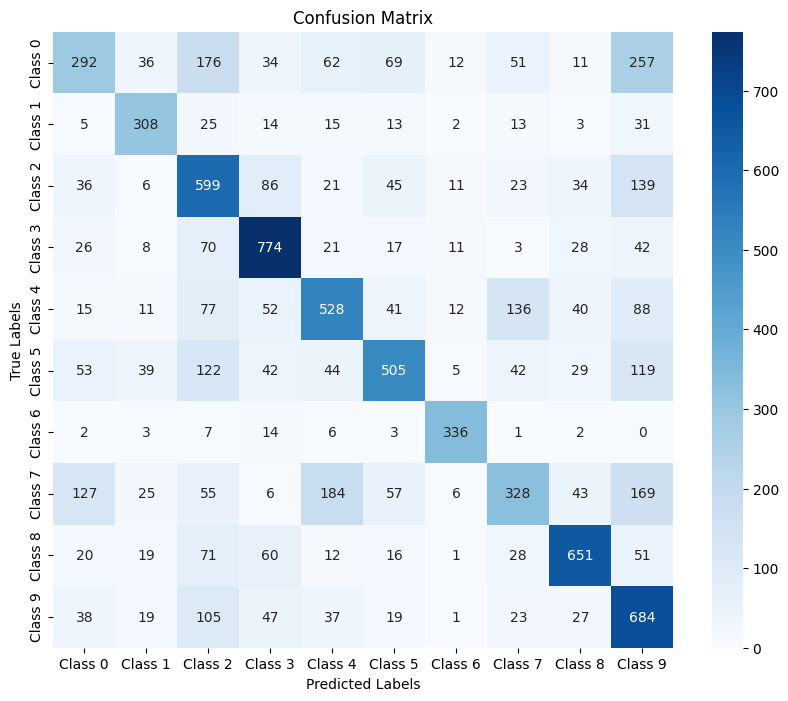

In [8]:
class_names = [f"Class {i}" for i in range(len(conf_matrix))]

# Criar o heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(total_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def visualize_metrics_rnn(results_df, mean_accuracy, std_accuracy, fold_histories):
    
    
    # Accuracy por fold
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['accuracy'], results_df['fold'], marker='o', label="Fold Accuracy")
    plt.axhline(y=mean_accuracy, color='r', linestyle='--', label=f"Mean Accuracy ({mean_accuracy:.4f})")
    plt.fill_between(
        range(len(results_df)), mean_accuracy - std_accuracy, mean_accuracy + std_accuracy,
        color='r', alpha=0.2, label=f"± Std Dev ({std_accuracy:.4f})"
    )
    plt.title("Fold-wise Accuracy")
    plt.xlabel("Fold")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig("./results_images/fold_accuracy_rnn.png")
    plt.show()

   

    # Curvas de treino e de validação
    for i, history_obj in enumerate(fold_histories):
        plt.figure(figsize=(12, 5))
        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(history_obj.history['loss'], label='Training Loss')
        plt.plot(history_obj.history['val_loss'], label='Validation Loss')
        plt.title(f"Fold {i+1} - Training and Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        # Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history_obj.history['accuracy'], label='Training Accuracy')
        plt.plot(history_obj.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f"Fold {i+1} - Training and Validation Accuracy")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(f"./results_images/learning_curves_rnn_fold_{i+1}.png")
        plt.show()

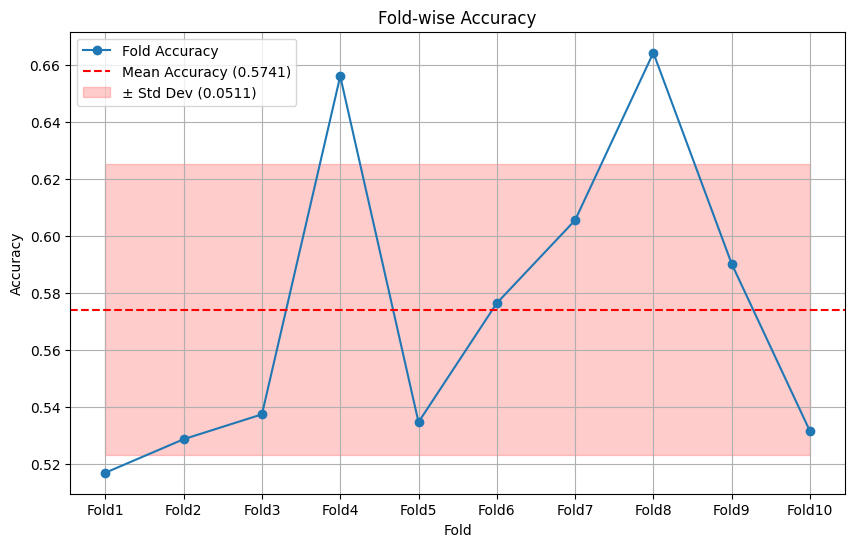

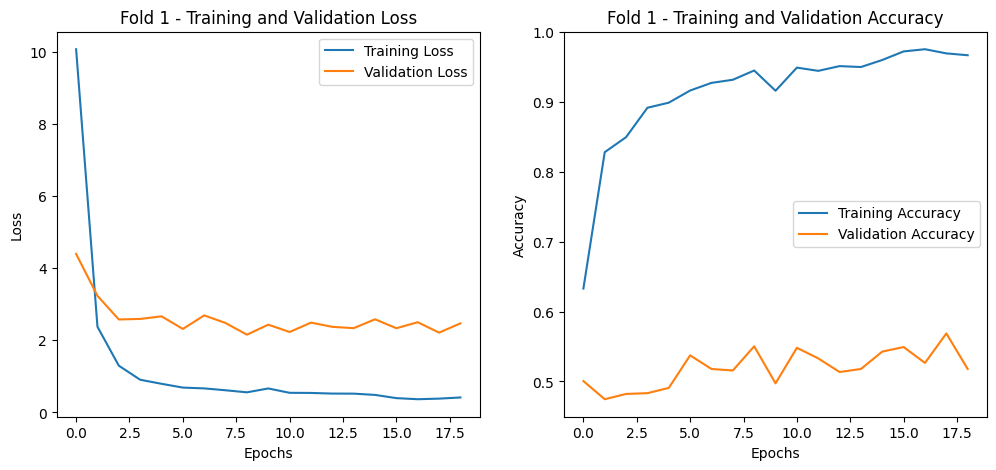

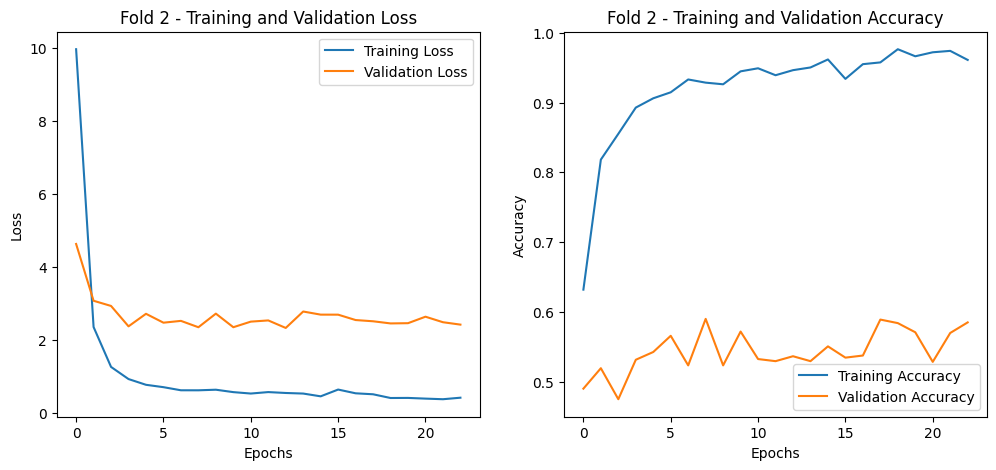

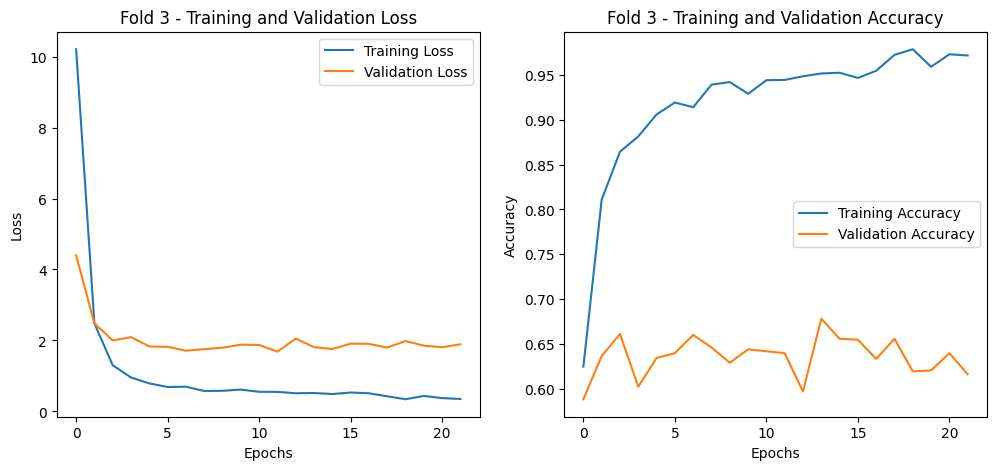

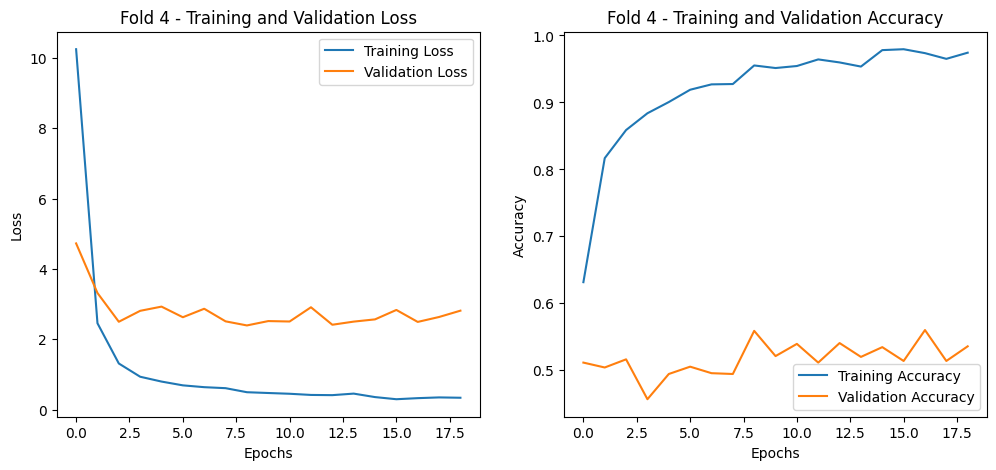

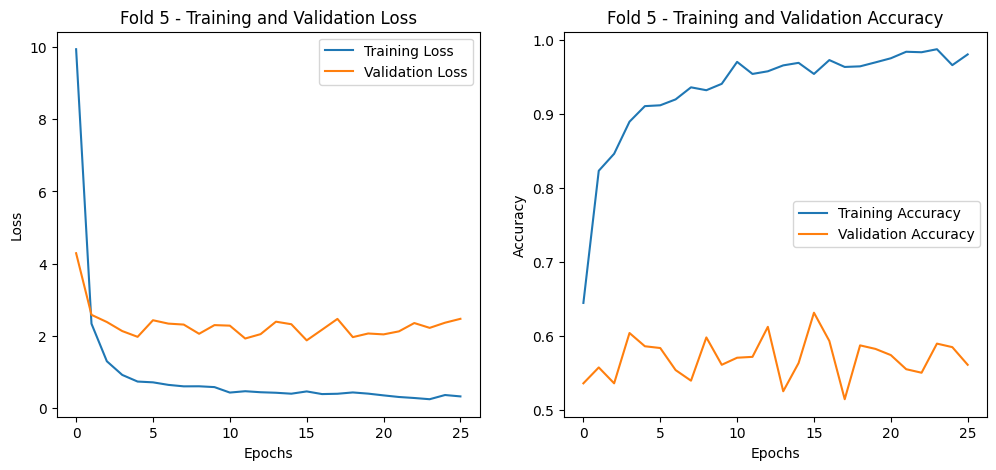

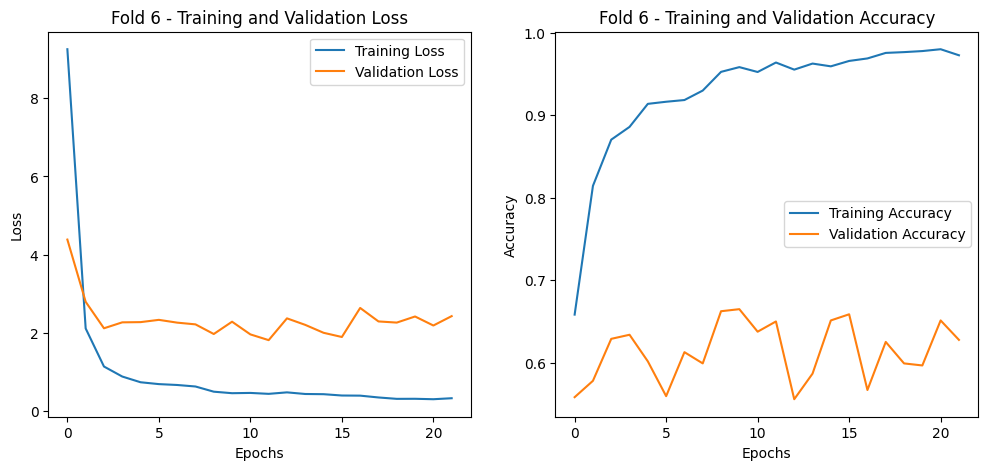

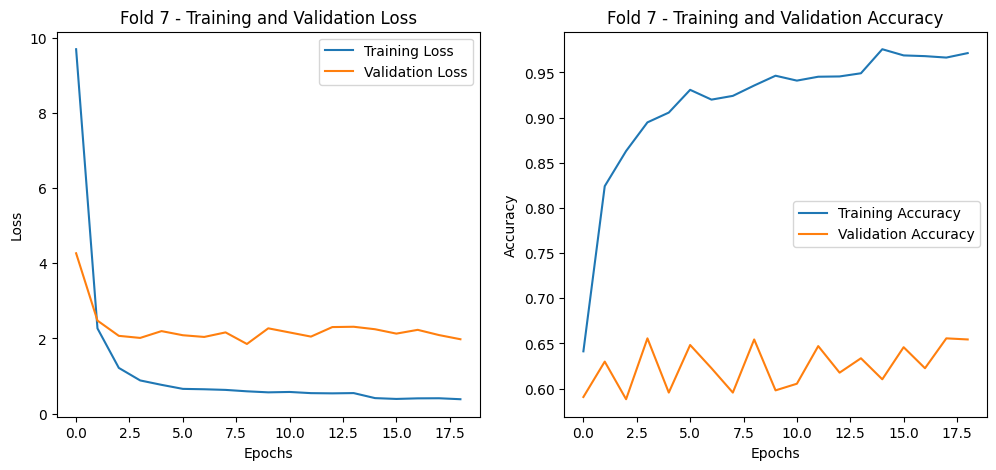

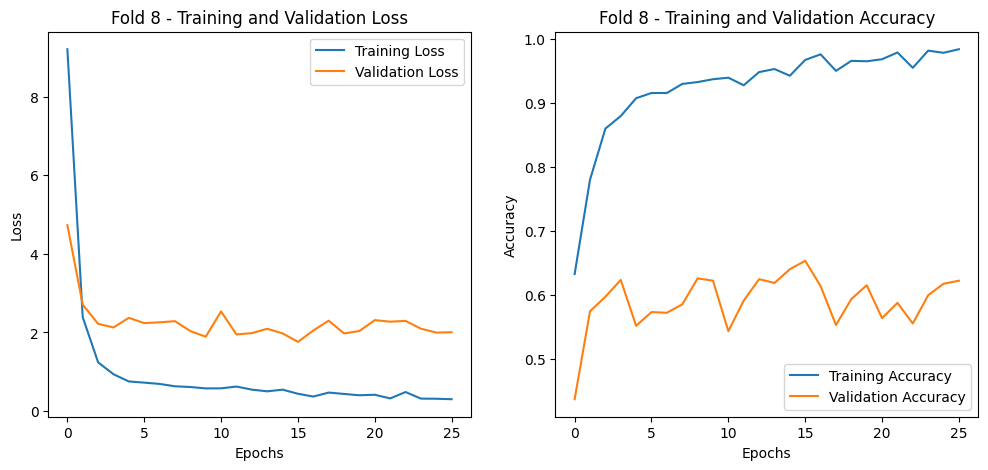

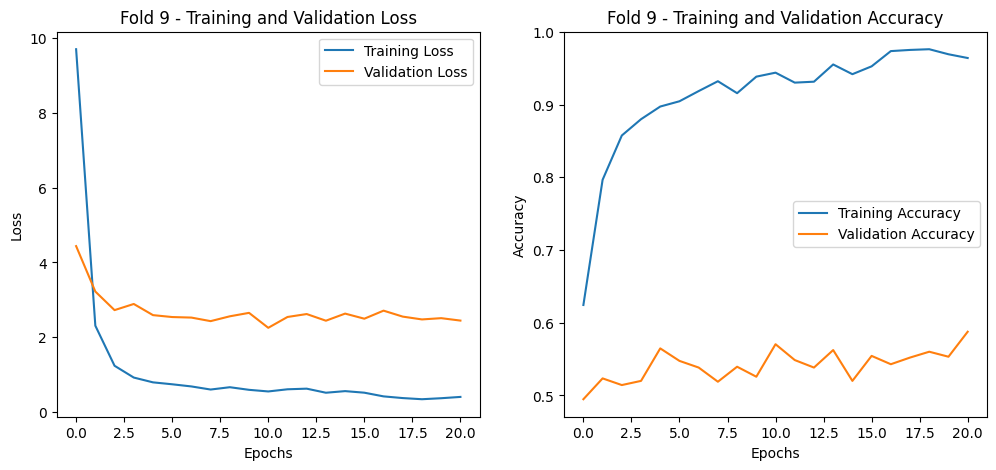

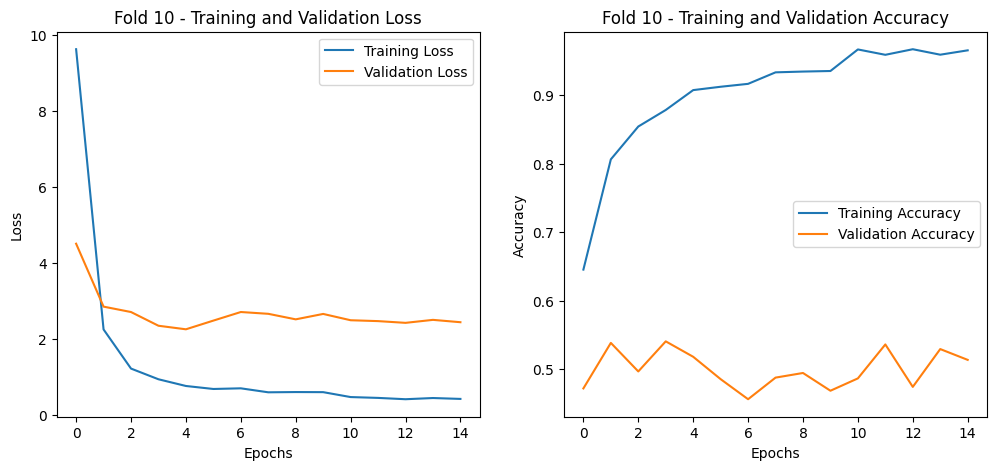

In [47]:
results_df=pd.DataFrame(data=list(accuracies.items()), columns=['accuracy','fold'])
mean_accuracy = np.mean(list(accuracies.values()))
std_accuracy = np.std(list(accuracies.values()))
visualize_metrics_rnn(
    results_df=results_df,
    mean_accuracy=mean_accuracy,
    std_accuracy=std_accuracy,
    fold_histories=fold_histories,
)

### Análise de Resultados <a name = "rnn_ar"></a>
[[voltar a Teste dos Modelos - RNN]](#rnn_tm)

Observando o gráfico da accuracy em cada fold é possível perceber que existe uma variância considerável entre as folds, sendo essa cerca de 5%. Tal facto pode estar relacionado com o facto de o modelo não ser capaz de generalizar de forma muito eficaz, tal como pode ser comprovado através das curvas de aprendizagem, que permitem identificar que há overfitting.

Em futuras iterações deste trabalho utilizar data augmentation poderia ser uma boa forma de tentar reduzir esse overfitting. Mesmo aumentando drásticamente o valor de regularização do L2, o que permitiu reduzir o quão rápido o overfitting acontecia, não foi possivel diminui-lo, o que consequentemente fez com que o treino se perlongasse e a accuracy subisse.

## Implementação do DeepFool <a name = "dp"></a>
[[voltar ao Indice]](#indice)

O DeepFool é um algoritmo que identifica a menor alteração necessária nos dados de entrada do modelo para "enganar" o classificador, fazendo-o mudar a sua decisão. É usado para avaliar a vulnerabilidade de modelos a ataques adversariais, ajudando a medir a robustez e identificar fragilidades em redes neurais profundas.

A função abaixo é uma adaptação do estudo fornecido pelo professor, uma vez que no estudo disponibilizado, [[9]](#ref_9) o DeepFool é utilizado em imagens, sendo que aqui é dado ao DeepFool um vetor de MFCC's.

De um modo geral são adicionadas interferências de modo a tentar alterar a classificação final do modelo. Essas perturbações são calculadas atravez do gradiente, que utiliza a fórmula encontrada no estudo [[9]](#ref_9).

In [ ]:
def deepfool_mfcc(mfcc, model, num_classes=10, overshoot=0.02, max_iter=50):
    # Ensure the input is a NumPy array and expand dims for batch size
    mfcc = np.expand_dims(mfcc, axis=0)  # Shape: (1, num_frames, num_coefficients)
    perturbed_mfcc = copy.deepcopy(mfcc)

    # Compute initial prediction
    logits = model(tf.convert_to_tensor(mfcc, dtype=tf.float32))  # Forward pass
    logits = logits.numpy().flatten()
    top_classes = np.argsort(logits)[::-1][:num_classes]  # Top `num_classes` sorted indices
    original_label = top_classes[0]  # Most probable class

    # Initialize variables
    r_tot = np.zeros_like(mfcc)  # Accumulated perturbation
    loop_i = 0
    current_label = original_label

    while current_label == original_label and loop_i < max_iter:
        pert = np.inf  # Initialize smallest perturbation
        grads_orig = None  # Gradient of the original class

        with tf.GradientTape() as tape:
            # Set tape to watch input tensor
            input_tensor = tf.convert_to_tensor(perturbed_mfcc, dtype=tf.float32)
            tape.watch(input_tensor)

            # Compute logits and focus on original class
            logits = model(input_tensor)
            logits = tf.reshape(logits, [-1])
            score_original = logits[top_classes[0]]  # Original class score

        # Compute gradient for the original class
        grads_orig = tape.gradient(score_original, input_tensor).numpy()

        # Loop through the remaining classes
        for k in range(1, num_classes):
            with tf.GradientTape() as tape:
                tape.watch(input_tensor)
                logits = model(input_tensor)
                logits = tf.reshape(logits, [-1])
                score_k = logits[top_classes[k]]  # Score for class `k`

            # Compute gradient for class `k`
            grads_k = tape.gradient(score_k, input_tensor).numpy()

            # Compute perturbation direction and magnitude
            w_k = grads_k - grads_orig  # Direction
            f_k = (logits[top_classes[k]] - logits[top_classes[0]]).numpy()  # Difference in logits
            pert_k = abs(f_k) / (np.linalg.norm(w_k.flatten()) + 1e-4)  # Magnitude

            # Select the smallest perturbation
            if pert_k < pert:
                pert = pert_k
                w = w_k

        # Update total perturbation
        r_i = (pert + 1e-4) * w / np.linalg.norm(w.flatten())
        r_tot = r_tot + r_i

        # Add perturbation to the original MFCC
        perturbed_mfcc = mfcc + (1 + overshoot) * r_tot

        # Check if the perturbed input fools the model
        logits = model(tf.convert_to_tensor(perturbed_mfcc, dtype=tf.float32)).numpy().flatten()
        current_label = np.argmax(logits)

        loop_i += 1

    # Final perturbation (scaled by overshoot factor)
    r_tot = (1 + overshoot) * r_tot

    return r_tot.squeeze(), loop_i, original_label, current_label, perturbed_mfcc.squeeze()


In [64]:
count=0
percentage=0
total_pertubations=0
for mfcc_example in x_test_rnn:
    r_tot, loop_i, original_label, pert_label, perturbed_mfcc = deepfool_mfcc(
        mfcc = mfcc_example,
        model = rnn_model,
        num_classes = 10,
        overshoot = 0.02,
        max_iter = 50
    )
    count+=1
    if(count>=percentage*len(x_test_rnn)):
        percentage+=0.01
        print(f"Currently in part {int(percentage*100)}/100")

    perturbation_magnitude=np.linalg.norm(r_tot)
    mfcc_example_magnitude=np.linalg.norm(mfcc_example)

    total_pertubations+=perturbation_magnitude/mfcc_example_magnitude
    
avg_robustness=total_pertubations/count

print(f"The average roboustness is {avg_robustness}")

Currently in part 1/100
Currently in part 2/100
Currently in part 3/100
Currently in part 4/100
Currently in part 5/100
Currently in part 6/100
Currently in part 7/100
Currently in part 8/100
Currently in part 9/100
Currently in part 10/100
Currently in part 10/100
Currently in part 11/100
Currently in part 12/100
Currently in part 13/100
Currently in part 15/100
Currently in part 16/100
Currently in part 17/100
Currently in part 18/100
Currently in part 19/100
Currently in part 20/100
Currently in part 21/100
Currently in part 22/100
Currently in part 23/100
Currently in part 24/100
Currently in part 25/100
Currently in part 26/100
Currently in part 27/100
Currently in part 28/100
Currently in part 29/100
Currently in part 30/100
Currently in part 31/100
Currently in part 32/100
Currently in part 33/100
Currently in part 34/100
Currently in part 35/100
Currently in part 36/100
Currently in part 37/100
Currently in part 38/100
Currently in part 39/100
Currently in part 40/100
Currently

In [65]:
avg_robustness

0.06677267933087398

Concluimos que o modelo RNN é bastante frágil a alterações nos seus inputs (MFCC's), uma vez que o valor de robustez obtido é muito baixo.

## Conclusão <a name = "conclusao"></a>
[[voltar ao índice]](#indice)

Em suma, fomos capazes de criar classificadores com uma accuracy razoável para o dataset apresentado, especialmente o CNN 2D, com a possibilidade de no futuro tentar melhorar o RNN. Ao longo deste trabalho apercebemo-nos que um grande desafio deste projeto é o overfitting dos modelos, o que provavelmente deve-se ao facto do dataset conter dados reais que são de complexa análise/classificação. Assim sendo, ficamos a perceber que a escolha de estratégias de regularização, como dropout, aumento de dados (data augmentation) e a utilização de métodos de validação cruzada, é fundamental para lidar com a complexidade dos dados reais. Além disso, reconhecemos a importância de arquiteturas mais robustas e de possíveis melhorias no pré-processamento dos dados para aumentar a generalização dos modelos. 
Este projeto permitiu-nos compreender melhor os desafios práticos na aplicação de deep learning a dados reais, reforçando a necessidade de abordagens cuidadosamente planeadas para garantir modelos mais eficientes e robustos.

## Referências <a name = "ref"></a>
[[voltar ao índice]](#indice)

[1] <a name = "ref_1"></a> https://urbansounddataset.weebly.com/urbansound8k.html

[2] <a name = "ref_2"></a> http://www.justinsalamon.com/uploads/4/3/9/4/4394963/salamon_urbansound_acmmm14.pdf

[3] <a name = "ref_3"></a> https://www.nature.com/articles/s41598-024-60813-0#Sec8

Haifeng Zhao, Yanming Ye, Xingfa Shen & Lili Liu 

[4] <a name = "ref_4"></a> [https://www.sciencedirect.com/science/article/abs/pii/S0957417419304403]

[5] <a name = "ref_5"></a> https://www.researchgate.net/publication/349660725_Urban_Sound_Classification_using_CNN

Massoudi, M., Verma, S., & Jain, R. (2021). Urban Sound Classification using CNN. Proceedings of the Sixth International Conference on Inventive Computation Technologies (ICICT). IEEE.

[6] <a name = "ref_6"></a> https://www.karolpiczak.com/papers/Piczak2015-ESC-ConvNet.pdf

Piczak, K. J. (2015). Environmental Sound Classification with Convolutional Neural Networks. 2015 IEEE International Workshop on Machine Learning for Signal Processing (MLSP), Boston, USA. IEEE.

[7] <a name = "ref_7"></a> https://github.com/SanketSonu/UrbanSound8K/blob/main/Project%20Report.pdf

[8] <a name = "ref_8"></a> https://arxiv.org/pdf/1703.04770

[9] <a name = "ref_9"></a> https://medium.com/machine-intelligence-and-deep-learning-lab/a-review-of-deepfool-a-simple-and-accurate-method-to-fool-deep-neural-networks-b016fba9e48e#:~:text=DeepFool%20finds%20the%20minimal%20perturbations,so%20the%20classification%20label%20changes.